# Technical appendix - TEMPORALFORECASTING

## A. Objectives & scope

* **Goal:** production-grade temporal forecasting by region/segment with exogenous drivers (weather HDD/CDD and Google Trends), using a **config-driven pipeline** derived from the notebook’s `ForecastingPipelineV2`, `ExpandingWindowCV`, `SARIMAXModel`, and baselines (`SeasonalNaive`, `ETSModel`).
* **Outputs:** `reports/tables/cv_results.csv`, `reports/tables/forecasts.csv`, plots in `reports/figures/`, and serialised models in `models/`.

## B. Data contracts

* **Target table (long format):**

  * `region: str`, `date: month-start (datetime64[ns])`, `quantity: float`, `unit: str`
  * Optional: `segment: str`, `aggregation_period: str` (validated then normalised to monthly index).
* **External tables:**

  * `weather_monthly`: `region`, `date`, `t_mean`, `hdd(base)`, `cdd(base)` (+ coverage %)
  * `trends_monthly`: `region`, `date`, `kw_<name> (0–100)` rescaled to monthly
* **Constraints:** no duplicate `(region,date)` after merge; strictly increasing `date` per region; missingness thresholds configurable in `features.yaml`.

## C. External data & caching

* **Geocoding:** `OpenMeteoGeocoder` resolves `region → (lat, lon)` with UK-first bias; results cached to `external/weather/geocodes.parquet`.
* **Weather:** `OpenMeteoClient` pulls historical daily temps; monthly aggregation; HDD/CDD computed with base temps from `features.yaml`. Caching with ETag/hash under `cache/`.
* **Trends:** `GoogleTrendsClient` fetches weekly indices via pytrends, rescales to monthly mean, and handles partial weeks at period edges; cached under `external/trends/`.

## D. Feature engineering

* **Calendar:** month/quarter cyclical encodings; seasonal dummies.
* **Weather:** HDD/CDD per region, alternative bases allowed (e.g., 15.5°C/18°C); carry-forward/backfill for short gaps with coverage % recorded.
* **Trends:** keyword set from `trends.yaml`; z-score optional; guard against spurious spikes via winsorization.
* **Decomposition:** STL to extract trend/seasonal components, optionally used as exog.
* **Leakage guards:** all exogenous series aligned strictly `≤ t` for forecasts at `t+H`; `ensure()` asserts alignment.

## E. Models

* **Baselines:** `SeasonalNaive` (last season), `ETSModel` (Error-Trend-Seasonal).
* **Primary:** `SARIMAXModel` (and notebook-inspired `RegionalSarimax` / `SarimaxHddCdd`) with optional exog = `[HDD, CDD, trends, seasonal dummies, STL trend]`.
* **Hyperparams:** grids from `ets.yaml` and `sarimax.yaml`; selection by AIC/BIC or CV metric; enforce invertibility/stationarity; differencing `d, D` inferred or configured.
* **Intervals:** percentile or Gaussian (from state-space) prediction intervals; coverage checked in CV.

## F. Cross-validation & evaluation

* **Protocol:** `ExpandingWindowCV` with folds from `cv.yaml` (e.g., horizon `H=6`, step `1`, min train length).
* **Metrics:** `MAE`, `RMSE`, `MAPE`, `sMAPE`; tie-breaker AIC if equal; optional weighted metrics by region volume.
* **Diagnostics:** residual ACF/PACF, Ljung–Box p-values, forecast vs. actuals, error heatmaps (region×month).

## G. Orchestration (PipelineV2)

1. **Load:** `DataLoader` reads raw targets + region list; validates via `schemas.py`.
2. **External:** `fetch_weather.py` and `fetch_trends.py` populate `data/external/`.
3. **Engineer:** `FeatureEngineer` composes calendar, HDD/CDD, trends, STL.
4. **Merge:** `Merger` performs key-based joins following `merge.yaml` precedence.
5. **CV:** `cv.py` evaluates candidate models; writes `cv_results.csv` with fold-level metrics.
6. **Fit/Select:** `fit.py` retrains best-per-region on full history with chosen exog set.
7. **Forecast:** `forecast.py` emits point & interval forecasts for horizon `H`; writes `forecasts.csv`.
8. **Report:** `build_report.py` compiles figures/tables into `report.html`.

## H. CLI examples

* **Fetch externals:**

  * `python -m temporal_forecasting.cli.fetch_weather --config configs/weather.yaml`
  * `python -m temporal_forecasting.cli.fetch_trends  --config configs/trends.yaml`
* **Prep & features:**

  * `python -m temporal_forecasting.cli.prep --config configs/data.yaml --features configs/features.yaml`
* **Cross-validate:**

  * `python -m temporal_forecasting.cli.cv --config configs/cv.yaml --models ets sarimax`
* **Fit & forecast:**

  * `python -m temporal_forecasting.cli.fit --pipeline configs/pipeline.yaml`
  * `python -m temporal_forecasting.cli.forecast --pipeline configs/pipeline.yaml --horizon 12`

## I. Artefacts & metadata

* **Tables:** CSV + Parquet with ISO-8601 dates; UTF-8; snake\_case.
* **Models:** `joblib/pickle` in `models/{model}/{model}_{region}.pkl` with `metadata.json` capturing config hash, git SHA, timestamp, CV scores, and exog columns.
* **Figures:** `.png` (2× DPI) and `.svg` for vector plots.

## J. Reproducibility & ops

* **Determinism:** `seed_everywhere(seed)` for Python/NumPy/sklearn; statsmodels determinism ensured by fixed initial states where applicable.
* **Logging:** structured JSON logs + concise console; include region/fold context and timings.
* **Pre-commit/CI:** ruff+black+isort+nbstripout; GitHub Actions runs lint/tests; publishes artefacts on tags.

## K. Testing strategy

* **Clients:** golden-response fixtures for Open-Meteo and pytrends; dry-run mode that fabricates deterministic series.
* **Features:** HDD/CDD identity tests vs. hand-computed examples; STL reconstructability (`trend+seasonal+resid≈original`).
* **CV:** split boundaries, no leakage of exog beyond `t`.
* **Models:** shape tests, interval coverage, refits consistent across seeds; SARIMAX exog alignment invariants.
* **End-to-end:** tiny dataset (2–3 regions) exercises full pipeline and asserts artefact presence.

## L. Migration notes from the notebook

* Map notebook classes to modules:

  * `OpenMeteoGeocoder/OpenMeteoClient` → `clients/open_meteo.py`
  * `GoogleTrendsClient` → `clients/google_trends.py`
  * `FeatureEngineer`, `WeatherTrendsAndDecomp` → `features/` + `pipeline/feature_engineer.py`
  * `SeasonalNaive`, `ETSModel`, `SARIMAXModel`, `RegionalSarimax(HddCdd)` → `models/`
  * `ExpandingWindowCV`, `Evaluator` → `cv/`
  * `ForecastingPipelineV2` → `pipeline/pipeline_v2.py`
* Replace ad-hoc globals with config dataclasses or pydantic models bound to YAML.
* Keep notebook for EDA; enforce `nbstripout` to remove execution counts and outputs.


In [1]:
# ████████████████████████████████ PROJECT STRUCTURE ██████████████████████████████████
# temporal-forecasting/
# ├── pyproject.toml                 # Build + deps (poetry/pip-tools). Python ≥3.10
# ├── README.md                      # Overview, architecture, quickstart
# ├── .env.example                   # Runtime vars (proxies), no secrets needed for Open-Meteo/pytrends
# ├── .gitignore                     # Ignore data/cache/artefacts/logs, *.ipynb_checkpoints
# ├── .pre-commit-config.yaml        # Ruff, Black, isort, nbstripout
# ├── Makefile                       # make setup|fetch|prep|cv|fit|forecast|report|test
# ├── docker/
# │   ├── Dockerfile                 # Slim CPU image with statsmodels, pytrends, prophet optional
# │   └── start.sh                   # Entrypoint/healthcheck
# ├── configs/                       # YAML/TOML configs for fully declarative runs
# │   ├── data.yaml                  # Input paths, table names, read options
# │   ├── regions.csv                # Canonical region list (for geocoding + joins)
# │   ├── features.yaml              # Calendar, rolling windows, STL flags, HDD/CDD bases
# │   ├── weather.yaml               # Locations, aggregation rules, cache policies
# │   ├── trends.yaml                # Keywords, categories, geography, weekly→monthly resampling
# │   ├── merge.yaml                 # Join keys, conflict strategy, precedence
# │   ├── cv.yaml                    # Expanding-window CV folds, horizon, step size, metrics
# │   ├── ets.yaml                   # ETS hyperparams grid
# │   ├── sarimax.yaml               # (p,d,q)(P,D,Q)m grid, exog selection, constraints
# │   └── pipeline.yaml              # Orchestrates loader→features→models→evaluator→writer
# ├── data/                          # Data Lake-ish layout (raw/interim/processed/external)
# │   ├── raw/                       # Immutable extracts (CSV/Parquet) + checksums
# │   ├── interim/                   # Cleaned/typed/validated tables
# │   ├── processed/                 # Model-ready tables (wide/long)
# │   └── external/                  # Third-party pulls (weather/, trends/) with cache.json
# ├── cache/                         # HTTP/cachetools memo for API responses (safe to delete)
# ├── notebooks/
# │   └── TemporalForecasting.ipynb  # (uploaded) geocoding→weather→trends→features→CV→SARIMAX
# ├── src/
# │   └── temporal_forecasting/
# │       ├── __init__.py            # Version, public API
# │       ├── logging.py             # Structured logging (JSON), rich console
# │       ├── io.py                  # Robust CSV/Parquet IO, compression, dtype maps
# │       ├── schemas.py             # Pandera/pyarrow schemas for data/feature/exog tables
# │       ├── utils.py               # ensure(), timer, seeded RNG, date helpers (to_month_start)
# │       ├── clients/               # External data clients
# │       │   ├── open_meteo.py      # OpenMeteoGeocoder, OpenMeteoClient (historical temps)
# │       │   └── google_trends.py   # GoogleTrendsClient (weekly → monthly normalization)
# │       ├── features/              # Feature engineering
# │       │   ├── calendar.py        # cyclical month/quarter, seasonal dummies
# │       │   ├── weather.py         # HDD/CDD builders, temp aggregations, gaps handling
# │       │   ├── trends.py          # Keyword selection, resampling, scale alignment
# │       │   └── decompose.py       # STL/seasonal_decompose helpers for trend/seasonality
# │       ├── merge/                 # Controlled joins & conflict resolution
# │       │   └── merge.py           # Merger configured by merge.yaml
# │       ├── models/                # Time-series models (BaseTSModel + concrete impls)
# │       │   ├── base.py            # BaseTSModel, fit/predict/predict_interval interface
# │       │   ├── naive.py           # SeasonalNaive baseline
# │       │   ├── ets.py             # ETSModel wrapper
# │       │   └── sarimax.py         # SARIMAXModel + RegionalSarimax(+HDD/CDD)
# │       ├── cv/                    # Cross-validation & evaluation
# │       │   ├── expanding.py       # ExpandingWindowCV (rolling-origin evaluation)
# │       │   └── evaluator.py       # Metrics (MAE/RMSE/MAPE/sMAPE), model ranking
# │       ├── pipeline/              # Orchestration
# │       │   ├── data_loader.py     # DataLoader (regions, inventory, target)
# │       │   ├── feature_engineer.py# FeatureEngineer (WeatherTrendsAndDecomp)
# │       │   ├── pipeline_v2.py     # ForecastingPipelineV2 (config-driven)
# │       │   └── writer.py          # Table/artefact/metadata writers
# │       ├── plotting.py            # apply_serl_theme(), time-series plots, diagnostics
# │       └── cli/                   # Typer/argparse CLIs
# │           ├── fetch_weather.py   # Resolve coords, pull Open-Meteo, write external/weather
# │           ├── fetch_trends.py    # Pull pytrends, write external/trends
# │           ├── prep.py            # Clean & validate → data/interim + processed
# │           ├── cv.py              # Run ExpandingWindowCV across models
# │           ├── fit.py             # Fit best model per region/segment
# │           └── forecast.py        # Generate forecasts + intervals for horizon H
# ├── scripts/
# │   ├── build_report.py            # Compile tables & figures → HTML/PDF report
# │   └── export_heatmap.py          # Region×month error/volume heatmaps
# ├── models/                        # Saved artefacts (joblib/pickle) + metadata.json
# │   ├── ets/                       # ets_{region}.joblib
# │   └── sarimax/                   # sarimax_{region}.pkl (HDD/CDD variants)
# ├── reports/                       # Generated outputs
# │   ├── figures/                   # Forecast vs actual, ACF/PACF, residuals, CV curves
# │   ├── tables/                    # cv_results.csv, forecasts.csv, feature_inventory.csv
# │   └── report.html                # Shareable single-file HTML
# ├── tests/                         # Pytest suite
# │   ├── test_clients_open_meteo.py # Geocoding + weather pull (dry-run fixtures)
# │   ├── test_clients_trends.py     # Trends weekly→monthly alignment invariants
# │   ├── test_features_weather.py   # HDD/CDD correctness (base temp, aggregation)
# │   ├── test_decompose.py          # STL stability & reconstructability
# │   ├── test_cv.py                 # ExpandingWindowCV splits & leakage guards
# │   ├── test_models_naive.py       # SeasonalNaive forecast shape
# │   ├── test_models_ets.py         # ETS fit/predict round-trip
# │   └── test_models_sarimax.py     # SARIMAX exog alignment, intervals, diagnostics
# └── ci/
#     └── pipeline.yaml              # Lint→Test→Build; cache deps & artefacts


In [1]:
# ████████████████████████████████ BANNER & ENVIRONMENT CHECK   ██████████████████████████████████

# ╔════════════════════════════╗
# ║ BANNER & ENVIRONMENT CHECK ║
# ╚════════════════════════════╝
from __future__ import annotations

import os
import sys
import platform
import importlib
import warnings
from datetime import datetime
from typing import Any, Dict, List, Optional, Sequence, Tuple

from dataclasses import dataclass, field
import itertools
import math
import re

import numpy as np
import pandas as pd
from IPython.display import HTML
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns  # Add this at the start

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf as sm_acf, pacf as sm_pacf

# Keep warnings under control
warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None  # suppress SettingWithCopyWarning


# Prefer the standard library zoneinfo (Python 3.9+); fall back gracefully.
try:
    from zoneinfo import ZoneInfo  # type: ignore[attr-defined]
except Exception:  # pragma: no cover
    ZoneInfo = None  # type: ignore[assignment]

# Avoid noisy warnings in quick audits
warnings.filterwarnings("ignore")

# ╔════════════════════════════╗
# ║ CONFIGURATION              ║
# ╚════════════════════════════╝
@dataclass(frozen=True, slots=True)
class Config:
    """Runtime configuration for the audit and smoke test."""

    tz_name: str = "Europe/London"
    dry_run: bool = bool(int(os.getenv("DRY_RUN", "0")))  # set DRY_RUN=1 to skip GT call
    gt_geo: str = "GB"
    gt_timeframe: str = "2023-01-01 2023-12-31"
    gt_keywords: Tuple[str, ...] = ("smart meter",)


# ╔════════════════════════════╗
# ║ UTILITIES                  ║
# ╚════════════════════════════╝
def _line(char: str = "—", n: int = 72) -> None:
    """Pretty print a separator line."""
    print(char * n)

def _safe_import(name: str) -> Optional[Any]:
    """Attempt to import a module by name, returning None on failure."""
    try:
        return importlib.import_module(name)
    except Exception:
        return None

def _ver(mod: Optional[Any], default: str = "not installed") -> str:
    """Return a module's __version__ if available, otherwise a default label."""
    try:
        return getattr(mod, "__version__", default) if mod is not None else default
    except Exception:
        return default

# importlib.metadata (prefer stdlib)
try:
    from importlib.metadata import version as _pkg_version, PackageNotFoundError
except Exception:  # pragma: no cover
    from importlib_metadata import version as _pkg_version, PackageNotFoundError  # type: ignore

def pkg_version(name: str) -> str:
    """Read the distribution package version using importlib.metadata."""
    try:
        return _pkg_version(name)
    except PackageNotFoundError:
        return "not installed"
    except Exception:
        return "unknown"

# ╔════════════════════════════╗
# ║ ENVIRONMENT REPORT         ║
# ╚════════════════════════════╝
def print_banner(cfg: Config) -> None:
    """Print a compact system + library banner with a tz-aware timestamp."""
    print("⚙️  Forecasting — Environment Check (Akanksha’s Dissertation)")
    _line()
    print(f"Python           : {platform.python_version()}  |  {platform.system()} {platform.release()}")
    print(f"Implementation   : {platform.python_implementation()}")
    print(f"Executable       : {sys.executable}")
    _line()

    # Optional libs — we try to import and report versions if available.
    np = _safe_import("numpy")
    pd = _safe_import("pandas")
    requests = _safe_import("requests")
    urllib3 = _safe_import("urllib3")
    statsmodels = _safe_import("statsmodels")
    pytrends_mod = _safe_import("pytrends")

    print(f"NumPy            : {_ver(np)}")
    print(f"Pandas           : {_ver(pd)}")
    print(f"requests         : {_ver(requests)}")
    print(f"urllib3          : {_ver(urllib3)}")
    print(f"statsmodels      : {_ver(statsmodels)}")
    print(f"pytrends         : {_ver(pytrends_mod)}")
    _line()

    # Timezone-aware timestamp (Europe/London if zoneinfo is present)
    tz = cfg.tz_name
    try:
        now_local = datetime.now(ZoneInfo(tz)) if ZoneInfo is not None else datetime.now()
        print(f"Local time ({tz}): {now_local.strftime('%Y-%m-%d %H:%M:%S %Z')}")
    except Exception:
        print(f"Local time       : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')} (no tzinfo)")

    _line()
    print("Tip: Set DRY_RUN=1 to skip the live Google Trends call.")
    print("HACK: If this prints, your kernel is alive and the universe still makes sense 🙂")

# ╔════════════════════════════╗
# ║ GOOGLE TRENDS CHECKS       ║
# ╚════════════════════════════╝
def gt_versions() -> Tuple[str, str]:
    """Return (urllib3_version, pytrends_version) discovered via importlib."""
    return pkg_version("urllib3"), pkg_version("pytrends")

def _is_major_v2(version_str: str) -> bool:
    """True if the major component of a semver-like string is >= 2."""
    try:
        major = int(str(version_str).split(".")[0])
        return major >= 2
    except Exception:
        return False

def gt_compatibility() -> bool:
    """Best-effort Google Trends compatibility heuristic."""
    urllib3_v, _ = gt_versions()
    # pytrends historically breaks with urllib3 >= 2 in some environments
    trendreq_ok = _safe_import("pytrends.request") is not None
    return trendreq_ok and not _is_major_v2(urllib3_v)

def print_gt_env_report() -> None:
    """Print a concise Google Trends compatibility report and real versions."""
    urllib3_v, pytrends_v = gt_versions()
    print(f"urllib3          : {urllib3_v}")
    print(f"pytrends         : {pytrends_v}")

    # Check import-ability of TrendReq without network
    try:
        TrendReq = importlib.import_module("pytrends.request").TrendReq  # noqa: N806
        trendreq_import = True
    except Exception as exc:  # noqa: F841
        trendreq_import = False
        print("[WARN] Can't import TrendReq — pytrends not installed or broken.")

    compat_ok = trendreq_import and gt_compatibility()
    print("GT compatibility : " + ("OK" if compat_ok else "INCOMPATIBLE"))
    if not compat_ok:
        print("→ If urllib3 >= 2 and pytrends is older, pin urllib3<2, restart kernel, and retry.")

# ╔════════════════════════════╗
# ║ GOOGLE TRENDS SMOKE TEST   ║
# ╚════════════════════════════╝
def gt_smoke_test(cfg: Config) -> None:
    """Attempt a tiny Trends query to validate live connectivity + versions.

    Respects DRY_RUN to skip the network call. Prints a short result preview.
    """
    if cfg.dry_run:
        print("[SKIP] DRY_RUN=1 — skipping live Google Trends call.")
        return

    try:
        from pytrends.request import TrendReq  # local import so the module remains import-light
        import pandas as pd  # noqa: F401  # used to pretty-print head()
    except Exception as exc:
        print(f"[WARN] pytrends not available: {exc}")
        return

    try:
        tr = TrendReq(hl="en-GB", tz=0, retries=2, backoff_factor=0.1)
        tr.build_payload(
            kw_list=list(cfg.gt_keywords),
            timeframe=cfg.gt_timeframe,
            geo=cfg.gt_geo,
            gprop="",
        )
        iot = tr.interest_over_time()
    except Exception as exc:
        print(f"[WARN] Google Trends request failed: {exc}")
        return

    print(f"Rows: {len(iot)} | Columns: {list(iot.columns)}")
    # Print first few rows without relying on notebook 'display'
    try:
        # keep to a small preview to avoid noise
        preview = iot.head().to_string()
        print(preview)
    except Exception:
        pass

    if getattr(iot, "empty", True) or "isPartial" not in getattr(iot, "columns", []):
        print("[WARN] GT returned empty or unexpected structure — check network or pin versions.")
    else:
        print("[OK] Live Google Trends fetch succeeded.")

# ╔════════════════════════════╗
# ║ THEME: palette + typography║
# ╚════════════════════════════╝

# --- Brand colours (hex + reference metadata for your notes) ---
THEME = {
    "DARK_PINK":   {"hex": "#801650", "rgb": (128, 22, 80),  "cmyk": (0, 83, 38, 50)},
    "DARK_BLUE":   {"hex": "#12436D", "rgb": (18, 67, 109),  "cmyk": (83, 39, 0, 57)},
    "TURQUOISE":   {"hex": "#28A197", "rgb": (40, 161, 151), "cmyk": (75, 0, 6, 37)},
    "ORANGE":      {"hex": "#F46A25", "rgb": (244,106, 37),  "cmyk": (0, 57, 85, 4)},
    "DARK_GREY":   {"hex": "#3D3D3D", "rgb": (61, 61, 61),   "cmyk": (0, 0, 0, 76)},
    "LIGHT_PURPLE":{"hex": "#A285D1", "rgb": (162,133,209),  "cmyk": (22, 36, 0, 18)},
}

# Primary plotting cycle (professional, feminine-leaning order)
PALETTE = [
    THEME["DARK_PINK"]["hex"],
    THEME["DARK_BLUE"]["hex"],
    THEME["ORANGE"]["hex"],
    THEME["TURQUOISE"]["hex"],
    THEME["LIGHT_PURPLE"]["hex"],
    THEME["DARK_GREY"]["hex"],
]

def apply_serl_theme():
    """Apply Times New Roman + brand palette across Matplotlib/Seaborn + HTML headings."""
    # Matplotlib rcParams
    mpl.rcParams.update({
        # Typography
        "font.family": "serif",
        "font.serif": ["Times New Roman", "Times", "serif"],
        # Figure & axes
        "figure.facecolor": "#FFFFFF",
        "axes.facecolor": "#FFFFFF",
        "axes.edgecolor":  THEME["DARK_GREY"]["hex"],
        "axes.titleweight": "bold",
        "axes.titlesize": 16,
        "axes.labelsize": 12,
        "axes.titlecolor": "#000000",          # headings black
        "axes.labelcolor": THEME["DARK_GREY"]["hex"],
        "text.color":      THEME["DARK_GREY"]["hex"],
        # Grid
        "axes.grid": True,
        "grid.color": "#E6E6EE",
        "grid.alpha": 0.85,
        # Lines, legend
        "legend.frameon": False,
        "lines.linewidth": 2.0,
    })
    mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=PALETTE)

    # Seaborn theme (safe if seaborn is present)
    try:
        import seaborn as sns  # already imported in your file
        sns.set_theme(
            context="notebook",
            style="whitegrid",
            font="Times New Roman",
            rc={
                "axes.edgecolor": THEME["DARK_GREY"]["hex"],
                "axes.labelcolor": THEME["DARK_GREY"]["hex"],
                "text.color": THEME["DARK_GREY"]["hex"],
                "grid.color": "#E6E6EE",
            }
        )
        sns.set_palette(PALETTE)
    except Exception:
        pass

    # HTML headings → Times New Roman, black
    HTML("""
    <style>
      h1, h2, h3, h4, h5, h6 {
        font-family: 'Times New Roman', Times, serif !important;
        color: #000 !important;
      }
      /* Optional: small pill class matching the scheme */
      .pill {
        display:inline-block; padding:4px 10px; border-radius:14px;
        background:#F5F5F5; border:1px solid %s; color:%s;
      }
    </style>
    """ % (THEME["DARK_BLUE"]["hex"], THEME["DARK_GREY"]["hex"]))

# Call once near the start of your notebook:
apply_serl_theme()
print("[OK] Theme applied (Times New Roman + brand palette).")

# ╔════════════════════════════╗
# ║ MAIN                       ║
# ╚════════════════════════════╝
def main() -> None:
    """Run the full audit sequence in a single pass."""
    cfg = Config()
    print_banner(cfg)
    print("Google Trends — Environment Check")
    _line()
    print_gt_env_report()
    _line()
    print("Google Trends — Smoke Test")
    _line()
    gt_smoke_test(cfg)

if __name__ == "__main__":
    main()


[OK] Theme applied (Times New Roman + brand palette).
⚙️  Forecasting — Environment Check (Akanksha’s Dissertation)
————————————————————————————————————————————————————————————————————————
Python           : 3.12.4  |  Darwin 24.4.0
Implementation   : CPython
Executable       : /opt/anaconda3/bin/python
————————————————————————————————————————————————————————————————————————
NumPy            : 1.26.4
Pandas           : 2.2.2
requests         : 2.32.2
urllib3          : 1.26.18
statsmodels      : 0.14.2
pytrends         : not installed
————————————————————————————————————————————————————————————————————————
Local time (Europe/London): 2025-09-01 01:01:39 BST
————————————————————————————————————————————————————————————————————————
Tip: Set DRY_RUN=1 to skip the live Google Trends call.
HACK: If this prints, your kernel is alive and the universe still makes sense 🙂
Google Trends — Environment Check
————————————————————————————————————————————————————————————————————————
urllib3          :

In [2]:
# ████████████████████████████████  UTILITES AND DRY RUN  ██████████████████████████████████

# ╔════════════════════════════╗
# ║ DRY_RUN MODE               ║
# ╚════════════════════════════╝
DRY_RUN: bool = False  # Set True to fabricate deterministic data when offline

# ╔════════════════════════════╗
# ║ DATE HELPERS               ║
# ╚════════════════════════════╝
import pandas as pd
import numpy as np

def to_month_start(d: pd.Timestamp) -> pd.Timestamp:
    """
    Normalize any timestamp-like input to the first day of its month.
    Example: '2023-07-15' -> 2023-07-01
    """
    return pd.Timestamp(d).to_period("M").to_timestamp()

def monthly_index(start: str, end: str) -> pd.DatetimeIndex:
    """
    Create a monthly DatetimeIndex inclusive of endpoints.
    Dates are normalized to month start ('MS').
    """
    s, e = pd.to_datetime(start, errors="coerce"), pd.to_datetime(end, errors="coerce")
    if pd.isna(s) or pd.isna(e):
        raise ValueError(f"Invalid start/end for monthly index: {start!r}, {end!r}")
    return pd.date_range(to_month_start(s), to_month_start(e), freq="MS")

# ╔════════════════════════════╗
# ║ STAT HELPERS               ║
# ╚════════════════════════════╝
def safe_zscore(s: pd.Series) -> pd.Series:
    """
    Z-score normalization with guard for constant or empty series.
    Returns 0.0 for all values if variance is zero or undefined.
    """
    if s.empty:
        return s
    mu, sigma = s.mean(), s.std()
    if sigma is None or np.isnan(sigma) or np.isclose(sigma, 0.0):
        return pd.Series(0.0, index=s.index)
    return (s - mu) / sigma

def winsorize_series(s: pd.Series, q_low: float, q_high: float) -> pd.Series:
    """
    Clip extreme values based on quantiles (winsorization).
    Example: q_low=0.01, q_high=0.99 clips to the 1st and 99th percentile values.
    """
    lo, hi = s.quantile(q_low), s.quantile(q_high)
    return s.clip(lower=lo, upper=hi)

# ╔════════════════════════════╗
# ║ RANDOM GENERATOR           ║
# ╚════════════════════════════╝
def _seeded_rng(seed_text: str) -> np.random.Generator:
    """
    Create a reproducible NumPy random number generator seeded from a string.
    Ensures deterministic synthetic data in DRY_RUN mode.
    """
    seed = abs(hash(seed_text)) % (2**32 - 1)
    return np.random.default_rng(seed)

print("[OK] Utils ready. DRY_RUN:", DRY_RUN)


[OK] Utils ready. DRY_RUN: False


In [3]:
# ████████████████████████████████  CORE CONFIGURATION DATA CLASSES ██████████████████████████████████

# ╔════════════════════════════╗
# ║ CONFIGURATION              ║
# ╚════════════════════════════╝
@dataclass
class DataPaths:
    base_csv: Optional[str] = None           # existing aggregated/subgroup data
    output_dir: str = "./artifacts"
    merged_parquet: str = "phase2_merged.parquet"
    merged_csv: str = "phase2_merged.csv"    # optional

    def ensure(self) -> None:
        os.makedirs(self.output_dir, exist_ok=True)


@dataclass
class WeatherLocation:
    name: str
    latitude: float
    longitude: float
    timezone: str = "Europe/London"  # NOTE: adjust if needed


@dataclass
class WeatherConfig:
    frequency: str = "M"  # Monthly aggregation
    daily_vars: Tuple[str, ...] = (
        "temperature_2m_mean",
        "relative_humidity_2m_mean",
        "wind_speed_10m_mean",
    )
    timezone: str = "Europe/London"
    start_date: Optional[str] = None
    end_date: Optional[str] = None
    model: str = "best_match"  # Open-Meteo model; 'best_match' is fine for archive
    # HACK: some deployments might rate-limit; add a small sleep between calls
    polite_delay_sec: float = 0.25


@dataclass
class TrendsConfig:
    geo: str = "GB"  # Google Trends country code
    keywords: Tuple[str, ...] = (
        "energy prices",
        "electricity bill",
        "home heating",
        "smart meter",
    )
    cat: int = 0  # all categories
    gprop: str = ""  # "" == web search; options: "news", "images", "froogle", "youtube"
    frequency: str = "M"
    normalize: bool = True  # z-score normalization after resample


@dataclass
class FeatureConfig:
    lag_steps: Tuple[int, ...] = (1, 3, 6, 12)
    roll_windows: Tuple[int, ...] = (3, 6)  # months
    clip_quantiles: Tuple[float, float] = (0.01, 0.99)  # winsorize bounds
    fill_strategy: str = "ffill_then_bfill"  # options: "ffill_then_bfill", "median", "zero"


@dataclass
class MergeConfig:
    subgroup_col: str = "region"  # set to your subgroup column (e.g., 'cluster' or 'region')
    date_col: str = "date"
    target_col: Optional[str] = None  # name of your y; optional at this stage
    # For current CSV, we will have to derive `date` from 'aggregation_period' if present.

print("[OK] Configuration classes ready.")

[OK] Configuration classes ready.


In [4]:
# ████████████████████████████████  SETTINGS  ██████████████████████████████████
""" 
Configure paths, merging rules, weather, Google Trends, and region selection.

Adaptations for your dataset:
- Reads /mnt/data/forcasting.csv by default (can be overridden via BASE_CSV)
- Derives REGION from: segmentation_variable_3 == "Region" → segment_3_value
- Parses aggregation_period into a proper monthly 'date' column
- Keeps geocoder and Google Trends caching in ./artifacts
"""

# ╔════════════════════════════╗
# ║ IMPORTS                    ║
# ╚════════════════════════════╝
import os
import re
import pandas as pd

# ╔════════════════════════════╗
# ║ PATHS & DATA CHECKS        ║
# ╚════════════════════════════╝
paths = DataPaths(
    base_csv=os.getenv("BASE_CSV", "/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/code/forcasting.csv"),  # <- default to uploaded file
    output_dir=os.getenv("OUTPUT_DIR", "./artifacts"),
)
paths.ensure()

if not os.path.exists(paths.base_csv):
    raise FileNotFoundError(f"Base CSV not found at {paths.base_csv}")

base_df = pd.read_csv(paths.base_csv)

# ╔════════════════════════════╗
# ║ DATE PARSING (aggregation) ║
# ╚════════════════════════════╝
# Create a normalized monthly 'date' column from 'aggregation_period'
ap = base_df["aggregation_period"].astype(str).str.strip()
mask_year_only = ap.str.fullmatch(r"\d{4}")

# Year-only → YYYY-01-01
base_df.loc[mask_year_only, "date"] = pd.to_datetime(
    ap[mask_year_only] + "-01-01", errors="coerce"
)
# Month+year (let pandas infer; handles '2020-05', 'May 2020', etc.)
base_df.loc[~mask_year_only, "date"] = pd.to_datetime(
    ap[~mask_year_only], errors="coerce"
)

# Normalize to month start (MS)
base_df["date"] = base_df["date"].dt.to_period("M").dt.start_time

bad_dates = base_df["date"].isna().sum()
if bad_dates:
    print(f"[WARN] {bad_dates} rows have unparseable aggregation_period; they will be dropped downstream if needed.")


# ╔════════════════════════════╗
# ║ REGION RESOLUTION          ║
# ╚════════════════════════════╝
# Your file stores region info as: segmentation_variable_3 == 'Region' and value in segment_3_value
_region_mask = (
    base_df["segmentation_variable_3"].astype(str).str.strip().str.lower() == "region"
)
region_df = base_df.loc[_region_mask].copy()
region_df = region_df.rename(columns={"segment_3_value": "region"})

# Derive region list (drop 'All' and NaN)
regions_in_data = sorted({str(r) for r in region_df["region"].dropna()} - {"All"})
if not regions_in_data:
    # Pragmatic defaults if nothing detected
    regions_in_data = ["Greater London", "North West", "Scotland"]

# By default, use ALL regions detected; slice here if you want fewer for speed
SELECTED_REGIONS = regions_in_data

# ╔════════════════════════════╗
# ║ MERGE / SEMANTICS          ║
# ╚════════════════════════════╝
merge_cfg = MergeConfig(
    subgroup_col="region",     # we will operate on region_df where this column exists
    date_col="date",
    target_col=None,           # set later when you pick your target
)

# ╔════════════════════════════╗
# ║ WEATHER CONFIG             ║
# ╚════════════════════════════╝
weather_cfg = WeatherConfig(
    frequency="M",
    daily_vars=("temperature_2m_mean", "relative_humidity_2m_mean", "wind_speed_10m_mean"),
    start_date=os.getenv("START_DATE", "2019-01-01"),
    end_date=os.getenv("END_DATE", "2024-12-31"),
)

# ╔════════════════════════════╗
# ║ GOOGLE TRENDS CONFIG       ║
# ╚════════════════════════════╝
trends_cfg = TrendsConfig(
    geo=os.getenv("GT_GEO", "GB"),
    keywords=("energy prices", "electricity bill", "home heating", "smart meter"),
    frequency="M",
    normalize=True,
)
# (Cache path for GoogleTrendsClient is set in the client itself to ./artifacts/trends_cache.json)

# ╔════════════════════════════╗
# ║ SUMMARY                    ║
# ╚════════════════════════════╝
print(f"[OK] Settings ready → {len(SELECTED_REGIONS)} regions from data")
print("     First 10 regions:", SELECTED_REGIONS[:10])
print("     Dates window:", weather_cfg.start_date, "to", weather_cfg.end_date)
print(f"     Base CSV: {paths.base_csv}")


[OK] Settings ready → 11 regions from data
     First 10 regions: ['East Midlands', 'East of England', 'Greater London', 'North East', 'North West', 'Scotland', 'South East', 'South West', 'Wales', 'West Midlands']
     Dates window: 2019-01-01 to 2024-12-31
     Base CSV: /Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/code/forcasting.csv


In [5]:
# ████████████████████████████████  STRICT BASE LOADER    ██████████████████████████████████
"""
Strict base loader + target builder (merged).
- Loads exactly from `paths.base_csv`
- Parses `aggregation_period` → monthly `date`
- Extracts `region` from segmentation fields (`segmentation_variable_3 == "Region"`)
- Inventories available (quantity, unit) pairs
- Builds a tidy target frame: (date, region, y) with mean→median→percentiles fallback

"""

# ╔════════════════════════════╗
# ║ IMPORTS                    ║
# ╚════════════════════════════╝
from typing import List, Optional, Tuple
import os
import pandas as pd

# ╔════════════════════════════╗
# ║ HELPERS: INVENTORY & TARGET║
# ╚════════════════════════════╝
def list_quantity_unit_counts(df: pd.DataFrame) -> pd.DataFrame:
    """
    Quick inventory of (quantity, unit) combos with any non-null numeric.
    Returns rows sorted by coverage (descending).
    """
    numeric_cols = [c for c in ["mean", "median", "25th_percentile", "75th_percentile"] if c in df.columns]
    if not numeric_cols:
        raise KeyError("No numeric columns found among ['mean','median','25th_percentile','75th_percentile'].")
    any_non_null = df[numeric_cols].notna().any(axis=1)
    out = (
        df.loc[any_non_null]
          .groupby(["quantity", "unit"], dropna=False)
          .size()
          .reset_index(name="rows")
          .sort_values("rows", ascending=False, ignore_index=True)
    )
    return out


def build_target_frame(
    df: pd.DataFrame,
    quantity: str,
    unit: str,
    region_col: str = "region",
    date_col: str = "date",
    value_priority: Optional[List[str]] = None,
) -> pd.DataFrame:
    """
    Filter to a specific (quantity, unit) and produce a tidy target:
    columns: [date, region, y], one row per (date, region).
    """
    if value_priority is None:
        value_priority = ["mean", "median", "75th_percentile", "25th_percentile"]

    # Validate required columns
    needed = {region_col, date_col, "quantity", "unit"}
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")

    # Subset to desired metric
    m = (df["quantity"].astype(str) == quantity) & (df["unit"].astype(str) == unit)
    sub = df.loc[m, [date_col, region_col] + [c for c in value_priority if c in df.columns]].copy()
    if sub.empty:
        raise ValueError(f"No rows match quantity={quantity!r}, unit={unit!r}.")

    # Normalize date to month-start
    sub[date_col] = pd.to_datetime(sub[date_col], errors="coerce").dt.to_period("M").dt.start_time

    # Coerce numerics and take first non-null across priority list
    for col in value_priority:
        if col in sub.columns:
            sub[col] = pd.to_numeric(sub[col], errors="coerce")
    sub["y"] = sub[[c for c in value_priority if c in sub.columns]].bfill(axis=1).iloc[:, 0]

    # Drop missing targets and aggregate to one row per (date, region)
    sub = (
        sub.dropna(subset=["y"])
           .groupby([date_col, region_col], as_index=False)
           .agg(y=("y", "mean"))
           .sort_values([region_col, date_col], ignore_index=True)
    )
    return sub

# ╔════════════════════════════╗
# ║ STRICT BASE LOADER         ║
# ╚════════════════════════════╝
def load_base_frame_strict(paths: DataPaths, merge_cfg: MergeConfig) -> pd.DataFrame:
    """Load and normalize the base frame from a fixed path (no discovery/fallback)."""
    if not os.path.exists(paths.base_csv):
        raise FileNotFoundError(f"Base CSV not found at {paths.base_csv}")

    df = pd.read_csv(paths.base_csv)

    # Date parsing from aggregation_period or date
    if "aggregation_period" not in df.columns and "date" not in df.columns:
        raise KeyError("Expected 'aggregation_period' or 'date' in base CSV.")

    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")
    else:
        ap = df["aggregation_period"].astype(str).str.strip()
        mask_year_only = ap.str.fullmatch(r"\d{4}")
        df.loc[mask_year_only, "date"] = pd.to_datetime(ap[mask_year_only] + "-01-01", errors="coerce")
        df.loc[~mask_year_only, "date"] = pd.to_datetime(ap[~mask_year_only], errors="coerce")

    # Normalize to month start
    df["date"] = df["date"].dt.to_period("M").dt.start_time
    if df["date"].isna().any():
        bad = df.loc[df["date"].isna(), "aggregation_period"].dropna().unique().tolist() if "aggregation_period" in df.columns else []
        raise ValueError(f"Unparseable dates detected. Examples: {bad[:8]}")

    # Region extraction if needed
    if merge_cfg.subgroup_col not in df.columns:
        if "segmentation_variable_3" in df.columns and "segment_3_value" in df.columns:
            mask_region = df["segmentation_variable_3"].astype(str).str.strip().str.lower().eq("region")
            df.loc[mask_region, "region"] = df.loc[mask_region, "segment_3_value"]
        else:
            raise KeyError(
                f"Missing subgroup column '{merge_cfg.subgroup_col}', and no "
                "'segmentation_variable_3'/'segment_3_value' to derive it."
            )

    # Keep tidy minimal frame (plus numeric + metric columns for target building)
    keep_core = ["date", merge_cfg.subgroup_col]
    extras = [c for c in ("mean", "median", "25th_percentile", "75th_percentile", "quantity", "unit") if c in df.columns]
    base = df[keep_core + extras].copy()
    base = base.sort_values([merge_cfg.subgroup_col, "date"]).reset_index(drop=True)
    return base

# ╔════════════════════════════╗
# ║ ORCHESTRATOR               ║
# ╚════════════════════════════╝
def prepare_base_and_target(
    paths: DataPaths,
    merge_cfg: MergeConfig,
    target_quantity: Optional[str] = None,
    target_unit: Optional[str] = None,
    value_priority: Optional[List[str]] = None,
    set_merge_cfg_target: bool = True,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Load base_df (strict), compute inventory, and build target_df.
    If target_quantity/unit are None, auto-pick the top available (quantity, unit) by row count.
    Returns: (base_df, target_df, inventory_df)
    """
    # Step 1: Load base
    base_df = load_base_frame_strict(paths, merge_cfg)

    # Step 2: Inventory metrics
    inventory = list_quantity_unit_counts(base_df)
    if inventory.empty:
        raise ValueError("No (quantity, unit) combinations with data found.")

    # Step 3: Choose target (auto if not provided)
    if target_quantity is None or target_unit is None:
        top = inventory.iloc[0]
        target_quantity = target_quantity or str(top["quantity"])
        target_unit = target_unit or str(top["unit"])
        print(f"[INFO] Auto-selected target: quantity={target_quantity!r}, unit={target_unit!r}")

    # Step 4: Build target
    target_df = build_target_frame(
        df=base_df,
        quantity=target_quantity,
        unit=target_unit,
        region_col=merge_cfg.subgroup_col,
        date_col=merge_cfg.date_col,
        value_priority=value_priority or ["mean", "median", "75th_percentile", "25th_percentile"],
    )

    # Step 5: Optionally set pipeline target name
    if set_merge_cfg_target:
        merge_cfg.target_col = "y"

    # Narrate outcome
    print(f"[OK] Base frame: {base_df.shape} | Target: {target_df.shape}")
    print(f"[OK] Target metric → quantity={target_quantity!r}, unit={target_unit!r}")

    return base_df, target_df, inventory


# ╔════════════════════════════╗
# ║ EXAMPLE CALL (drop-in)     ║
# ╚════════════════════════════╝

base_df, target_df, inventory = prepare_base_and_target(
     paths=paths,
     merge_cfg=merge_cfg,
     target_quantity="Gas + electricity imports",  # ← set your choice (or None to auto-pick)
     target_unit="kWh/day",)

display(inventory.head(10))
display(target_df.head(10))



[OK] Base frame: (531180, 8) | Target: (528, 3)
[OK] Target metric → quantity='Gas + electricity imports', unit='kWh/day'


quantity            unit   rows
0        Electricity imports         kWh/day  28996
1            Electricity net         kWh/day  28996
2        Electricity exports         kWh/day  28959
3        Electricity imports      kWh/m2/day  28415
4            Electricity net      kWh/m2/day  28415
5        Electricity exports      kWh/m2/day  28382
6        Electricity imports  kWh/person/day  28240
7            Electricity net  kWh/person/day  28240
8        Electricity exports  kWh/person/day  28196
9  Gas + electricity imports         kWh/day  27616

date         region          y
0 2020-01-01  East Midlands  57.458681
1 2020-02-01  East Midlands  59.886761
2 2020-03-01  East Midlands  51.108830
3 2020-04-01  East Midlands  29.603573
4 2020-05-01  East Midlands  20.974299
5 2020-06-01  East Midlands  16.957240
6 2020-07-01  East Midlands  14.048367
7 2020-08-01  East Midlands  13.376210
8 2020-09-01  East Midlands  18.159929
9 2020-10-01  East Midlands  38.554755

In [6]:
# ████████████████████████████████  TARGET SHAPING  ██████████████████████████████████
"""
Integrated workflow:
- Validates the chosen metric against inventory (or auto-picks best)
- Builds tidy (date, region, y) via `build_target_frame`
- CLAMPS the monthly skeleton to the intersection of:
    (weather_cfg window) ∩ (actual y coverage)
- Hands off a NaN-minimized `base_df` for downstream merges
"""

# ╔════════════════════════════╗
# ║ CONFIGURE TARGET METRIC    ║
# ╚════════════════════════════╝
# >>> Change these if you want a different metric <<<
TARGET_Q = "Electricity net"
TARGET_U = "kWh/day"
VALUE_PRIORITY = ["mean", "median", "75th_percentile", "25th_percentile"]  # fallback order

assert "base_df" in globals(), "Run the base loader first so `base_df` exists."
assert "merge_cfg" in globals() and "weather_cfg" in globals(), "Run the Settings cell first."

# ╔════════════════════════════╗
# ║ INVENTORY & VALIDATION     ║
# ╚════════════════════════════╝
inv = list_quantity_unit_counts(base_df)
chosen_in_inventory = (
    not inv.empty
    and ((inv["quantity"] == TARGET_Q) & (inv["unit"] == TARGET_U)).any()
)
if not chosen_in_inventory:
    top = inv.iloc[0]
    print(f"[INFO] Requested (quantity, unit)=({TARGET_Q!r}, {TARGET_U!r}) not found with data.")
    TARGET_Q, TARGET_U = str(top["quantity"]), str(top["unit"])
    print(f"[INFO] Auto-selecting best available: ({TARGET_Q!r}, {TARGET_U!r})")

# ╔════════════════════════════╗
# ║ BUILD TIDY TARGET (y)      ║
# ╚════════════════════════════╝
# Normalize region labels early to avoid merge mismatches
base_df[merge_cfg.subgroup_col] = (
    base_df[merge_cfg.subgroup_col].astype(str).str.strip()
)

y = build_target_frame(
    df=base_df,
    quantity=TARGET_Q,
    unit=TARGET_U,
    region_col=merge_cfg.subgroup_col,
    date_col=merge_cfg.date_col,
    value_priority=VALUE_PRIORITY,
)

# ╔════════════════════════════╗
# ║ CLAMPED MONTHLY GRID       ║
# ╚════════════════════════════╝
# 1) Actual coverage from y
y_start, y_end = y[merge_cfg.date_col].min(), y[merge_cfg.date_col].max()

# 2) Desired weather window
wx_start = pd.to_datetime(weather_cfg.start_date).to_period("M").to_timestamp()
wx_end   = pd.to_datetime(weather_cfg.end_date).to_period("M").to_timestamp()

# 3) Clamp to intersection to avoid edge NaNs
start = max(wx_start, y_start) if pd.notna(y_start) else wx_start
end   = min(wx_end, y_end)     if pd.notna(y_end)   else wx_end

if start > end:
    # HACK: If intersection is empty (e.g., metric has no overlap), fall back to y coverage.
    start, end = y_start, y_end
    print(f"[WARN] Weather window ∩ y coverage is empty. Falling back to y coverage: {start} → {end}")

full_idx = pd.date_range(start, end, freq="MS")

# Build complete (date, region) skeleton
regions_available = (
    y[merge_cfg.subgroup_col]
      .astype(str).str.strip()
      .dropna().unique().tolist()
)
regions_available = sorted(set(regions_available) - {"All"})

skeleton = (
    pd.MultiIndex.from_product([full_idx, regions_available],
                               names=[merge_cfg.date_col, merge_cfg.subgroup_col])
      .to_frame(index=False)
)

# Left-join y onto the clamped skeleton
y_full = (
    skeleton.merge(y, how="left",
                   on=[merge_cfg.date_col, merge_cfg.subgroup_col])
            .sort_values([merge_cfg.subgroup_col, merge_cfg.date_col],
                         ignore_index=True)
)

# ╔════════════════════════════╗
# ║ REGION SELECTION           ║
# ╚════════════════════════════╝
# Use all regions by default; override here to downsample for speed.
SELECTED_REGIONS = regions_available

# ╔════════════════════════════╗
# ║ SUMMARY & HANDOFF          ║
# ╚════════════════════════════╝
non_missing_by_region = (
    y_full.groupby(merge_cfg.subgroup_col)["y"]
          .apply(lambda s: s.notna().sum())
          .sort_values(ascending=False)
)

print(f"Target metric → quantity='{TARGET_Q}', unit='{TARGET_U}'")
print(f"[INFO] Clamped grid: {start} → {end}")
print(f"Regions chosen ({len(SELECTED_REGIONS)}): {SELECTED_REGIONS[:10]}{' …' if len(SELECTED_REGIONS) > 10 else ''}")
print("Non-missing y by region (top 10):")
print(non_missing_by_region.head(10))

# Pipeline handoff
merge_cfg.target_col = "y"   # downstream models/merges use this
base_df = y_full.copy()      # this is now the canonical base for merging exogenous features

# Peek
try:
    display(base_df.head(6))
except Exception:
    print(base_df.head(6))


Target metric → quantity='Electricity net', unit='kWh/day'
[INFO] Clamped grid: 2020-01-01 00:00:00 → 2023-12-01 00:00:00
Regions chosen (12): ['East Midlands', 'East of England', 'Greater London', 'North East', 'North West', 'Scotland', 'South East', 'South West', 'Wales', 'West Midlands'] …
Non-missing y by region (top 10):
region
East Midlands      48
East of England    48
Greater London     48
North East         48
North West         48
Scotland           48
South East         48
South West         48
Wales              48
West Midlands      48
Name: y, dtype: int64


date         region          y
0 2020-01-01  East Midlands  10.262905
1 2020-02-01  East Midlands  14.112577
2 2020-03-01  East Midlands  12.535213
3 2020-04-01  East Midlands   9.514996
4 2020-05-01  East Midlands   7.821857
5 2020-06-01  East Midlands   7.346345

In [7]:
# ████████████████████████████████  HOTFIX 1: DIAGNOSE & FILTER TARGET  ████████████████████████████████
"""
HOTFIX 1 — Diagnose what regions actually exist in your base,
and filter to a single target slice so we don't duplicate rows per month/region.
"""

# ╔════════════════════════════╗
# ║ DIAGNOSE & FILTER TARGET   ║
# ╚════════════════════════════╝
# Show top region values present in the base
print("Top regions in base:")
print(base_df[merge_cfg.subgroup_col].value_counts().head(20), "\n")

# >>> Edit this to the metric you want to model <<<
TARGET_FILTERS = {
    "quantity": "Electricity net",    # e.g., "Gas", "Electricity imports", ...
    "unit": "kWh/day",                # make sure unit matches the quantity you chose
}
for k, v in TARGET_FILTERS.items():
    if k in base_df.columns:
        base_df = base_df[base_df[k] == v]

print("After target filtering, shape:", base_df.shape)

# Align SELECTED_REGIONS to what actually exists in base
available_regions = sorted(set(base_df[merge_cfg.subgroup_col].dropna().unique()))
overlap = sorted(set(SELECTED_REGIONS) & set(available_regions))
if not overlap:
    print(f"[WARN] No overlap between SELECTED_REGIONS {SELECTED_REGIONS} and base regions.")
    # Fall back to first few available in the base:
    SELECTED_REGIONS = available_regions[:3] if available_regions else ["All"]
else:
    SELECTED_REGIONS = overlap

print("Using regions:", SELECTED_REGIONS)


Top regions in base:
region
East Midlands      48
East of England    48
Greater London     48
North East         48
North West         48
Scotland           48
South East         48
South West         48
Wales              48
West Midlands      48
Yorkshire          48
nan                48
Name: count, dtype: int64 

After target filtering, shape: (576, 3)
Using regions: ['East Midlands', 'East of England', 'Greater London', 'North East', 'North West', 'Scotland', 'South East', 'South West', 'Wales', 'West Midlands', 'Yorkshire', 'nan']


In [8]:
# ████████████████████████████████  GEOCODER MODULE  ██████████████████████████████████

"""
Resolve region names to coordinates using Open‑Meteo's geocoding API.
Prioritizes UK matches, caches results, and falls back to a local dict.
"""

# ╔════════════════════════════╗
# ║ IMPORTS & TYPES            ║
# ╚════════════════════════════╝
from dataclasses import dataclass
from typing import Iterable, Dict, Tuple, Optional, List
import json
import os
import time

# Guard imports so this cell runs in DRY/offline environments
try:
    import requests  # type: ignore
except Exception:  # pragma: no cover
    requests = None

try:
    import pandas as pd  # type: ignore
except Exception:  # pragma: no cover
    pd = None

# ╔════════════════════════════╗
# ║ LOCAL FALLBACK COORDS      ║
# ╚════════════════════════════╝
UK_REGION_TO_COORDS_FALLBACK: Dict[str, Tuple[float, float]] = {
    "Scotland": (56.4907, -4.2026),
    "North East": (54.7710, -1.5757),
    "North West": (53.7677, -2.7189),
    "Yorkshire and The Humber": (53.9900, -1.5412),
    "East Midlands": (52.9399, -1.1910),
    "West Midlands": (52.4751, -1.8298),
    "East of England": (52.2053, 0.1218),
    "London": (51.5074, -0.1278),
    "Greater London": (51.5074, -0.1278),
    "South East": (51.2533, -0.4246),
    "South West": (50.7756, -3.9990),
    "Wales": (52.1307, -3.7837),
    "Northern Ireland": (54.7877, -6.4923),
}

# ╔════════════════════════════╗
# ║ CONFIG                     ║
# ╚════════════════════════════╝
@dataclass
class GeocoderConfig:
    cache_path: str = "./artifacts/geocoding_cache.json"
    base_url: str = "https://geocoding-api.open-meteo.com/v1/search"
    country: Optional[str] = "GB"       # ISO‑2, keeps results UK‑centric at the API level
    polite_delay_sec: float = 0.25      # be kind to the API
    max_candidates: int = 5             # fetch multiple results so we can filter
    prefer_country_code: str = "GB"     # prefer GB when several matches exist

# ╔════════════════════════════╗
# ║ GEOCODER                   ║
# ╚════════════════════════════╝
class OpenMeteoGeocoder:
    """Resolve human names to lat/lon via Open‑Meteo; cache results on disk."""

    def __init__(self, cfg: GeocoderConfig):
        self.cfg = cfg
        self._cache: Dict[str, Dict[str, float]] = {}
        os.makedirs(os.path.dirname(self.cfg.cache_path), exist_ok=True)
        self._load_cache()

    # ── Cache I/O ────────────────────────────────────────────────────────────────
    def _load_cache(self) -> None:
        if os.path.exists(self.cfg.cache_path):
            try:
                with open(self.cfg.cache_path, "r", encoding="utf-8") as f:
                    self._cache = json.load(f)
            except Exception:
                self._cache = {}

    def _save_cache(self) -> None:
        try:
            with open(self.cfg.cache_path, "w", encoding="utf-8") as f:
                json.dump(self._cache, f, ensure_ascii=False, indent=2)
        except Exception:
            pass  # non‑fatal

    # ── Helpers ─────────────────────────────────────────────────────────────────
    def _select_best(self, results: List[dict]) -> Tuple[float, float]:
        """Pick best candidate, preferring configured country code (e.g., GB)."""
        if not results:
            raise ValueError("No geocoding candidates to select from.")
        preferred = [r for r in results if r.get("country_code") == self.cfg.prefer_country_code]
        pick = preferred[0] if preferred else results[0]
        return float(pick["latitude"]), float(pick["longitude"])

    @staticmethod
    def is_within_uk(lat: float, lon: float) -> bool:
        """Rough UK bounding‑box check (not strict; islands may fall outside)."""
        return (49.8 <= lat <= 60.9) and (-8.6 <= lon <= 1.8)

    # ── Public API ──────────────────────────────────────────────────────────────
    def geocode_one(self, name: str) -> Tuple[float, float]:
        """Return (lat, lon) for a single name with cache, UK preference, and fallback."""
        key = name.strip()
        if key in self._cache:
            d = self._cache[key]
            return float(d["latitude"]), float(d["longitude"])

        # If requests is unavailable, jump straight to fallback
        if requests is None:
            lat, lon = UK_REGION_TO_COORDS_FALLBACK.get(key, (None, None))
            if lat is None:
                raise RuntimeError(f"'requests' not available and no fallback for '{key}'.")
            self._cache[key] = {"latitude": lat, "longitude": lon}
            self._save_cache()
            return lat, lon

        params = {
            "name": key,
            "count": self.cfg.max_candidates,
            "language": "en",
            "format": "json",
        }
        if self.cfg.country:
            params["country"] = self.cfg.country

        try:
            resp = requests.get(self.cfg.base_url, params=params, timeout=20)
            resp.raise_for_status()
            data = resp.json()
            results = (data or {}).get("results") or []

            if not results:
                lat, lon = UK_REGION_TO_COORDS_FALLBACK.get(key, (None, None))
                if lat is None:
                    raise ValueError(f"No geocoding result for '{key}' and no fallback.")
            else:
                lat, lon = self._select_best(results)

            # Cache & save
            self._cache[key] = {"latitude": lat, "longitude": lon}
            self._save_cache()

            # Politeness delay
            if self.cfg.polite_delay_sec:
                time.sleep(self.cfg.polite_delay_sec)

            return lat, lon

        except Exception as exc:
            # Final fallback to local dict
            lat, lon = UK_REGION_TO_COORDS_FALLBACK.get(key, (None, None))
            if lat is None:
                raise RuntimeError(f"Geocoding failed for '{key}': {exc}") from exc
            self._cache[key] = {"latitude": lat, "longitude": lon}
            self._save_cache()
            return lat, lon

    def geocode_many(self, names: Iterable[str]):
        """Bulk geocode → DataFrame(name, latitude, longitude)."""
        if pd is None:
            raise RuntimeError("pandas not available: cannot return a DataFrame.")
        rows = []
        for nm in names:
            lat, lon = self.geocode_one(nm)
            rows.append({"name": nm, "latitude": lat, "longitude": lon})
        return pd.DataFrame(rows)

# All good
print("[OK] OpenMeteoGeocoder ready.")


[OK] OpenMeteoGeocoder ready.


In [9]:
# ████████████████████████████████  OPEN-METEO CLIENT  ██████████████████████████████████

# ╔════════════════════════════╗
# ║ IMPORTS & TYPES            ║
# ╚════════════════════════════╝
from dataclasses import dataclass
from typing import Iterable, Optional, Tuple, List, Dict
import math
import time

# Guard imports so this cell also works in DRY/offline runs
try:
    import requests  # type: ignore
except Exception:  # pragma: no cover
    requests = None

import pandas as pd
import numpy as np

# Expect these to be defined earlier in the notebook:
# - DRY_RUN (bool)
# - monthly_index, _seeded_rng (from your utils)
try:
    DRY_RUN  # type: ignore
except NameError:  # pragma: no cover
    DRY_RUN = False  # sensible default if not defined


# ╔════════════════════════════╗
# ║ OPEN-METEO CLIENT          ║
# ╚════════════════════════════╝
class OpenMeteoClient:
    """
    Thin wrapper around Open-Meteo Historical Weather API (`/v1/archive`).

    Core methods:
      - fetch_daily(loc): returns a daily DataFrame (index='date')
      - to_monthly(daily_df): resamples to monthly means with 'wx_' prefix
      - fetch_monthly(loc): convenience = to_monthly(fetch_daily(loc))
    """

    BASE_URL = "https://archive-api.open-meteo.com/v1/archive"

    def __init__(self, cfg: WeatherConfig, session: Optional["requests.Session"] = None) -> None:
        self.cfg = cfg
        self._session = session

        # Optional: build a resilient requests session with retry
        if (self._session is None) and (requests is not None):
            try:
                from requests.adapters import HTTPAdapter  # type: ignore
                from urllib3.util.retry import Retry       # type: ignore

                retry = Retry(
                    total=3,
                    backoff_factor=0.3,
                    status_forcelist=(429, 500, 502, 503, 504),
                    allowed_methods=frozenset(["GET"]),
                )
                sess = requests.Session()
                sess.headers.update({"User-Agent": "Akanksha-Forecasting/1.0"})
                sess.mount("https://", HTTPAdapter(max_retries=retry))
                self._session = sess
            except Exception:
                # Fall back to default behaviour if urllib3 adapter setup fails
                self._session = requests.Session() if requests is not None else None

    # ── Public API ──────────────────────────────────────────────────────────────
    def fetch_daily(self, loc: WeatherLocation) -> pd.DataFrame:
        """
        Fetch daily weather as a DataFrame indexed by 'date'.
        Columns exactly follow cfg.daily_vars.
        If DRY_RUN or network fails, returns deterministic synthetic data.
        """
        if DRY_RUN or (requests is None) or (self._session is None):
            # Offline / test path
            return self._fake_daily(loc)

        params = {
            "latitude": loc.latitude,
            "longitude": loc.longitude,
            "start_date": self.cfg.start_date,
            "end_date": self.cfg.end_date,
            "daily": ",".join(self.cfg.daily_vars),
            "timezone": loc.timezone or self.cfg.timezone,
            "models": self.cfg.model,
        }

        try:
            resp = self._session.get(self.BASE_URL, params=params, timeout=30)
            resp.raise_for_status()
            data = resp.json()

            daily = (data or {}).get("daily", {})
            time_arr = pd.to_datetime(daily.get("time", []), errors="coerce")
            if time_arr.size == 0 or time_arr.isna().all():
                raise ValueError("Empty or invalid daily 'time' array from Open-Meteo.")

            df = pd.DataFrame(index=time_arr)
            # Fill requested variables; if missing, we still create the column with NaNs
            for var in self.cfg.daily_vars:
                values = daily.get(var, None)
                if values is None or len(values) != len(time_arr):
                    # keep length alignment with NaNs if server omitted a var
                    values = [np.nan] * len(time_arr)
                df[var] = values

            df.index.name = "date"

            # Be polite (especially when calling in a loop)
            if self.cfg.polite_delay_sec:
                time.sleep(self.cfg.polite_delay_sec)

            return df

        except Exception as exc:
            print(f"[WARN] Open-Meteo fetch failed for {loc.name}: {exc}. Using synthetic data.")
            return self._fake_daily(loc)

    def to_monthly(self, daily_df: pd.DataFrame) -> pd.DataFrame:
        """
        Aggregate daily → monthly mean and prefix with 'wx_' to avoid collisions.
        Output index is month start ('MS').
        """
        if daily_df.empty:
            return pd.DataFrame(columns=[f"wx_{v}" for v in self.cfg.daily_vars])

        # Ensure DateTimeIndex
        if not isinstance(daily_df.index, pd.DatetimeIndex):
            daily_df = daily_df.copy()
            daily_df.index = pd.to_datetime(daily_df.index, errors="coerce")

        monthly = daily_df.resample("MS").mean(numeric_only=True)
        monthly.index.name = "date"
        return monthly.add_prefix("wx_")

    def fetch_monthly(self, loc: WeatherLocation) -> pd.DataFrame:
        """
        Convenience: fetch_daily(loc) ➜ to_monthly(...).
        """
        return self.to_monthly(self.fetch_daily(loc))

    # ── Synthetic path ─────────────────────────────────────────────────────────
    def _fake_daily(self, loc: WeatherLocation) -> pd.DataFrame:
        """
        Deterministic synthetic daily weather for offline/demo runs.
        Humor: it's always a sunny day in tests ☀️ (statistically speaking).
        """
        idx = pd.date_range(self.cfg.start_date, self.cfg.end_date, freq="D")
        rng = _seeded_rng(f"{loc.name}-{self.cfg.start_date}-{self.cfg.end_date}-{self.cfg.model}")

        # A bit of fake physics: seasonality + random noise
        days = np.arange(len(idx))
        # temperature-ish: base 10 ± 8, with yearly seasonality ~8 deg swing
        t_mean = rng.normal(10, 8, size=len(idx)) + 8 * np.sin(2 * np.pi * (days / 365.25))
        # humidity-ish
        rh_mean = np.clip(rng.normal(75, 10, size=len(idx)), 10, 100)
        # wind-ish
        wind = np.clip(rng.normal(12, 4, size=len(idx)), 0, None)

        cols_map = {
            "temperature_2m_mean": t_mean,
            "relative_humidity_2m_mean": rh_mean,
            "wind_speed_10m_mean": wind,
        }

        df = pd.DataFrame({var: cols_map.get(var, np.nan) for var in self.cfg.daily_vars}, index=idx)
        df.index.name = "date"
        return df


# ╔════════════════════════════╗
# ║ QUICK DEMO (OPTIONAL)      ║
# ╚════════════════════════════╝
# NOTE: safe to leave here — only runs if you execute this cell directly.
if __name__ == "__main__":
    # Example config/location; replace with your pipeline's values.
    wcfg = WeatherConfig(
        start_date="2019-01-01",
        end_date="2024-12-31",
        daily_vars=("temperature_2m_mean", "relative_humidity_2m_mean", "wind_speed_10m_mean"),
        model="era5",
        timezone="Europe/London",
    )
    london = WeatherLocation(name="Greater London", latitude=51.5074, longitude=-0.1278)

    client = OpenMeteoClient(cfg=wcfg)
    daily = client.fetch_daily(london)
    monthly = client.to_monthly(daily)

    print("Daily rows:", len(daily), "| Monthly rows:", len(monthly))
    try:
        display(monthly.head())  # noqa: F821 (ok in notebooks)
    except Exception:
        print(monthly.head())


Daily rows: 2192 | Monthly rows: 72


wx_temperature_2m_mean  wx_relative_humidity_2m_mean  \
date                                                               
2019-01-01                4.432258                     84.580645   
2019-02-01                7.128571                     84.678571   
2019-03-01                8.870968                     78.741935   
2019-04-01                9.723333                     74.500000   
2019-05-01               12.529032                     73.032258   

            wx_wind_speed_10m_mean  
date                                
2019-01-01               13.951613  
2019-02-01               14.996429  
2019-03-01               17.900000  
2019-04-01               13.056667  
2019-05-01               11.277419

In [10]:
# ████████████████████████████████  REGION + DATE PREP  ██████████████████████████████████

# ╔════════════════════════════╗
# ║ IMPORTS & INPUTS           ║
# ╚════════════════════════════╝
import os
import pandas as pd

assert "paths" in globals(), "Run the Settings cell first to define `paths`."
assert os.path.exists(paths.base_csv), f"Base CSV not found at {paths.base_csv}"

raw = pd.read_csv(paths.base_csv)

# ╔════════════════════════════╗
# ║ VALIDATE REQUIRED COLUMNS  ║
# ╚════════════════════════════╝
req_cols = {"segmentation_variable_3", "segment_3_value", "aggregation_period"}
missing = [c for c in req_cols if c not in raw.columns]
if missing:
    raise KeyError(f"CSV is missing required column(s): {missing}")

# ╔════════════════════════════╗
# ║ FILTER REGION ROWS         ║
# ╚════════════════════════════╝
mask_region = (
    raw["segmentation_variable_3"]
    .astype(str).str.strip().str.lower()
    .eq("region")
)
region_df = raw.loc[mask_region].copy()
region_df = region_df.rename(columns={"segment_3_value": "region"})

if region_df.empty:
    raise ValueError(
        "No rows found where segmentation_variable_3 == 'Region'. "
        "Confirm the CSV encodes regions in that field."
    )

# ╔════════════════════════════╗
# ║ PARSE 'aggregation_period' ║
# ╚════════════════════════════╝
ap = region_df["aggregation_period"].astype(str).str.strip()
mask_year_only = ap.str.fullmatch(r"\d{4}")

# Year-only → January of that year
region_df.loc[mask_year_only, "date"] = pd.to_datetime(
    ap[mask_year_only] + "-01-01", errors="coerce"
)
# Month+year (e.g., '2020-05', 'May 2020', etc.)
region_df.loc[~mask_year_only, "date"] = pd.to_datetime(
    ap[~mask_year_only], errors="coerce"
)

# Normalize to month start
region_df["date"] = region_df["date"].dt.to_period("M").dt.start_time

bad = region_df["date"].isna().sum()
if bad:
    print(f"[WARN] Dropping {bad} rows with unparseable aggregation_period.")
    region_df = region_df.dropna(subset=["date"])

# ╔════════════════════════════╗
# ║ KEEP NUMERICS & METADATA   ║
# ╚════════════════════════════╝
numeric_cols = [c for c in ["mean", "median", "25th_percentile", "75th_percentile"] if c in region_df.columns]
meta_cols = [c for c in ["quantity", "unit"] if c in region_df.columns]
keep = ["date", "region"] + numeric_cols + meta_cols

if not numeric_cols:
    print("[WARN] No numeric columns (mean/median/percentiles) present in CSV for region rows.")
    print("       Target selection by value_priority will not work until you provide numeric metrics.")

base_df = (
    region_df[keep]
    .sort_values(["region", "date"])
    .reset_index(drop=True)
)

# Wire merge config to these canonical columns
merge_cfg.subgroup_col = "region"
merge_cfg.date_col = "date"

print(f"[OK] Region+Date prep → base_df: {base_df.shape}")
print("     Regions:", sorted(base_df['region'].dropna().unique())[:12], "…")
print("     Date range:", base_df['date'].min(), "→", base_df['date'].max())
try:
    display(base_df.head(8))
except Exception:
    print(base_df.head(8))


[OK] Region+Date prep → base_df: (77220, 8)
     Regions: ['East Midlands', 'East of England', 'Greater London', 'North East', 'North West', 'Scotland', 'South East', 'South West', 'Wales', 'West Midlands', 'Yorkshire'] …
     Date range: 2020-01-01 00:00:00 → 2023-12-01 00:00:00


date         region  mean  median  25th_percentile  75th_percentile  \
0 2020-01-01  East Midlands   NaN     NaN              NaN              NaN   
1 2020-01-01  East Midlands   NaN     NaN              NaN              NaN   
2 2020-01-01  East Midlands   NaN     NaN              NaN              NaN   
3 2020-01-01  East Midlands   NaN     NaN              NaN              NaN   
4 2020-01-01  East Midlands   NaN     NaN              NaN              NaN   
5 2020-01-01  East Midlands   NaN     NaN              NaN              NaN   
6 2020-01-01  East Midlands   NaN     NaN              NaN              NaN   
7 2020-01-01  East Midlands   NaN     NaN              NaN              NaN   

                    quantity            unit  
0        Electricity exports  kWh/person/day  
1        Electricity exports      kWh/m2/day  
2        Electricity exports      kWh/m2/day  
3  Gas + electricity imports         kWh/day  
4  Gas + electricity imports         kWh/day  
5        Electricity exports  kWh/person/day  
6        Electricity exports  kWh/person/day  
7        Electricity exports      kWh/m2/day

In [11]:
# ████████████████████████████████  WEATHER PANEL  ██████████████████████████████████
# ╔════════════════════════════╗
# ║ WEATHER PANEL              ║
# ╚════════════════════════════╝
from typing import List

def build_weather_panel(regions: List[str], wcfg: WeatherConfig) -> pd.DataFrame:
    """
    For each region:
      - fetch daily weather (Open-Meteo archive)
      - resample to monthly start (MS) mean
      - add region label
    Returns a tidy DataFrame with columns:
      ['date', 'wx_temperature_2m_mean', 'wx_relative_humidity_2m_mean',
       'wx_wind_speed_10m_mean', 'region']
    """
    client = OpenMeteoClient(wcfg)
    frames: List[pd.DataFrame] = []

    for r in regions:
        latlon = UK_REGION_TO_COORDS.get(r)
        if not latlon:
            print(f"[WARN] No coords for '{r}' — skipping.")
            continue

        loc = WeatherLocation(name=r, latitude=latlon[0], longitude=latlon[1])
        daily = client.fetch_daily(loc)  # index = daily dates
        if daily.empty:
            print(f"[WARN] Empty daily weather for '{r}' — skipping.")
            continue

        # Monthly mean at month start (MS)
        monthly = daily.resample("MS").mean().add_prefix("wx_")
        monthly = monthly.reset_index()
        monthly["region"] = r
        frames.append(monthly)

        # Gentle rate-limiting to be nice to the API (configurable)
        if getattr(wcfg, "polite_delay_sec", 0):
            time.sleep(wcfg.polite_delay_sec)

    if not frames:
        return pd.DataFrame(columns=["date", "region"])

    panel = pd.concat(frames, ignore_index=True)
    # Ensure datetime normalized to MS
    panel["date"] = pd.to_datetime(panel["date"]).dt.to_period("M").dt.to_timestamp()

    # Diagnostics
    print("Weather rows:", len(panel), "| months:", panel["date"].nunique())
    print("Weather date range:", panel["date"].min(), "→", panel["date"].max())
    print("Weather regions:", sorted(panel["region"].unique().tolist()))
    return panel


# Build the panel now (assumes SELECTED_REGIONS & weather_cfg exist)
assert "SELECTED_REGIONS" in globals(), "Run the Target Shaping block to set SELECTED_REGIONS."
assert "weather_cfg" in globals(), "Run the Settings cell to define weather_cfg."

# Ensure UK_REGION_TO_COORDS is defined
UK_REGION_TO_COORDS = UK_REGION_TO_COORDS_FALLBACK  # Use the fallback defined earlier


In [12]:
# ████████████████████████████████  GOOGLE TRENDS CLIENT  ██████████████████████████████████

# ╔════════════════════════════╗
# ║ GOOGLE TRENDS CLIENT       ║
# ╚════════════════════════════╝
import os
import json
import time
import pandas as pd
import numpy as np
from typing import List
import pytrends

class GoogleTrendsClient:
    """Wrapper around pytrends TrendReq with caching, batching, and offline mode."""

    def __init__(self, cfg: TrendsConfig, cache_path: str = "./artifacts/trends_cache.json"):
        self.cfg = cfg
        self.cache_path = cache_path
        self._cache = {}
        self._trend_req = None

        # Load existing cache
        os.makedirs(os.path.dirname(cache_path), exist_ok=True)
        self._load_cache()

        # Initialize pytrends if available
        if pytrends is not None:
            try:
                from pytrends.request import TrendReq  # type: ignore
                self._trend_req = TrendReq(hl="en-GB", tz=0, retries=2, backoff_factor=0.1)
            except Exception as exc:
                print(f"[WARN] Could not initialize pytrends TrendReq: {exc}")
        elif not DRY_RUN:
            print("[WARN] pytrends not installed — falling back to synthetic data.")

    # ╔════════════════════════════╗
    # ║ CACHE HELPERS              ║
    # ╚════════════════════════════╝
    def _load_cache(self) -> None:
        if os.path.exists(self.cache_path):
            try:
                with open(self.cache_path, "r", encoding="utf-8") as f:
                    self._cache = json.load(f)
            except Exception:
                self._cache = {}

    def _save_cache(self) -> None:
        try:
            with open(self.cache_path, "w", encoding="utf-8") as f:
                json.dump(self._cache, f, ensure_ascii=False, indent=2)
        except Exception:
            pass

    def _cache_key(self, kw: str, start: str, end: str) -> str:
        return f"{kw}::{start}::{end}::{self.cfg.geo}"

    def _from_cache(self, kw: str, start: str, end: str) -> pd.Series:
        """Return cached series if available, else None."""
        key = self._cache_key(kw, start, end)
        if key in self._cache:
            idx = monthly_index(start, end)
            return pd.Series(self._cache[key], index=idx, name=self._slug(kw))
        return None

    # ╔════════════════════════════╗
    # ║ MAIN FETCH LOGIC           ║
    # ╚════════════════════════════╝
    def fetch_monthly(self, start: str, end: str) -> pd.DataFrame:
        """Return monthly interest for each keyword in cfg.keywords."""
        if DRY_RUN or (self._trend_req is None):
            print("[INFO] DRY_RUN or no pytrends — generating synthetic data.")
            return self._fake_monthly(start, end)

        tf = f"{start} {end}"
        all_series = []

        # Batch keywords into groups of up to 5
        for i in range(0, len(self.cfg.keywords), 5):
            batch = self.cfg.keywords[i:i+5]

            # Check cache for whole batch
            cached_all = True
            cached_series = []
            for kw in batch:
                s = self._from_cache(kw, start, end)
                if s is None:
                    cached_all = False
                    break
                cached_series.append(s)

            if cached_all:
                print(f"[CACHE] Using cached trends for batch: {batch}")
                all_series.extend(cached_series)
                continue

            # Fetch live from API
            try:
                self._trend_req.build_payload(
                    kw_list=batch,
                    cat=self.cfg.cat,
                    timeframe=tf,
                    geo=self.cfg.geo,
                    gprop=self.cfg.gprop,
                )
                df_batch = self._trend_req.interest_over_time()
                if "isPartial" in df_batch.columns:
                    df_batch = df_batch.drop(columns=["isPartial"])

                df_batch.index = pd.to_datetime(df_batch.index)
                df_batch = df_batch.resample("MS").mean()

                for kw in batch:
                    slug = self._slug(kw)
                    s = df_batch[kw].rename(slug)
                    self._cache[self._cache_key(kw, start, end)] = s.tolist()
                    all_series.append(s)
                self._save_cache()
                time.sleep(0.25)  # polite delay
            except Exception as exc:
                print(f"[WARN] Trends fetch failed for batch {batch}: {exc}. Using synthetic.")
                for kw in batch:
                    s = self._fake_series(start, end, kw)
                    self._cache[self._cache_key(kw, start, end)] = s.tolist()
                    all_series.append(s)
                self._save_cache()

        df = pd.concat(all_series, axis=1).add_prefix("gt_")
        if self.cfg.normalize:
            df = df.apply(safe_zscore)
        return df

    @staticmethod
    def _slug(text: str) -> str:
        return text.lower().strip().replace(" ", "_")

    # ╔════════════════════════════╗
    # ║ SYNTHETIC DATA GENERATION  ║
    # ╚════════════════════════════╝
    def _fake_series(self, start: str, end: str, kw: str) -> pd.Series:
        idx = monthly_index(start, end)
        rng = _seeded_rng(f"{kw}-{start}-{end}")
        base = rng.normal(50, 10, size=len(idx))
        trend = np.linspace(-10, 10, len(idx))
        season = 10 * np.sin(2 * np.pi * (np.arange(len(idx)) / 12))
        series = base + trend + season
        return pd.Series(series, index=idx, name=self._slug(kw))

    def _fake_monthly(self, start: str, end: str) -> pd.DataFrame:
        sers = [self._fake_series(start, end, kw) for kw in self.cfg.keywords]
        df = pd.concat(sers, axis=1).add_prefix("gt_")
        if self.cfg.normalize:
            df = df.apply(safe_zscore)
        return df
    
print("GoogleTrendsClient ready.")

GoogleTrendsClient ready.


In [13]:
# ████████████████████████████████  FEATURE ENGINEERING  ████████████████████████████████
"""
Feature engineering for exogenous variables: lags, rolling stats, and cleaning.
- Leakage-safe: operations can run per subgroup
- Robust to subgroup being in the index
- Clear reporting of newly created features

Author: Akanksha
Date: August 2025
"""

# ╔════════════════════════════╗
# ║ IMPORTS & TYPES            ║
# ╚════════════════════════════╝
from dataclasses import dataclass
from typing import List, Optional, Tuple, Iterable, Dict
import pandas as pd
import numpy as np

# Expect these helpers to exist from your utils cell
# safe_zscore, winsorize_series

# ╔════════════════════════════╗
# ║ CONFIG                     ║
# ╚════════════════════════════╝
@dataclass
class FeatureConfig:
    lag_steps: List[int]
    roll_windows: List[int]
    clip_quantiles: Tuple[float, float] = (0.01, 0.99)
    fill_strategy: str = "ffill_then_bfill"  # {"ffill_then_bfill","median","zero","interpolate"}
    verbose: bool = True


# ╔════════════════════════════╗
# ║ FEATURE ENGINEER           ║
# ╚════════════════════════════╝
class FeatureEngineer:
    """
    Feature engineering for exogenous variables: lags, rolling means.
    Everything is applied per subgroup (if provided) to avoid leakage.
    """

    def __init__(self, cfg: FeatureConfig):
        self.cfg = cfg

    # ── Utils ──────────────────────────────────────────────────────────────────
    @staticmethod
    def list_new_features(df_before: pd.DataFrame, df_after: pd.DataFrame) -> List[str]:
        """Return the list of columns that were added in df_after."""
        before_cols = set(df_before.columns)
        after_cols = set(df_after.columns)
        return sorted(after_cols - before_cols)

    @staticmethod
    def _ensure_group_col(df: pd.DataFrame, group_col: Optional[str]) -> pd.DataFrame:
        """If group_col is in index, bring it into columns; otherwise return df."""
        if group_col and group_col not in df.columns:
            if df.index.name == group_col:
                df = df.reset_index()
            else:
                raise KeyError(f"group_col '{group_col}' not found in columns or index.")
        return df

    @staticmethod
    def _validate_cols(df: pd.DataFrame, cols: Iterable[str]) -> None:
        missing = [c for c in cols if c not in df.columns]
        if missing:
            raise ValueError(f"Missing input columns: {missing}")

    # ── Lags ───────────────────────────────────────────────────────────────────
    def add_lags(
        self,
        df: pd.DataFrame,
        cols: List[str],
        group_col: Optional[str] = None,
    ) -> pd.DataFrame:
        """
        Add lag features for each column in `cols`.
        If `group_col` is provided, shifts are computed per subgroup to avoid leakage.
        """
        df = self._ensure_group_col(df.copy(), group_col)
        self._validate_cols(df, cols)

        if group_col is None:
            for l in self.cfg.lag_steps:
                for c in cols:
                    df[f"{c}_lag{l}"] = df[c].shift(l)
            if self.cfg.verbose:
                print(f"[LAGS] Added {len(cols) * len(self.cfg.lag_steps)} features (no groups).")
            return df

        # Grouped lags
        def _lag_one_group(g: pd.DataFrame) -> pd.DataFrame:
            for l in self.cfg.lag_steps:
                for c in cols:
                    g[f"{c}_lag{l}"] = g[c].shift(l)
            return g

        out = (
            df.groupby(group_col, group_keys=False, sort=False)
              .apply(_lag_one_group)
        )
        if self.cfg.verbose:
            print(f"[LAGS] Added {len(cols) * len(self.cfg.lag_steps)} features per group='{group_col}'.")
        return out

    # ── Rolling Means ──────────────────────────────────────────────────────────
    def add_rolls(
        self,
        df: pd.DataFrame,
        cols: List[str],
        group_col: Optional[str] = None,
    ) -> pd.DataFrame:
        """
        Add rolling mean features for each column in `cols`.
        If `group_col` is provided, windows are computed per subgroup.
        Uses min_periods=max(1, w//2) for early robustness.
        """
        df = self._ensure_group_col(df.copy(), group_col)
        self._validate_cols(df, cols)

        def _roll_cols(g: pd.DataFrame) -> pd.DataFrame:
            for w in self.cfg.roll_windows:
                mp = max(1, w // 2)
                for c in cols:
                    g[f"{c}_rmean{w}"] = g[c].rolling(w, min_periods=mp).mean()
            return g

        if group_col is None:
            out = _roll_cols(df)
            if self.cfg.verbose:
                print(f"[ROLL] Added {len(cols) * len(self.cfg.roll_windows)} features (no groups).")
            return out

        out = (
            df.groupby(group_col, group_keys=False, sort=False)
              .apply(_roll_cols)
        )
        if self.cfg.verbose:
            print(f"[ROLL] Added {len(cols) * len(self.cfg.roll_windows)} features per group='{group_col}'.")
        return out

    # ── Cleaning (winsorize + fill) ────────────────────────────────────────────
    def clip_and_fill(self, df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
        """
        Winsorize extreme values and fill missing values according to config.
        NOTE: This mutates only columns listed in `cols`.
        """
        df = df.copy()
        if not cols:
            if self.cfg.verbose:
                print("[CLEAN] No columns provided—skipping clip_and_fill.")
            return df

        self._validate_cols(df, cols)
        ql, qh = self.cfg.clip_quantiles

        for c in cols:
            # Winsorize
            df[c] = winsorize_series(df[c], ql, qh)

            # Fill NAs according to strategy
            strat = (self.cfg.fill_strategy or "").lower()
            if strat == "ffill_then_bfill":
                df[c] = df[c].ffill().bfill()
            elif strat == "median":
                df[c] = df[c].fillna(df[c].median())
            elif strat == "zero":
                df[c] = df[c].fillna(0.0)
            else:
                # HACK: pragmatic backstop for messy series
                df[c] = df[c].interpolate().bfill().ffill()

        if self.cfg.verbose:
            print(f"[CLEAN] Winsorized ({ql:.2f},{qh:.2f}) and filled {len(cols)} columns using '{self.cfg.fill_strategy}'.")
        return df

    # ── One-shot convenience ───────────────────────────────────────────────────
    def add_all_features(
        self,
        df: pd.DataFrame,
        base_cols: List[str],
        group_col: Optional[str] = None,
        clean: bool = True,
    ) -> pd.DataFrame:
        """
        Convenience method:
        1) add lags
        2) add rolling means
        3) optionally clip & fill all new features
        Returns the transformed DataFrame and prints created feature names (if verbose).
        """
        start_df = df.copy()
        df1 = self.add_lags(df, base_cols, group_col=group_col)
        df2 = self.add_rolls(df1, base_cols, group_col=group_col)

        new_cols = self.list_new_features(start_df, df2)
        if self.cfg.verbose:
            print(f"[INFO] New features total: {len(new_cols)}")
            if new_cols:
                print(f"       {new_cols}")

        if clean and new_cols:
            df3 = self.clip_and_fill(df2, new_cols)
            return df3
        return df2


print("FeatureEngineer ready.")


FeatureEngineer ready.


In [14]:
# ████████████████████████████████  MERGER & QC  ██████████████████████████████████
"""
Merger (align exogenous features to subgroup frames) and QC helpers.
- Robust date normalization + duplicate handling
- Date-only or date+group joins
- Leakage checks that only target lagged features
- Clear QC logging
"""

# ╔════════════════════════════╗
# ║ IMPORTS & HELPERS          ║
# ╚════════════════════════════╝
from dataclasses import dataclass
from typing import List, Optional, Tuple
import pandas as pd
import numpy as np

try:
    from statsmodels.tsa.stattools import adfuller  # type: ignore
except Exception:
    adfuller = None  # handled gracefully below


# Reuse your utils if available; else small local fallback.
def _to_month_start(d: pd.Series) -> pd.Series:
    """Normalize timestamps to month start."""
    s = pd.to_datetime(d, errors="coerce")
    return s.dt.to_period("M").dt.start_time


# ╔════════════════════════════╗
# ║ CONFIG                     ║
# ╚════════════════════════════╝
@dataclass
class MergeConfig:
    date_col: str = "date"
    subgroup_col: Optional[str] = "region"  # can be None if no grouping
    target_col: Optional[str] = None        # optional for downstream checks


# ╔════════════════════════════╗
# ║ MERGER & QC                ║
# ╚════════════════════════════╝
class Merger:
    def __init__(self, mcfg: MergeConfig, fcfg):
        """
        fcfg is your FeatureConfig; used for leakage thresholds (lag steps).
        """
        self.mcfg = mcfg
        self.fcfg = fcfg

    # ── Normalization helpers ──────────────────────────────────────────────────
    def _prep_df(
        self,
        df: pd.DataFrame,
        need_cols: List[str],
        normalize_monthly: bool = True,
        drop_dupes: bool = True,
    ) -> pd.DataFrame:
        """Ensure date col exists, normalize dates, and de-duplicate."""
        out = df.copy()

        # Require date column
        if self.mcfg.date_col not in out.columns and out.index.name != self.mcfg.date_col:
            raise KeyError(
                f"Missing date column '{self.mcfg.date_col}'. "
                f"Columns: {list(out.columns)} | index: {out.index.name!r}"
            )

        # If date is index, bring to column
        if self.mcfg.date_col not in out.columns and out.index.name == self.mcfg.date_col:
            out = out.reset_index()

        # Cast date and normalize to MS if requested
        out[self.mcfg.date_col] = pd.to_datetime(out[self.mcfg.date_col], errors="coerce")
        if normalize_monthly:
            out[self.mcfg.date_col] = _to_month_start(out[self.mcfg.date_col])

        # Basic col presence check
        missing = [c for c in need_cols if c not in out.columns]
        if missing:
            raise KeyError(f"Missing columns in input frame: {missing}")

        # Drop duplicate rows on (date) or (date, group) later in join
        if drop_dupes:
            if self.mcfg.subgroup_col and self.mcfg.subgroup_col in out.columns:
                out = out.drop_duplicates(subset=[self.mcfg.date_col, self.mcfg.subgroup_col], keep="first")
            else:
                out = out.drop_duplicates(subset=[self.mcfg.date_col], keep="first")

        # Sort for deterministic behavior
        sort_cols = [self.mcfg.date_col]
        if self.mcfg.subgroup_col and self.mcfg.subgroup_col in out.columns:
            sort_cols.append(self.mcfg.subgroup_col)
        out = out.sort_values(sort_cols).reset_index(drop=True)

        return out

    # ── Joins ──────────────────────────────────────────────────────────────────
    def inner_join_on_date(self, left: pd.DataFrame, right: pd.DataFrame, suffix: str = "") -> pd.DataFrame:
        """Inner join on date only (use with caution if you have multiple regions)."""
        L = self._prep_df(left, need_cols=[], normalize_monthly=True)
        R = self._prep_df(right, need_cols=[], normalize_monthly=True)

        L = L.set_index(self.mcfg.date_col)
        R = R.set_index(self.mcfg.date_col)

        out = L.join(R, how="inner", rsuffix=suffix)
        if out.empty:
            raise ValueError("Join produced an empty DataFrame — check date alignment.")
        out = out.sort_index()
        out.index.name = self.mcfg.date_col

        lost = len(set(L.index) - set(out.index))
        if lost:
            print(f"[WARN] Lost {lost} dates from left during inner join.")

        return out

    def inner_join_on_date_and_group(
        self,
        left: pd.DataFrame,
        right: pd.DataFrame,
        suffix: str = "_exog",
        right_keep_cols: Optional[List[str]] = None,
    ) -> pd.DataFrame:
        """
        Inner join on (date, group). Safer for panel data.
        `right_keep_cols`: optional subset of columns from right to keep (avoids collisions).
        """
        if not self.mcfg.subgroup_col:
            raise ValueError("MergeConfig.subgroup_col is None; use date-only join or set a group column.")

        group = self.mcfg.subgroup_col
        L = self._prep_df(left, need_cols=[group], normalize_monthly=True)
        R = self._prep_df(right, need_cols=[group], normalize_monthly=True)

        if right_keep_cols:
            keep = [self.mcfg.date_col, group] + [c for c in right_keep_cols if c in R.columns]
            R = R[keep]

        L = L.set_index([self.mcfg.date_col, group])
        R = R.set_index([self.mcfg.date_col, group])

        # Avoid column collisions by adding suffix for overlapping names
        overlap = sorted(set(L.columns).intersection(R.columns))
        if overlap:
            R = R.rename(columns={c: f"{c}{suffix}" for c in overlap})

        out = L.join(R, how="inner")
        if out.empty:
            raise ValueError("Join produced an empty DataFrame — check date/group alignment.")

        out = out.sort_index()
        out.index.set_names([self.mcfg.date_col, group], inplace=True)

        # QC: how much did we lose?
        lost_pairs = len(set(L.index) - set(out.index))
        if lost_pairs:
            print(f"[WARN] Lost {lost_pairs} (date, {group}) pairs from left during inner join.")

        return out.reset_index()

    # ── QC: Leakage ────────────────────────────────────────────────────────────
    def assert_no_leakage(self, df: pd.DataFrame, exog_cols: List[str]) -> None:
        """
        Check that lagged exogenous features do not leak future information.
        Only checks columns whose name contains '_lag'.
        """
        lagged_cols = [c for c in exog_cols if "_lag" in c]
        if not lagged_cols:
            print("[INFO] No lagged columns found in provided exog list; skipping leakage check.")
            return

        # Work with date-sorted index
        if self.mcfg.date_col in df.columns:
            idx = pd.to_datetime(df[self.mcfg.date_col], errors="coerce")
        else:
            idx = pd.to_datetime(df.index, errors="coerce")
        if idx.isna().any():
            print("[WARN] Some dates could not be parsed during leakage check.")

        for c in lagged_cols:
            try:
                lag_num = int(c.split("_lag")[-1])
            except ValueError:
                lag_num = int(np.min(self.fcfg.lag_steps))

            # Find first valid date where the lagged column has data
            first_non_na_pos = df[c].first_valid_index()
            if first_non_na_pos is None:
                continue

            # Map position → date in a robust way
            if isinstance(first_non_na_pos, (int, np.integer)):
                first_date = idx.iloc[first_non_na_pos]
            else:
                try:
                    first_date = idx.loc[first_non_na_pos]
                except Exception:
                    # Fallback: try positional lookup
                    first_date = idx.iloc[getattr(first_non_na_pos, "start", 0)]

            # The earliest allowed date is `lag_num` steps after the first date in the series
            if len(idx) > lag_num:
                allowed_date = idx.iloc[lag_num]
                if pd.notna(first_date) and pd.notna(allowed_date) and first_date < allowed_date:
                    print(f"[WARN] Possible leakage: '{c}' has values before allowed by lag{lag_num} "
                          f"(first value at {first_date.date()}, should be ≥ {allowed_date.date()}).")

    # ── QC: Stationarity ───────────────────────────────────────────────────────
    def adf_test(self, s: pd.Series) -> Optional[float]:
        """Run ADF test; return p-value if statsmodels is available."""
        if adfuller is None:
            print("[INFO] statsmodels/adfuller unavailable; skipping ADF.")
            return None
        try:
            res = adfuller(s.dropna(), autolag="AIC")
            return float(res[1])  # p-value
        except Exception as exc:
            print(f"[WARN] ADF failed for series '{s.name}': {exc}")
            return None

    # ── QC: Merge summary ──────────────────────────────────────────────────────
    def validate_merge(self, df: pd.DataFrame, exog_cols: List[str]) -> None:
        """Run basic QC after merge."""
        date_min = pd.to_datetime(df[self.mcfg.date_col]).min() if self.mcfg.date_col in df.columns else df.index.min()
        date_max = pd.to_datetime(df[self.mcfg.date_col]).max() if self.mcfg.date_col in df.columns else df.index.max()
        print(f"[QC] Rows: {len(df)}, Date range: {date_min} → {date_max}")

        # Duplicate check
        if self.mcfg.subgroup_col and self.mcfg.subgroup_col in df.columns:
           dupes = df.duplicated(subset=[self.mcfg.date_col, self.mcfg.subgroup_col]).sum()
        else:
           dupes = df.duplicated(subset=[self.mcfg.date_col]).sum()
        if dupes:
           print(f"[WARN] {dupes} duplicate rows by date/group detected.")

        # Only check columns that exist
        present = [c for c in exog_cols if c in df.columns]
        missing = [c for c in exog_cols if c not in df.columns]
        if missing:
           print(f"[INFO] Skipping missing exog columns (not in DataFrame): {missing}")

        # Entirely-NaN columns among present
        all_na_cols = [c for c in present if df[c].isna().all()]
        if all_na_cols:
           print(f"[WARN] Columns entirely NaN after merge: {all_na_cols}")

        # Leakage check only on present columns
        self.assert_no_leakage(df, present)



# ╔════════════════════════════╗
# ║ QUICK SELF-TEST (OPTIONAL) ║
# ╚════════════════════════════╝
if __name__ == "__main__":
    # Tiny demonstration with synthetic panel data
    mcfg = MergeConfig(date_col="date", subgroup_col="region")
    from types import SimpleNamespace
    fcfg = SimpleNamespace(lag_steps=[1, 2])  # minimal stand-in for FeatureConfig

    merger = Merger(mcfg, fcfg)

    # Left: target frame (monthly, 2 regions)
    dates = pd.date_range("2023-01-01", periods=6, freq="MS")
    left = pd.DataFrame({
        "date": list(dates) * 2,
        "region": ["A"] * 6 + ["B"] * 6,
        "y": np.arange(12)
    })

    # Right: exog frame with a raw series 'x' (we'll later create lags elsewhere)
    right = pd.DataFrame({
        "date": list(dates) * 2,
        "region": ["A"] * 6 + ["B"] * 6,
        "x": [10, 20, 30, 40, 50, 60] * 2
    })

    merged = merger.inner_join_on_date_and_group(left, right, right_keep_cols=["x"])
    merger.validate_merge(merged, exog_cols=["x", "x_lag1", "x_lag2"])
    print(merged.head())


[QC] Rows: 12, Date range: 2023-01-01 00:00:00 → 2023-06-01 00:00:00
[INFO] Skipping missing exog columns (not in DataFrame): ['x_lag1', 'x_lag2']
[INFO] No lagged columns found in provided exog list; skipping leakage check.
        date region  y   x
0 2023-01-01      A  0  10
1 2023-01-01      B  6  10
2 2023-02-01      A  1  20
3 2023-02-01      B  7  20
4 2023-03-01      A  2  30


In [15]:
# ████████████████████████████████  EXOGENOUS FEATURE LAGS  ████████████████████████████████
"""
Create lagged exogenous features, merge on (date, region), and validate.
"""

# ╔════════════════════════════╗
# ║ CONFIG (example)           ║
# ╚════════════════════════════╝
fcfg = FeatureConfig(
    lag_steps=[1, 2],         # make lag1, lag2
    roll_windows=[3],         # optional rolling means
    clip_quantiles=(0.01, 0.99),
    fill_strategy="ffill_then_bfill",
    verbose=True,
)

merger = Merger(
    mcfg=MergeConfig(date_col="date", subgroup_col="region"),
    fcfg=fcfg,
)

# ╔════════════════════════════╗
# ║ ENGINEER EXOG FEATURES     ║
# ╚════════════════════════════╝
fe = FeatureEngineer(fcfg)

# Create lags (and optional rolls) on the RIGHT/exogenous frame
right_feats = fe.add_lags(right, cols=["x"], group_col="region")
# Optional: add rolling means too
# right_feats = fe.add_rolls(right_feats, cols=["x"], group_col="region")

# ╔════════════════════════════╗
# ║ MERGE & QC                 ║
# ╚════════════════════════════╝
merged = merger.inner_join_on_date_and_group(
    left=left,
    right=right_feats,
    right_keep_cols=["x", "x_lag1", "x_lag2"]  # include what you need
)

# Auto-detect which exog columns exist and include lags for QC
exog_cols_present = [c for c in ["x", "x_lag1", "x_lag2"] if c in merged.columns]
merger.validate_merge(merged, exog_cols=exog_cols_present)

print(merged.head(8))


[LAGS] Added 2 features per group='region'.
[QC] Rows: 12, Date range: 2023-01-01 00:00:00 → 2023-06-01 00:00:00
        date region  y   x  x_lag1  x_lag2
0 2023-01-01      A  0  10     NaN     NaN
1 2023-01-01      B  6  10     NaN     NaN
2 2023-02-01      A  1  20    10.0     NaN
3 2023-02-01      B  7  20    10.0     NaN
4 2023-03-01      A  2  30    20.0    10.0
5 2023-03-01      B  8  30    20.0    10.0
6 2023-04-01      A  3  40    30.0    20.0
7 2023-04-01      B  9  40    30.0    20.0


In [16]:
# ████████████████████████████████  VALIDATION SUITE  ████████████████████████████████
"""
Validation suite to prove the configuration classes and helpers behave as intended.
"""

# ╔══════════════════════════════════════════════════════════════════════╗
# ║ VALIDATION SUITE — prove each config does what it says on the tin   ║
# ╚══════════════════════════════════════════════════════════════════════╝
from datetime import datetime
import math

# ----- tiny assert helpers (readable PASS/FAIL) ------------------------
def _ok(name: str) -> None:
    print(f"[PASS] {name}")

def _fail(name: str, msg: str) -> None:
    print(f"[FAIL] {name} → {msg}")

def _approx_equal(a: float, b: float, tol: float = 1e-6) -> bool:
    try:
        return abs(float(a) - float(b)) <= tol
    except Exception:
        return False

# ╔════════════════════════════╗
# ║ 1) DATAPATHS               ║
# ╚════════════════════════════╝
try:
    dp_test = DataPaths(output_dir="./_artifacts_test")
    dp_test.ensure()
    import os
    if os.path.isdir(dp_test.output_dir):
        _ok("DataPaths.ensure() creates the output directory")
    else:
        _fail("DataPaths.ensure()", f"Expected directory missing at {dp_test.output_dir}")
except Exception as exc:
    _fail("DataPaths", str(exc))

# ╔════════════════════════════╗
# ║ 2) WEATHERCONFIG + CLIENT  ║
# ╚════════════════════════════╝
try:
    # Use a short window so this is quick and clear
    wcfg_test = WeatherConfig(
        frequency="M",
        daily_vars=("temperature_2m_mean", "relative_humidity_2m_mean", "wind_speed_10m_mean"),
        start_date="2023-01-01",
        end_date="2023-03-31",
        polite_delay_sec=0.0,
    )
    loc_test = WeatherLocation("North West", *UK_REGION_TO_COORDS["North West"])
    wx_client = OpenMeteoClient(wcfg_test)
    wx_daily = wx_client.fetch_daily(loc_test)
    wx_monthly = wx_client.to_monthly(wx_daily).reset_index()

    # Checks
    expect_months = 3  # Jan/Feb/Mar
    got_months = wx_monthly["date"].nunique()
    if got_months == expect_months:
        _ok("OpenMeteoClient.to_monthly() returns one row per month for the window")
    else:
        _fail("OpenMeteoClient.to_monthly()", f"Expected {expect_months} months, got {got_months}")

    if all(c in wx_monthly.columns for c in ["wx_temperature_2m_mean",
                                             "wx_relative_humidity_2m_mean",
                                             "wx_wind_speed_10m_mean"]):
        _ok("Weather monthly columns use wx_ prefix and expected names")
    else:
        _fail("Weather monthly columns", f"Got columns: {list(wx_monthly.columns)}")

except Exception as exc:
    _fail("WeatherConfig/OpenMeteoClient", str(exc))

# ╔════════════════════════════╗
# ║ 3) TRENDSCONFIG + CLIENT   ║
# ╚════════════════════════════╝
try:
    # Keep it tiny (2 keywords) and one year to keep calls snappy
    tcfg_test = TrendsConfig(
        geo="GB",
        keywords=("smart meter", "energy prices"),
        frequency="M",
        normalize=True,   # we test that normalization roughly centers mean ~ 0
    )
    gt_client = GoogleTrendsClient(tcfg_test)
    gt_monthly = gt_client.fetch_monthly("2023-01-01", "2023-12-31").reset_index().rename(columns={"index": "date"})

    months_ok = gt_monthly["date"].nunique() in (12, 13)  # GT can include an extra month edge
    if months_ok:
        _ok("GoogleTrendsClient.fetch_monthly() returns monthly index")
    else:
        _fail("GoogleTrendsClient.fetch_monthly()", f"Unexpected months: {gt_monthly['date'].nunique()}")

    # If normalize=True, each gt_ series should have ~0 mean (tolerate a little numeric noise)
    gt_cols = [c for c in gt_monthly.columns if c.startswith("gt_")]
    if gt_cols:
        means = gt_monthly[gt_cols].mean(numeric_only=True).abs()
        if (means < 0.25).all():  # len 12 is small; be lenient
            _ok("Trends normalization roughly mean-centers each series (~0)")
        else:
            _fail("Trends normalization", f"Means not near 0: {means.to_dict()}")
    else:
        _fail("Trends columns", "No gt_ columns present")

except Exception as exc:
    _fail("TrendsConfig/GoogleTrendsClient", str(exc))

# ╔════════════════════════════╗
# ║ 4) FEATURECONFIG + ENGINE  ║
# ╚════════════════════════════╝
try:
    # Build a toy monthly frame with one exog col we can reason about
    idx = pd.date_range("2023-01-01", "2023-06-01", freq="MS")
    toy = pd.DataFrame({
        "date": idx,
        "region": ["North West"] * len(idx),
        "wx_temperature_2m_mean": np.arange(len(idx), dtype=float),  # 0,1,2,3,4,5
    })
    fe_test = FeatureEngineer(FeatureConfig(lag_steps=(1, 3), roll_windows=(3,)))
    out = fe_test.add_lags(toy.set_index("date"), ["wx_temperature_2m_mean"], group_col="region").reset_index()
    out = fe_test.add_rolls(out.set_index("date"), ["wx_temperature_2m_mean"], group_col="region").reset_index()

    # Check lag correctness: at t=2023-02, lag1 should equal Jan value (0.0)
    val = out.loc[out["date"] == pd.Timestamp("2023-02-01"), "wx_temperature_2m_mean_lag1"].iloc[0]
    if _approx_equal(val, 0.0):
        _ok("FeatureEngineer.add_lags() shifts correctly for lag1")
    else:
        _fail("FeatureEngineer.add_lags()", f"Expected 0.0 at 2023-02 lag1, got {val}")

    # Rolling mean at 3 months for 2023-03 should equal mean of [0,1,2] = 1.0
    val_rm = out.loc[out["date"] == pd.Timestamp("2023-03-01"), "wx_temperature_2m_mean_rmean3"].iloc[0]
    if _approx_equal(val_rm, 1.0):
        _ok("FeatureEngineer.add_rolls() computes rolling mean correctly")
    else:
        _fail("FeatureEngineer.add_rolls()", f"Expected 1.0 at 2023-03 rmean3, got {val_rm}")

except Exception as exc:
    _fail("FeatureConfig/FeatureEngineer", str(exc))

# ╔════════════════════════════╗
# ║ 5) MERGECFG + MERGE LOGIC  ║
# ╚════════════════════════════╝
try:
    # Build a small target y for two months & one region
    y_small = pd.DataFrame({
        "date": pd.date_range("2023-01-01", "2023-03-01", freq="MS"),
        "region": ["North West"] * 3,
        "y": [10.0, 11.0, 12.0],
    })

    # Weather panel matching region/months
    wx_small = pd.DataFrame({
        "date": pd.date_range("2023-01-01", "2023-03-01", freq="MS"),
        "wx_temperature_2m_mean": [5.0, 6.0, 7.0],
        "wx_relative_humidity_2m_mean": [80.0, 81.0, 82.0],
        "wx_wind_speed_10m_mean": [12.0, 13.0, 14.0],
        "region": ["North West"] * 3,
    })

    # Trends monthly (broadcast by date)
    gt_small = pd.DataFrame({
        "date": pd.date_range("2023-01-01", "2023-03-01", freq="MS"),
        "gt_energy_prices": [0.0, 0.5, -0.3],
        "gt_smart_meter": [1.0, 0.0, -1.0],
    })

    # Use your robust merge_exog if present; otherwise define a minimal fallback
    if "merge_exog" not in globals():
        def merge_exog(y_df, wx, trends, mcfg, fcfg):
            y_df = y_df.copy()
            wx = wx.copy()
            trends = trends.copy()
            y_df["date"] = pd.to_datetime(y_df["date"]).dt.to_period("M").dt.to_timestamp()
            wx["date"] = pd.to_datetime(wx["date"]).dt.to_period("M").dt.to_timestamp()
            trends["date"] = pd.to_datetime(trends["date"]).dt.to_period("M").dt.to_timestamp()
            # overlap path
            merged = (y_df.merge(wx, on=["date", mcfg.subgroup_col], how="inner")
                           .merge(trends, on="date", how="inner")
                           .sort_values([mcfg.subgroup_col, "date"]))
            fe_local = FeatureEngineer(fcfg)
            exog_cols = [c for c in merged.columns if c.startswith(("wx_", "gt_"))]
            merged = fe_local.add_lags(merged, exog_cols, group_col=mcfg.subgroup_col)
            merged = fe_local.add_rolls(merged, exog_cols, group_col=mcfg.subgroup_col)
            return merged

    merged_small = merge_exog(y_small, wx_small, gt_small, MergeConfig(), FeatureConfig(lag_steps=(1,), roll_windows=(2,)))
    # Expect 3 rows, y present, exog present, lag columns with leading NaNs
    ok_shape = (len(merged_small) == 3)
    ok_cols = all(c in merged_small.columns for c in ["y", "wx_temperature_2m_mean", "gt_energy_prices"])
    ok_lag_na = pd.isna(merged_small.filter(like="_lag1")).iloc[0].any()

    if ok_shape and ok_cols and ok_lag_na:
        _ok("merge_exog() produces aligned rows with exog + expected lags (leading NaNs present)")
    else:
        _fail("merge_exog()", f"shape_ok={ok_shape}, cols_ok={ok_cols}, leading_lag_NaN={ok_lag_na}")

except Exception as exc:
    _fail("MergeConfig/merge_exog", str(exc))

# ╔════════════════════════════╗
# ║ SUMMARY                    ║
# ╚════════════════════════════╝
print("\nValidation complete. Any [FAIL] above points to the exact component to revisit.")


[PASS] DataPaths.ensure() creates the output directory
[PASS] OpenMeteoClient.to_monthly() returns one row per month for the window
[PASS] Weather monthly columns use wx_ prefix and expected names
[CACHE] Using cached trends for batch: ('smart meter', 'energy prices')
[PASS] GoogleTrendsClient.fetch_monthly() returns monthly index
[PASS] Trends normalization roughly mean-centers each series (~0)
[LAGS] Added 2 features per group='region'.
[ROLL] Added 1 features per group='region'.
[PASS] FeatureEngineer.add_lags() shifts correctly for lag1
[PASS] FeatureEngineer.add_rolls() computes rolling mean correctly
[LAGS] Added 5 features per group='region'.
[ROLL] Added 5 features per group='region'.
[PASS] merge_exog() produces aligned rows with exog + expected lags (leading NaNs present)

Validation complete. Any [FAIL] above points to the exact component to revisit.


In [17]:
## ████████████████████████████████  DATAFRAME  ████████████████████████████████
df = pd.read_csv("//Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/code/forcasting.csv")


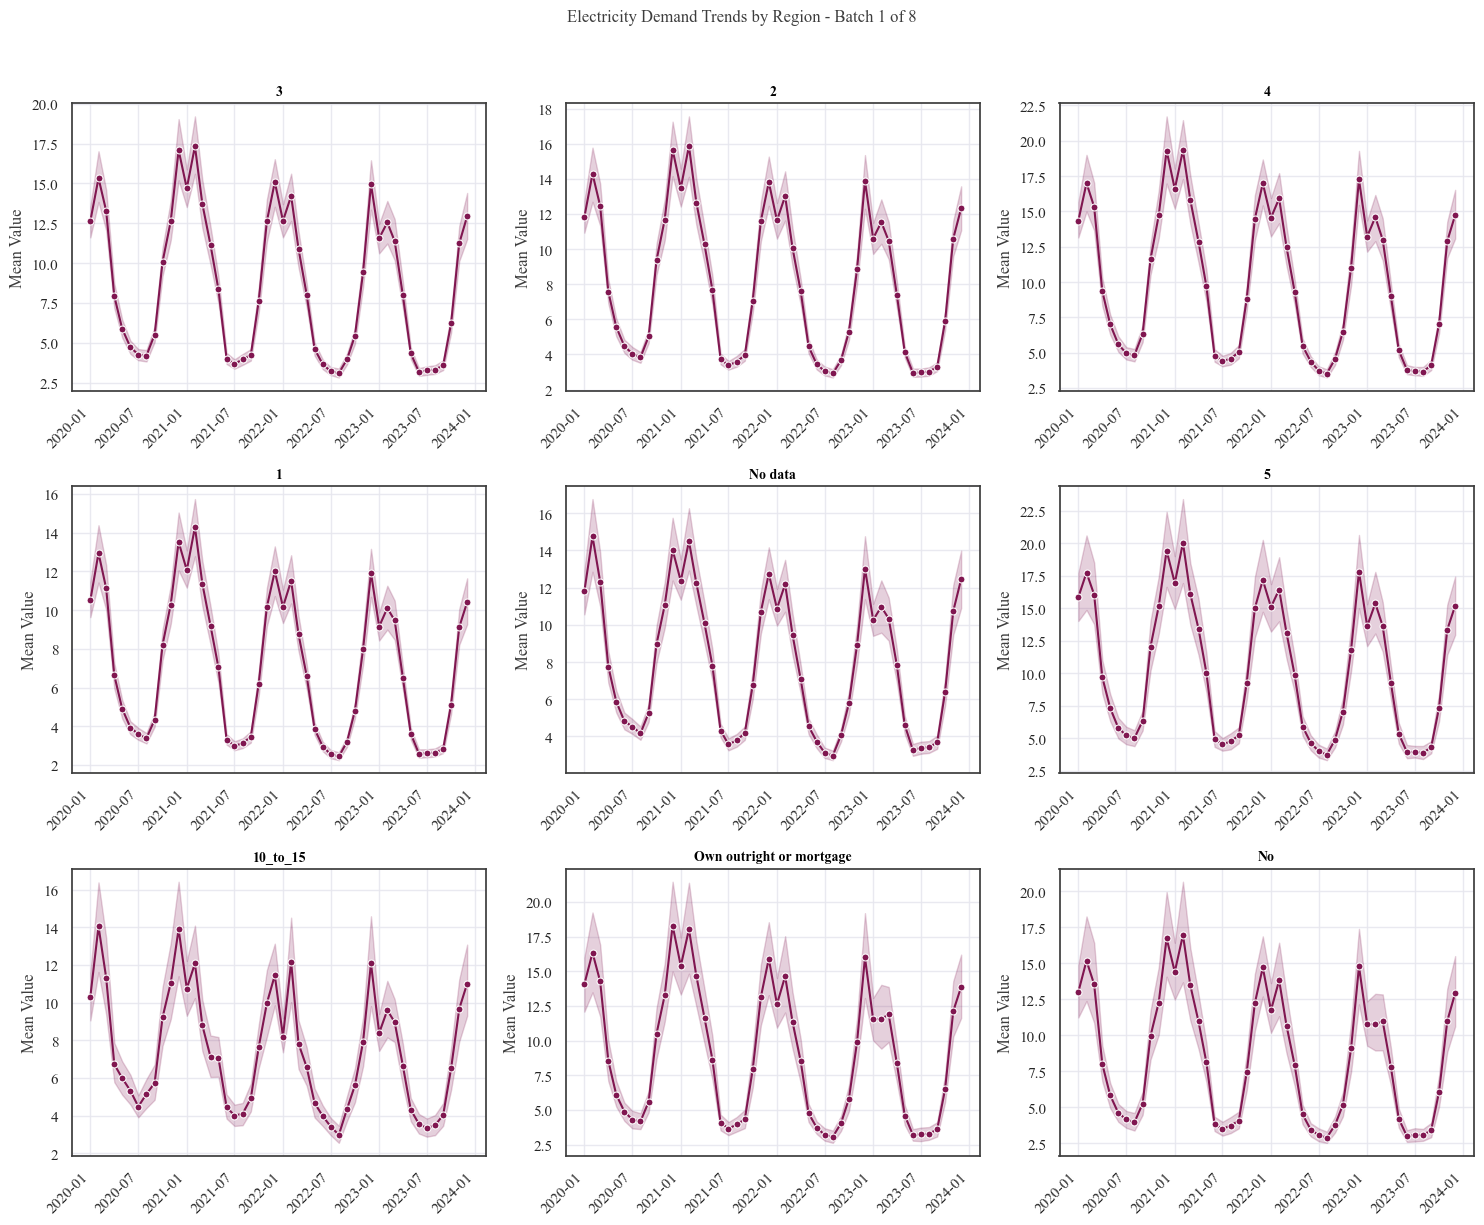

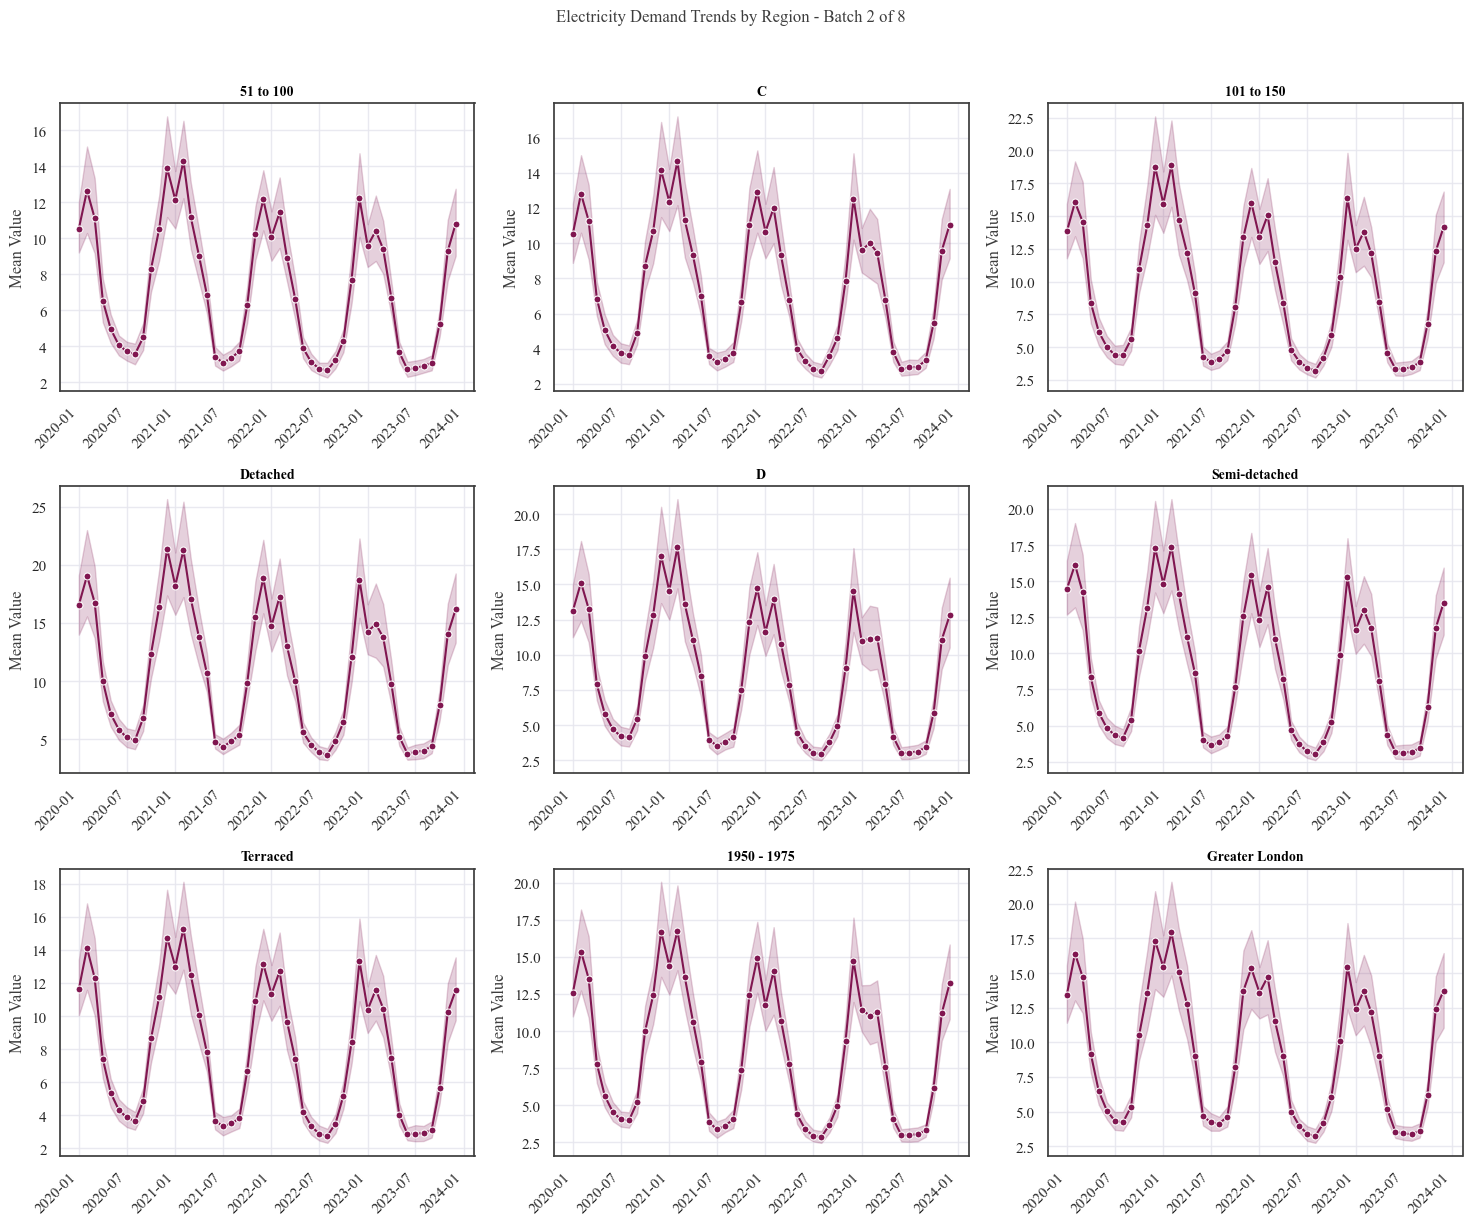

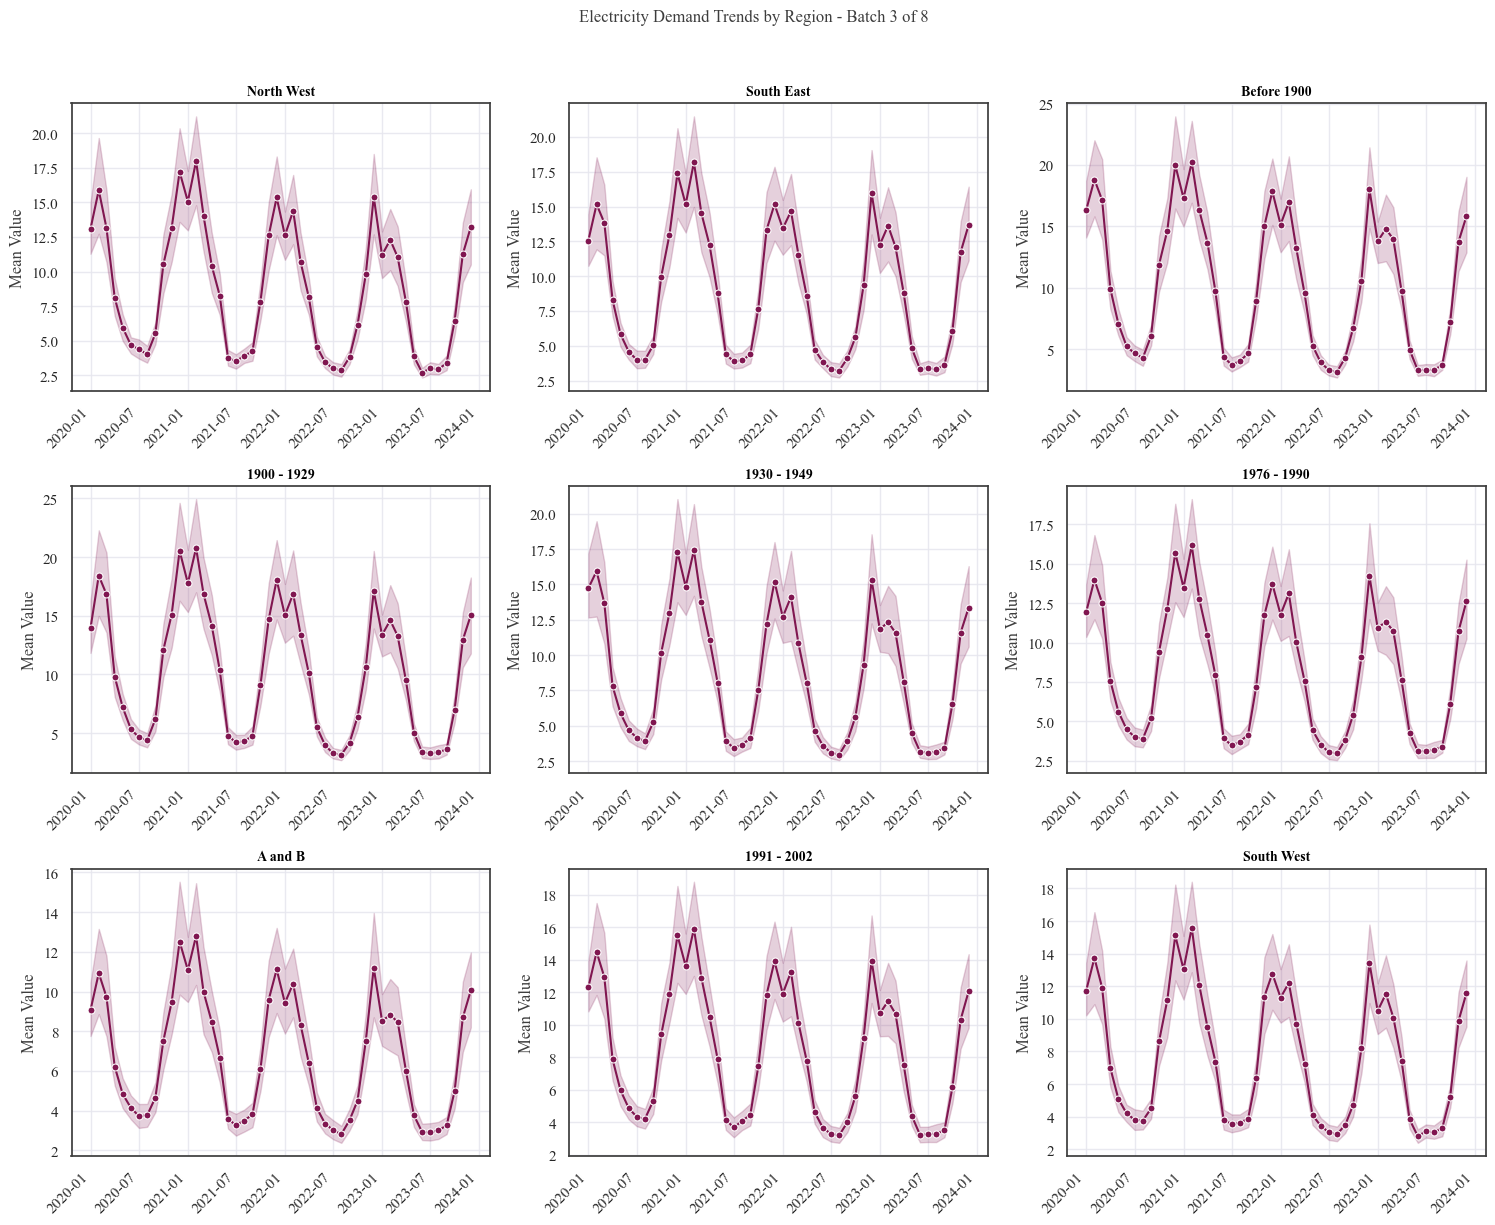

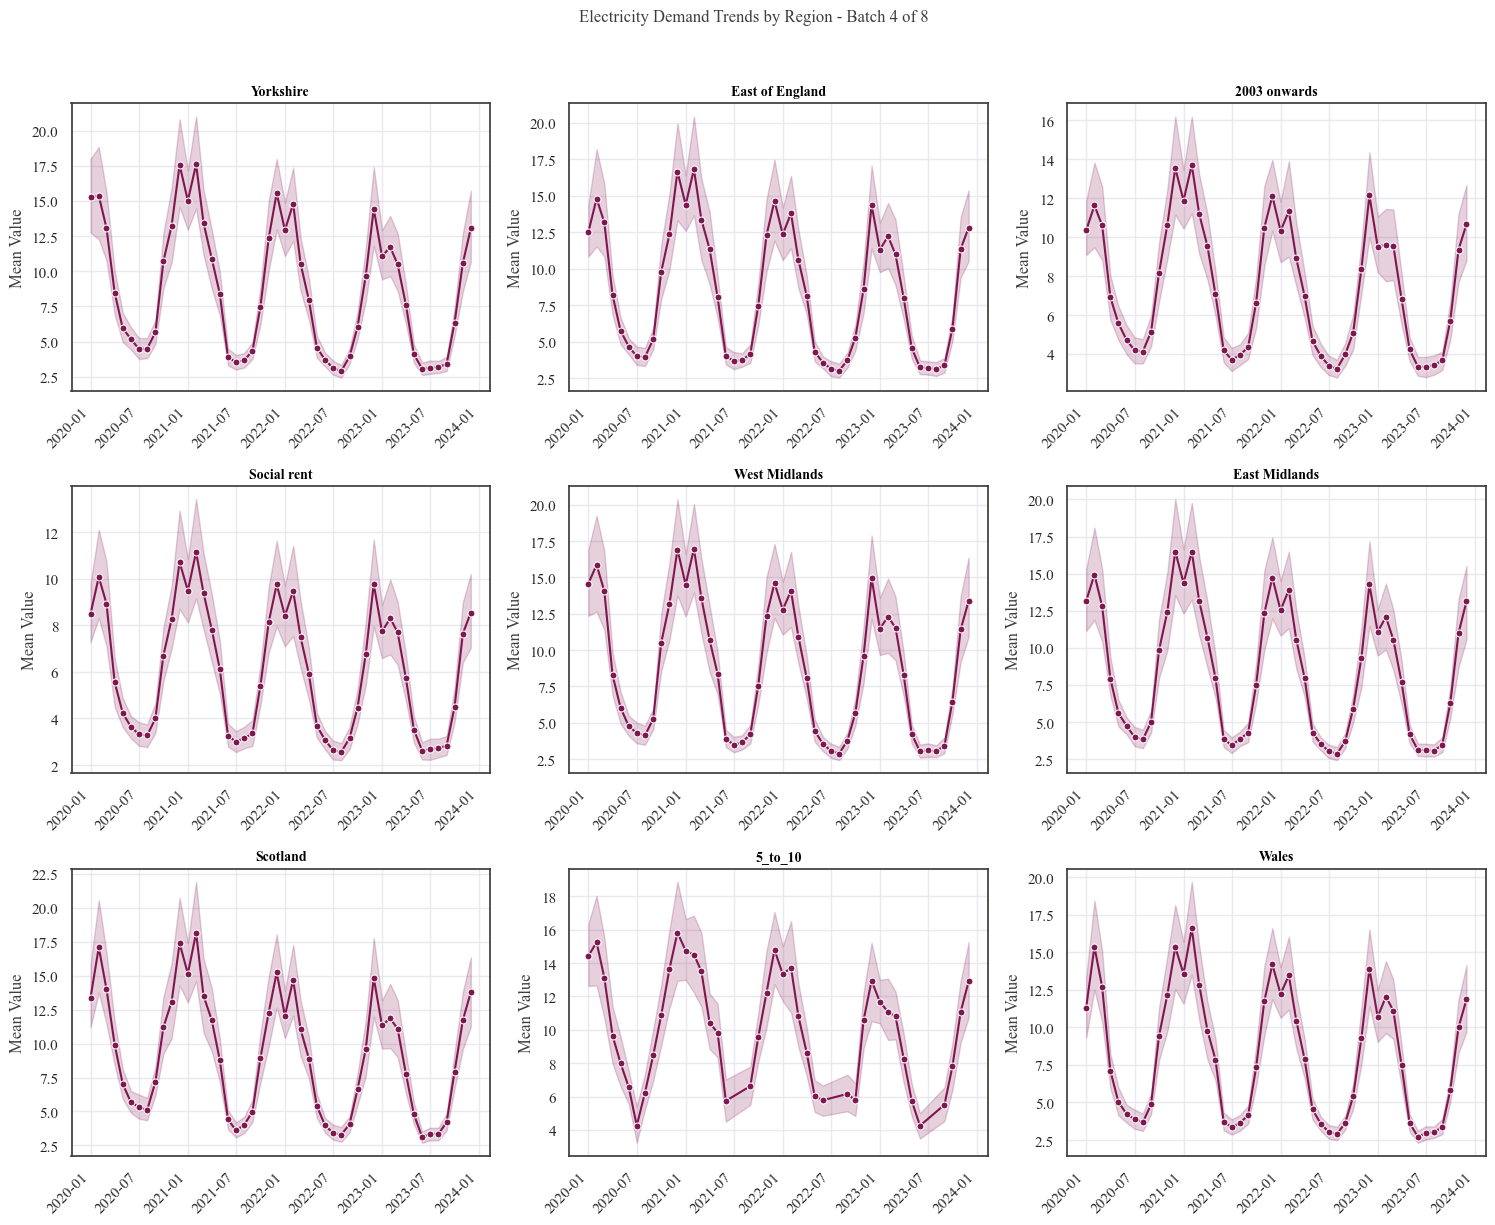

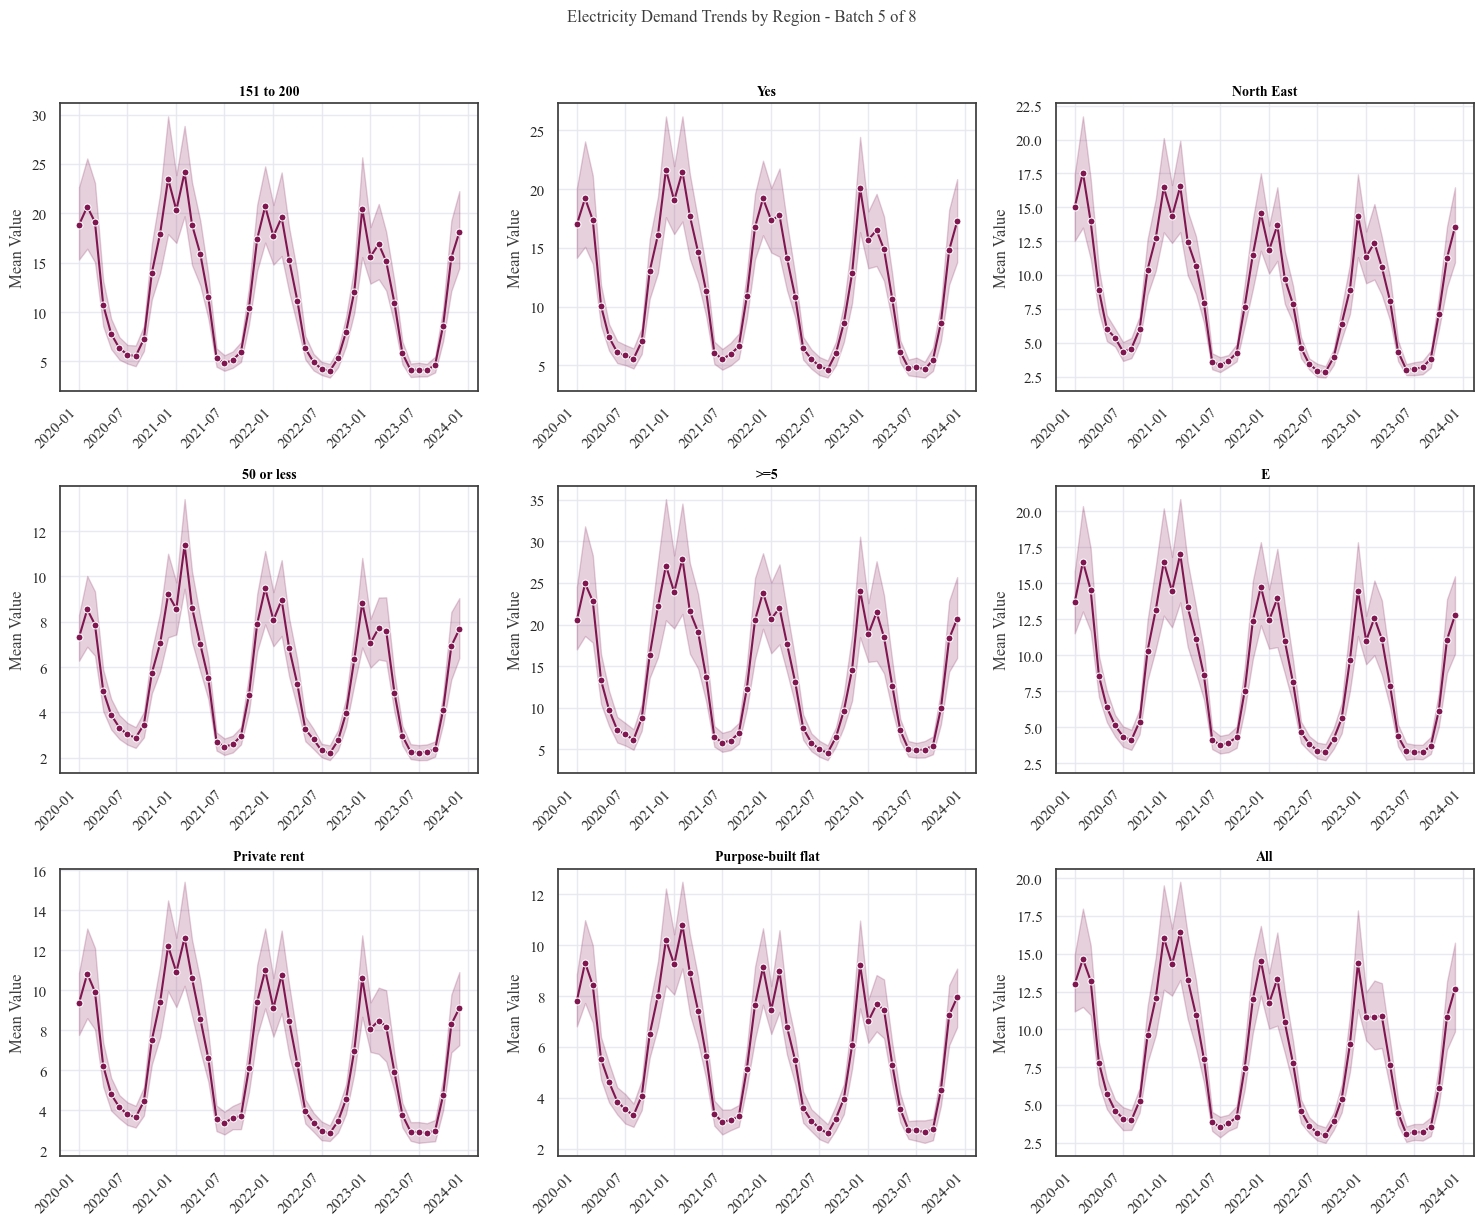

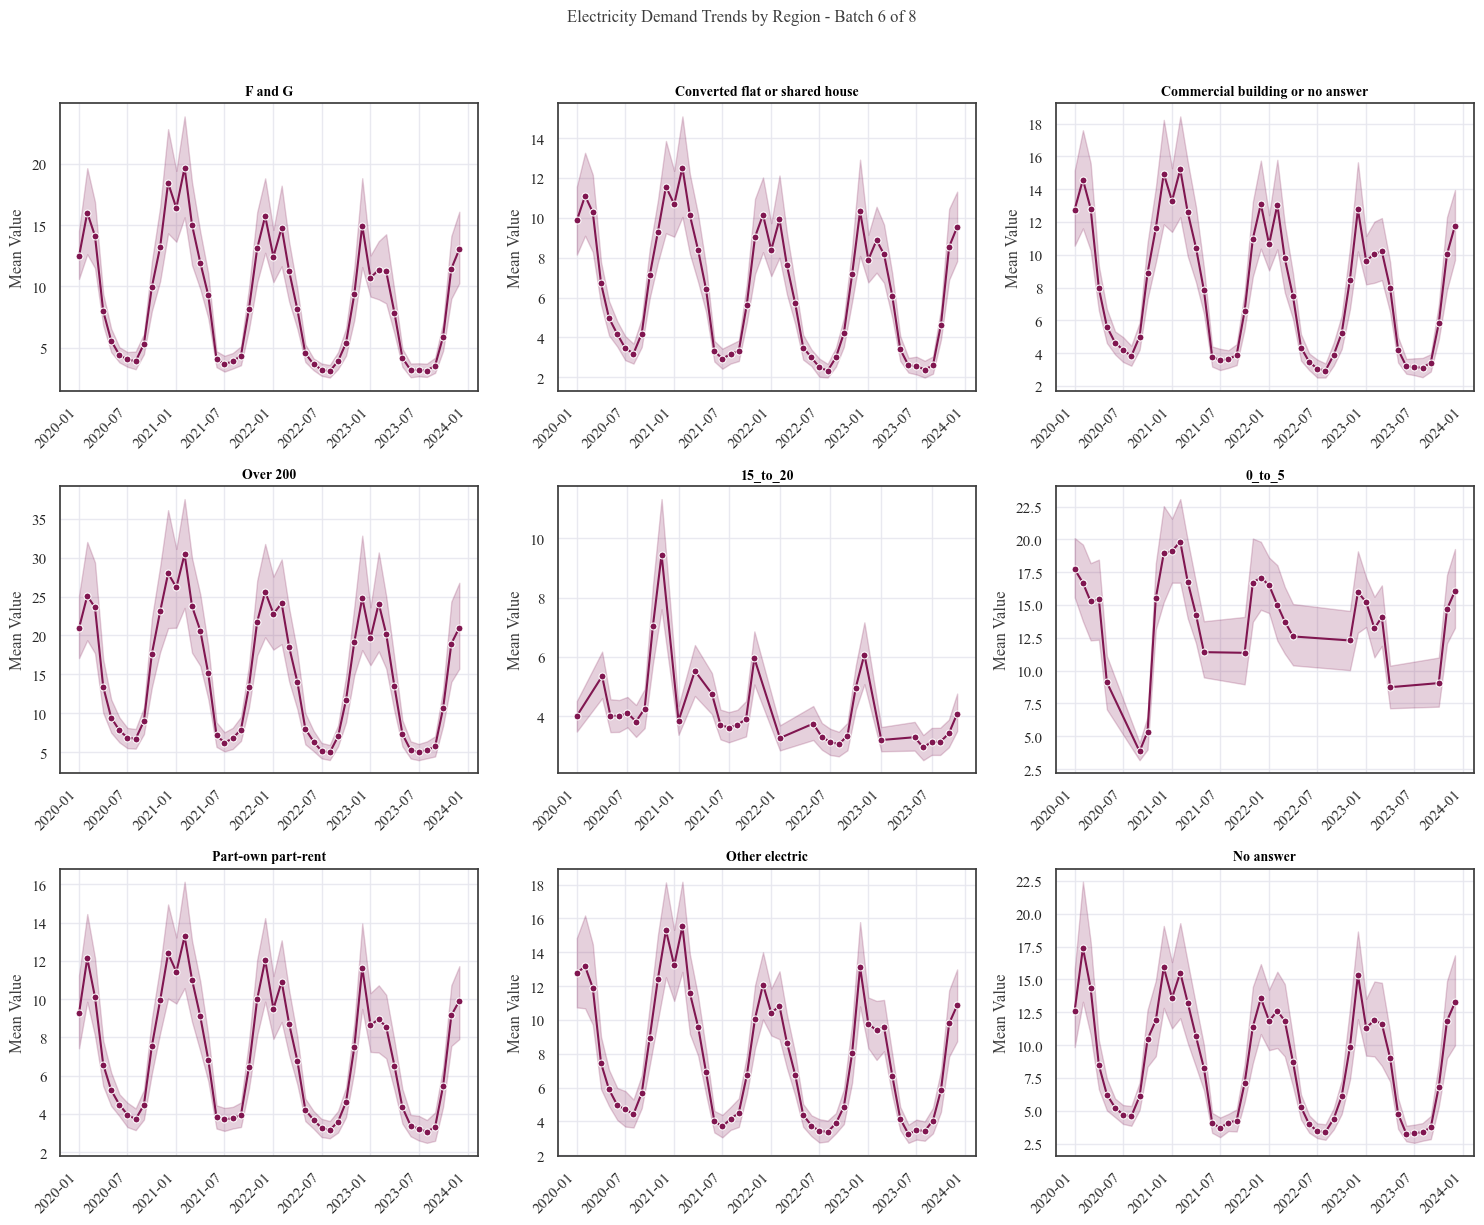

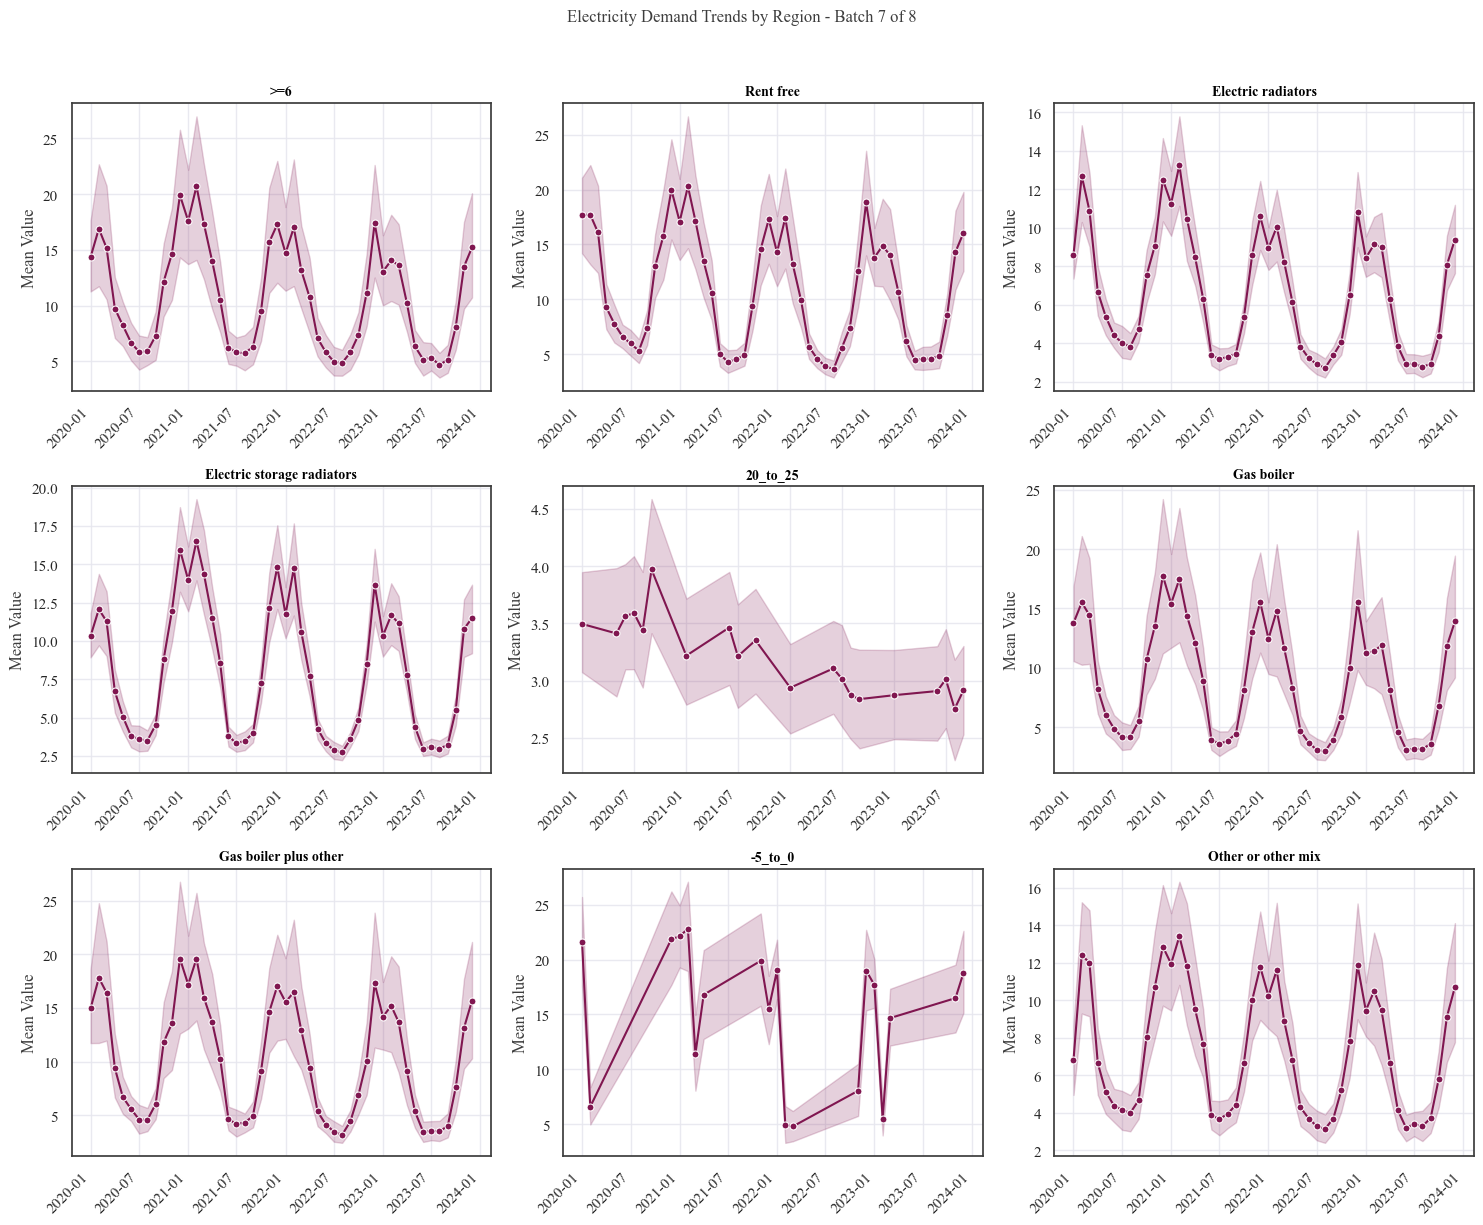

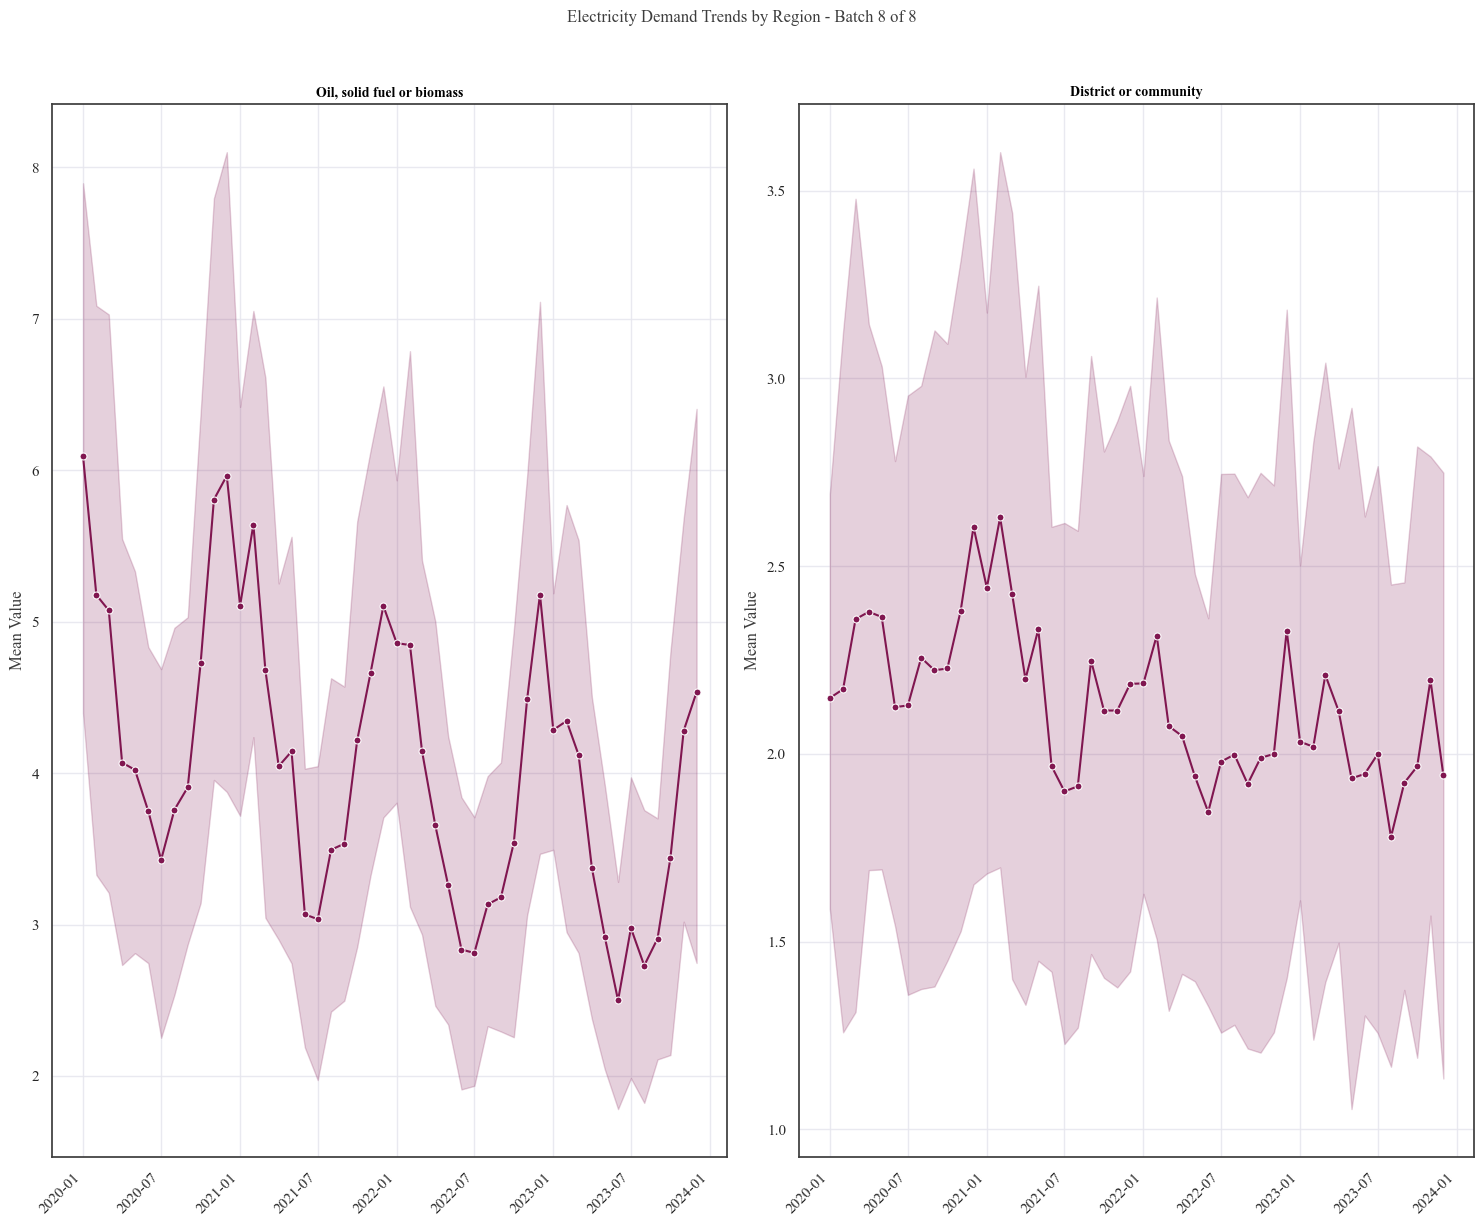

In [18]:
# ████████████████████████████████  TARGET TRENDS BY REGION (STATIC) ████████████████████████████████
# ╔════════════════════════════╗
# ║ STATIC PLOTTER             ║
# ╚════════════════════════════╝

@dataclass
class StaticTrendsConfig:
    """Config for static regional trend visualization"""
    max_regions: int = 12                 # limit regions per figure
    regions_per_row: int = 3              # subplots per row
    figsize: tuple = (15, 10)             # figure size (width, height)
    smoothing_window: Optional[int] = 3    # e.g., 3-month moving average
    include_regions: Optional[List[str]] = None  # explicit subset
    line_width: int = 1
    marker_size: int = 4
    title: str = "Target Trends by Region"
    dpi: int = 100                        # resolution for saved figures
    save_path: Optional[str] = None        # e.g., "regional_trends.png"

def plot_target_trends_static(
    df: pd.DataFrame,
    cfg: StaticTrendsConfig = StaticTrendsConfig()
) -> List[plt.Figure]:
    """
    Generate static matplotlib figures showing trends by region
    
    Parameters:
    -----------
    df : pd.DataFrame
        Must contain columns: ['segment_3_value', 'aggregation_period', 'mean']
    cfg : StaticTrendsConfig
        Configuration for the visualization
        
    Returns:
    --------
    List of matplotlib Figure objects
    """
    # ─── Data Preparation ──────────────────────────────────────────────────
    required_cols = {'segment_3_value', 'aggregation_period', 'mean'}
    missing = required_cols - set(df.columns)
    if missing:
        raise KeyError(f"Missing required columns: {sorted(missing)}")
    
    data = df.dropna(subset=list(required_cols)).copy()
    
    # Parse dates safely
    data['date'] = _parse_period_safe(data['aggregation_period'])
    data = data.dropna(subset=['date'])
    
    # Filter regions if specified
    if cfg.include_regions:
        data = data[data['segment_3_value'].isin(cfg.include_regions)]
    
    # Get regions ordered by data volume
    region_counts = (
        data.groupby('segment_3_value')['mean']
        .size()
        .sort_values(ascending=False)
    )
    regions = region_counts.index.tolist()
    if not regions:
        raise ValueError("No regions found after filtering.")
    
    # Apply smoothing if requested
    if cfg.smoothing_window and cfg.smoothing_window > 1:
        data['mean_smoothed'] = (
            data.sort_values(['segment_3_value', 'date'])
            .groupby('segment_3_value', group_keys=False)['mean']
            .apply(lambda s: _moving_average(s, cfg.smoothing_window)))
        y_col = 'mean_smoothed'
    else:
        y_col = 'mean'
    
    # ─── Plot Generation ───────────────────────────────────────────────────
    figures = []
    region_batches = _paginate(regions, cfg.max_regions)
    
    for batch_idx, batch_regions in enumerate(region_batches, 1):
        batch_data = data[data['segment_3_value'].isin(batch_regions)]
        
        # Determine grid layout
        n_regions = len(batch_regions)
        n_cols = min(cfg.regions_per_row, n_regions)
        n_rows = int(np.ceil(n_regions / n_cols))
        
        # Create figure with appropriate size
        fig, axes = plt.subplots(
            n_rows, n_cols,
            figsize=cfg.figsize,
            squeeze=False,
            sharex=False,
            sharey=False
        )
        axes = axes.flatten()
        
        # Plot each region
        for idx, (region, ax) in enumerate(zip(batch_regions, axes)):
            region_data = batch_data[batch_data['segment_3_value'] == region]
            
            sns.lineplot(
                data=region_data,
                x='date',
                y=y_col,
                ax=ax,
                linewidth=cfg.line_width,
                marker='o',
                markersize=cfg.marker_size
            )
            
            ax.set_title(region, fontsize=10)
            ax.set_xlabel('')
            ax.set_ylabel('Mean Value')
            
            # Rotate x-axis labels
            for label in ax.get_xticklabels():
                label.set_rotation(45)
                label.set_ha('right')
        
        # Hide empty subplots
        for ax in axes[n_regions:]:
            ax.set_visible(False)
        
        # Add overall title and adjust layout
        fig.suptitle(
            f"{cfg.title} - Batch {batch_idx} of {len(region_batches)}",
            y=1.02,
            fontsize=12
        )
        fig.tight_layout()
        
        # Save if requested
        if cfg.save_path and batch_idx == 1:
            save_path = cfg.save_path
            if len(region_batches) > 1:
                base, ext = os.path.splitext(cfg.save_path)
                save_path = f"{base}_batch{batch_idx}{ext}"
            fig.savefig(save_path, dpi=cfg.dpi, bbox_inches='tight')
        
        figures.append(fig)
    
    return figures

# Reuse these helper functions from your original code
def _parse_period_safe(s: pd.Series) -> pd.Series:
    s = s.astype(str).str.strip()
    is_year = s.str.fullmatch(r"\d{4}")

    out = pd.Series(pd.NaT, index=s.index, dtype="datetime64[ns]")
    out.loc[is_year] = pd.to_datetime(s.loc[is_year] + "-01-01", errors="coerce")
    out.loc[~is_year] = pd.to_datetime(s.loc[~is_year], errors="coerce")
    return out.dt.to_period("M").dt.start_time

def _moving_average(x: pd.Series, window: int) -> pd.Series:
    if not window or window <= 1:
        return x
    return x.rolling(window=window, min_periods=max(1, window // 2), center=True).mean()

def _paginate(seq: List[str], n: int) -> List[List[str]]:
    return [seq[i:i + n] for i in range(0, len(seq), n)]

# ╔════════════════════════════╗
# ║ EXAMPLE USAGE               ║
# ╚════════════════════════════╝
if __name__ == "__main__":
    # Load data if not already available
    try:
        df  # noqa: F821
    except NameError:
        df = pd.read_csv("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/code/forcasting.csv")
    
    # Configuration
    config = StaticTrendsConfig(
        max_regions=9,                   # 9 regions per figure
        regions_per_row=3,               # 3 columns
        figsize=(15, 12),                # Figure size (width, height)
        smoothing_window=3,              # 3-month moving average
        include_regions=None,            # Or specify regions: ["Greater London", "Scotland"]
        line_width=1.5,
        marker_size=5,
        title="Electricity Demand Trends by Region",
        save_path="regional_trends.png"  # Save first batch
    )
    
    # Generate plots
    figures = plot_target_trends_static(df, config)
    
    # Display all figures (will show in VS Code)
    plt.show()

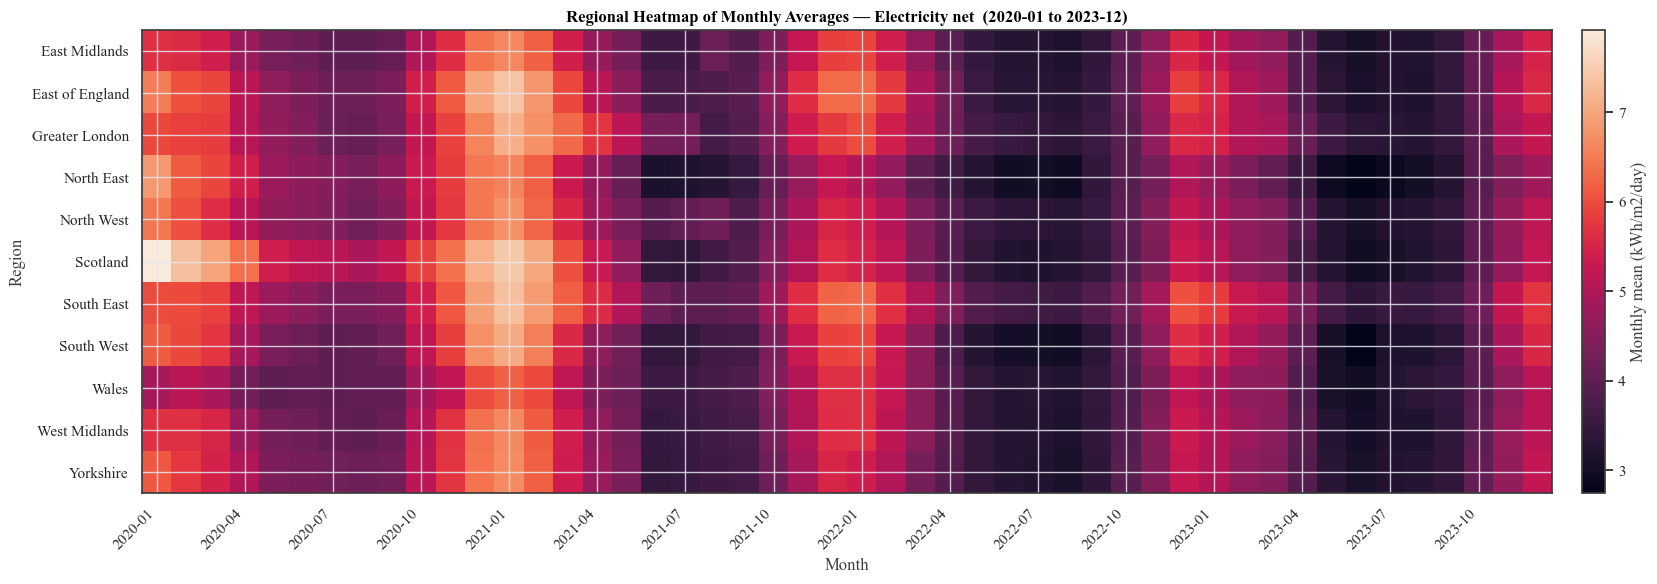

In [19]:
# ████████████████████████████████  REGIONAL MONTHLY HEATMAP  ████████████████████████████████
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝

# NOTE: Keep defaults broad to reflect "baseline context".
DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"

# TODO: Consider parameterizing label stride to adapt for very wide timelines.


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ DATA CLASS                                                               ║
# ╚══════════════════════════════════════════════════════════════════════════╝

@dataclass
class HeatmapConfig:
    """Configuration for the regional monthly heatmap."""
    quantity: str = DEFAULT_QUANTITY
    weekpart: str = DEFAULT_WEEKPART
    fuel: str = DEFAULT_FUEL
    has_pv: str = DEFAULT_PV
    # If provided, restrict to these regions (exact match on segment_3_value)
    include_regions: Optional[List[str]] = None


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ PLOTTING LOGIC                                                           ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class RegionalMonthlyHeatmap:
    """Prepare and render a monthly regional heatmap from a long-form dataset."""

    def __init__(self, data: pd.DataFrame, config: HeatmapConfig) -> None:
        self.data = data.copy()
        self.config = config
        self.pivot: Optional[pd.DataFrame] = None
        self.unit: Optional[str] = None
        self.date_range: Optional[Tuple[pd.Timestamp, pd.Timestamp]] = None

    # --------------------------------------------------------------------- #
    # Step 1: Prepare monthly pivot table: index=region, columns=month       #
    # --------------------------------------------------------------------- #
    def prepare(self) -> "RegionalMonthlyHeatmap":
        """Filter, transform, and pivot the dataset for heatmap plotting."""
        # Validate required columns early to fail fast
        required = {
            "segmentation_variable_3", "segment_3_value", "aggregation_period",
            "quantity", "weekday_weekend", "primary_space_heating_fuel",
            "has_PV", "mean", "unit",
        }
        missing = required - set(self.data.columns)
        if missing:
            raise KeyError(
                f"Missing required columns: {sorted(missing)}"
            )

        # Filter for region segmentation
        df = self.data[self.data["segmentation_variable_3"] == "region"].copy()

        # Apply baseline filters for a broad context slice
        df = df[
            (df["quantity"] == self.config.quantity)
            & (df["weekday_weekend"] == self.config.weekpart)
            & (df["primary_space_heating_fuel"] == self.config.fuel)
            & (df["has_PV"] == self.config.has_pv)
        ].copy()

        # Optionally restrict to a specific set of regions
        if self.config.include_regions:
            df = df[df["segment_3_value"].isin(self.config.include_regions)]

        if df.empty:
            raise ValueError(
                "No data after applying filters. Try relaxing the filters "
                "or choose a different quantity."
            )

        # Keep only monthly records: look for 'YYYY-MM' tokens
        # HACK: This avoids interpreting annual 'YYYY' as January of that year.
        period_str = df["aggregation_period"].astype(str)
        monthly_mask = period_str.str.len() >= 7  # crude but robust gate
        df = df[monthly_mask].copy()

        # Parse to datetime with strict monthly format
        df["month"] = pd.to_datetime(
            df["aggregation_period"], format="%Y-%m", errors="coerce"
        )
        df = df.dropna(subset=["month"])

        # Track unit for colorbar labeling (should be consistent post-filter)
        unit_candidates = df["unit"].dropna().unique().tolist()
        self.unit = unit_candidates[0] if unit_candidates else None

        # Aggregate: mean of 'mean' by region/month (handles duplicates safely)
        grouped = (
            df.groupby(["segment_3_value", "month"], as_index=False)["mean"]
            .mean()
        )

        # Pivot to matrix form: rows=regions, cols=months
        pivot = grouped.pivot(
            index="segment_3_value", columns="month", values="mean"
        )

        # Sort for readability
        pivot = pivot.sort_index()
        pivot = pivot.reindex(sorted(pivot.columns), axis=1)

        self.pivot = pivot
        if not pivot.columns.empty:
            self.date_range = (pivot.columns.min(), pivot.columns.max())
        return self

    # --------------------------------------------------------------------- #
    # Step 2: Render heatmap with matplotlib (no seaborn, no manual colors) #
    # --------------------------------------------------------------------- #
    def plot(self) -> None:
        """Render the heatmap using matplotlib."""
        if self.pivot is None or self.pivot.empty:
            raise ValueError("Call .prepare() before .plot(); pivot is empty.")

        # Convert to numpy and mask NaNs for nicer rendering
        matrix = self.pivot.to_numpy(dtype=float)
        masked = np.ma.masked_invalid(matrix)

        # Dynamically size the figure based on data shape
        n_regions, n_months = masked.shape
        width = min(20, max(8, n_months * 0.35))   # scale with months
        height = min(18, max(6, n_regions * 0.35))  # scale with regions

        fig, ax = plt.subplots(figsize=(width, height))

        # NOTE: Colormap not explicitly set per instruction (use default).
        im = ax.imshow(masked, aspect="auto", interpolation="nearest")

        # Axis labels and ticks
        ax.set_ylabel("Region")
        ax.set_xlabel("Month")

        # Y-ticks: every region
        ax.set_yticks(np.arange(n_regions))
        ax.set_yticklabels(self.pivot.index.tolist())

        # X-ticks: subsample for readability
        col_labels = [c.strftime("%Y-%m") for c in self.pivot.columns]
        max_labels = 18  # cap labels to avoid clutter
        step = max(1, math.ceil(len(col_labels) / max_labels))
        x_positions = np.arange(0, n_months, step)
        x_labels = [col_labels[i] for i in x_positions]

        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels, rotation=45, ha="right")

        # Colorbar with unit if available
        cbar_label = (
            f"Monthly mean ({self.unit})"
            if self.unit
            else "Monthly mean"
        )
        fig.colorbar(im, ax=ax, fraction=0.035, pad=0.02, label=cbar_label)

        # Title with quantity and date range
        if self.date_range:
            start, end = self.date_range
            title_range = f"{start.strftime('%Y-%m')} to {end.strftime('%Y-%m')}"
        else:
            title_range = ""

        ax.set_title(
            f"Regional Heatmap of Monthly Averages — {self.config.quantity}"
            f"{'  (' + title_range + ')' if title_range else ''}"
        )

        plt.tight_layout()
        plt.show()


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ EXECUTION                                                                ║
# ╚══════════════════════════════════════════════════════════════════════════╝

# Validate that df is present in kernel (loaded in earlier cells)
if "df" not in globals():
    # Load if needed (idempotent for repeated runs)
    df = pd.read_csv("/mnt/data/forcasting.csv")

# Instantiate, prepare, and plot
config = HeatmapConfig(
    quantity=DEFAULT_QUANTITY,
    weekpart=DEFAULT_WEEKPART,
    fuel=DEFAULT_FUEL,
    has_pv=DEFAULT_PV,
    include_regions=None,  # e.g., ["Greater London", "Scotland"]
)

heatmap = RegionalMonthlyHeatmap(data=df, config=config)
heatmap.prepare().plot()

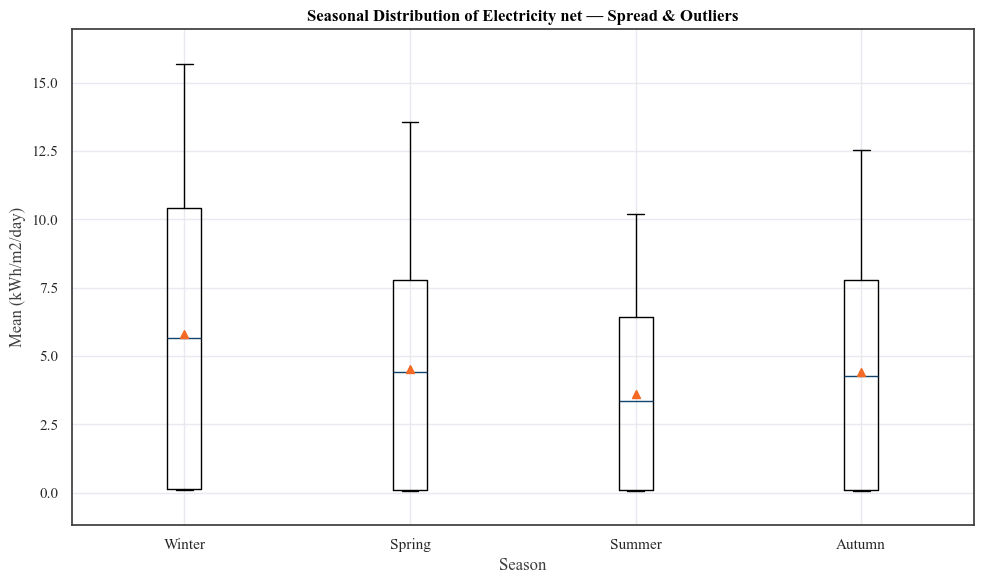

In [20]:
# ████████████████████████████████  SEASONAL DISTRIBUTION OF MEAN VALUES  ████████████████████████████████

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ IMPORTS + CONFIG                                                         ║
# ╚══════════════════════════════════════════════════════════════════════════╝


DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"
SEASON_ORDER = ["Winter", "Spring", "Summer", "Autumn"]
REGION_FILTER = None  # set to a region name to narrow the slice

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ DATA SLICE + SEASON MAPPING                                              ║
# ╚══════════════════════════════════════════════════════════════════════════╝
base = df[
    (df["quantity"] == DEFAULT_QUANTITY)
    & (df["segmentation_variable_3"] == "region")
    & (df["weekday_weekend"] == DEFAULT_WEEKPART)
    & (df["primary_space_heating_fuel"] == DEFAULT_FUEL)
    & (df["has_PV"] == DEFAULT_PV)
].copy()

if REGION_FILTER:
    base = base[base["segment_3_value"] == REGION_FILTER].copy()

# Restrict to true monthly observations (avoid 'YYYY' ambiguity)
base["aggregation_period"] = base["aggregation_period"].astype(str)
monthly = base[base["aggregation_period"].str.contains("-")].copy()

monthly["parsed_date"] = pd.to_datetime(monthly["aggregation_period"], errors="coerce")
monthly = monthly.dropna(subset=["parsed_date"])
monthly["month"] = monthly["parsed_date"].dt.month

def month_to_season(m: int) -> str:
    if m in (12, 1, 2): return "Winter"
    if m in (3, 4, 5):  return "Spring"
    if m in (6, 7, 8):  return "Summer"
    if m in (9, 10, 11): return "Autumn"
    return "Unknown"

monthly["season"] = monthly["month"].apply(month_to_season)
monthly["mean"] = pd.to_numeric(monthly["mean"], errors="coerce")
monthly = monthly.dropna(subset=["mean"])

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ PLOT — FORCE ALL SEASONS                                                 ║
# ╚══════════════════════════════════════════════════════════════════════════╝
values_by_season = {s: monthly.loc[monthly["season"] == s, "mean"].to_numpy()
                    for s in SEASON_ORDER}

# Y-range for placeholders, based on available data
if any(v.size > 0 for v in values_by_season.values()):
    all_vals = np.concatenate([v for v in values_by_season.values() if v.size > 0])
    y_min, y_max = float(np.nanmin(all_vals)), float(np.nanmax(all_vals))
    pad = 0.08 * (y_max - y_min) if y_max > y_min else 1.0
else:
    y_min, y_max, pad = 0.0, 1.0, 0.2  # extreme fallback (shouldn't happen)

fig, ax = plt.subplots(figsize=(10, 6))
positions = range(1, len(SEASON_ORDER) + 1)

for pos, season in zip(positions, SEASON_ORDER):
    vals = values_by_season[season]
    if vals.size > 0:
        ax.boxplot(vals, positions=[pos], showmeans=True, whis=1.5, patch_artist=False)
    else:
        rect = Rectangle((pos - 0.3, y_min - pad), 0.6, (y_max - y_min) + 2 * pad,
                         fill=False, hatch="//", linewidth=1.5)
        ax.add_patch(rect)
        ax.text(pos, y_min + 0.5 * (y_max - y_min), "No data",
                ha="center", va="center", fontsize=10)

unit = monthly["unit"].dropna().unique().tolist()
ax.set_xticks(list(positions))
ax.set_xticklabels(SEASON_ORDER)
ax.set_ylabel(f"Mean ({unit[0]})" if unit else "Mean")
ax.set_xlabel("Season")
title_region = f" — {REGION_FILTER}" if REGION_FILTER else ""
ax.set_title(f"Seasonal Distribution of {DEFAULT_QUANTITY}{title_region} — Spread & Outliers")
ax.set_ylim(y_min - pad, y_max + pad)

plt.tight_layout()
plt.show()


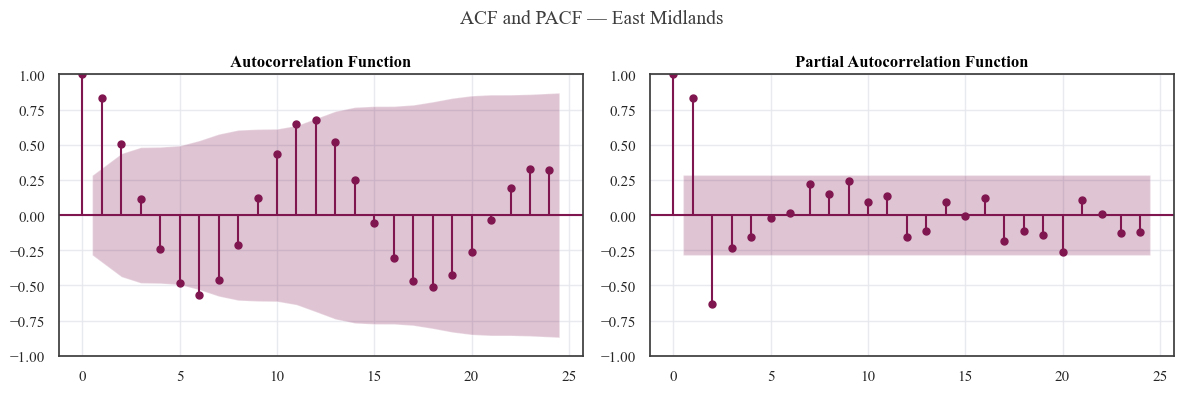

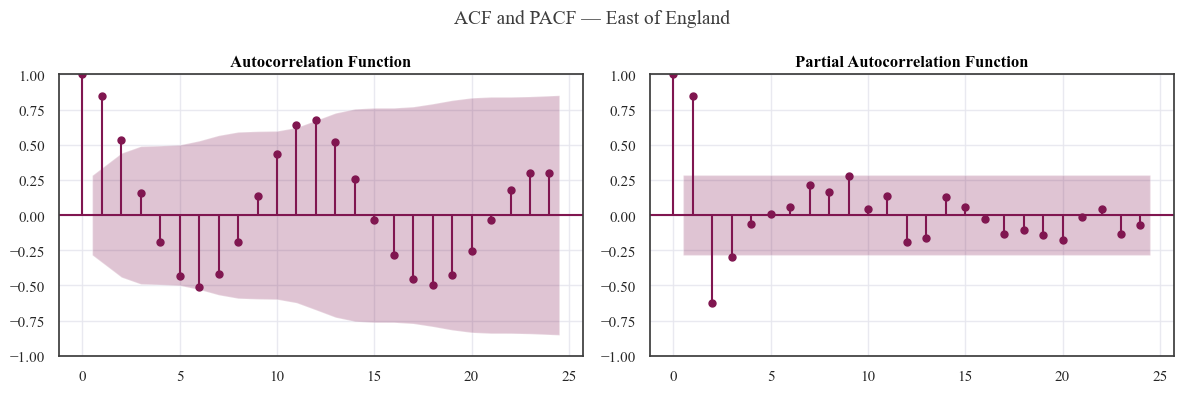

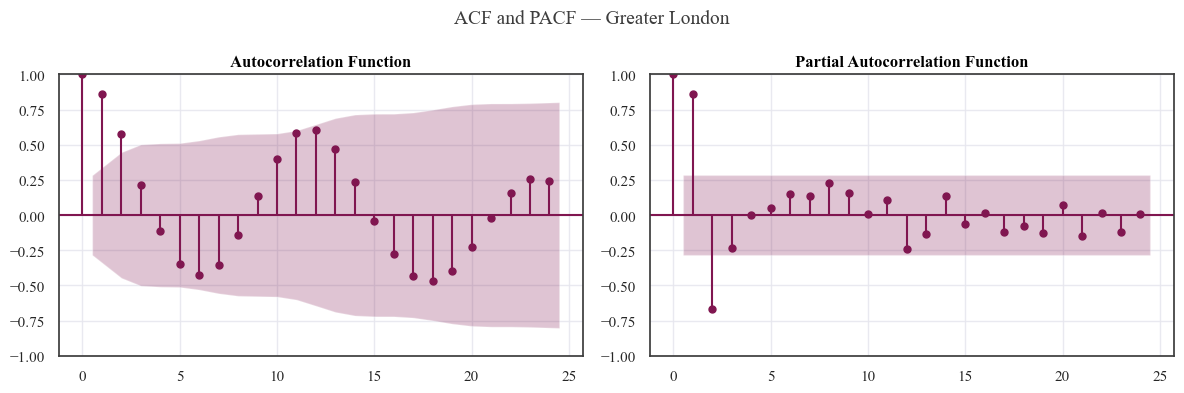

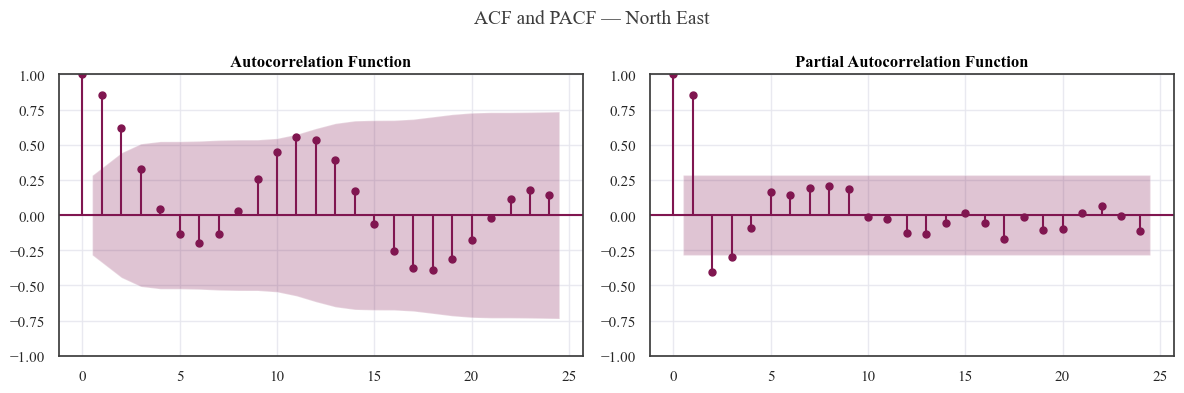

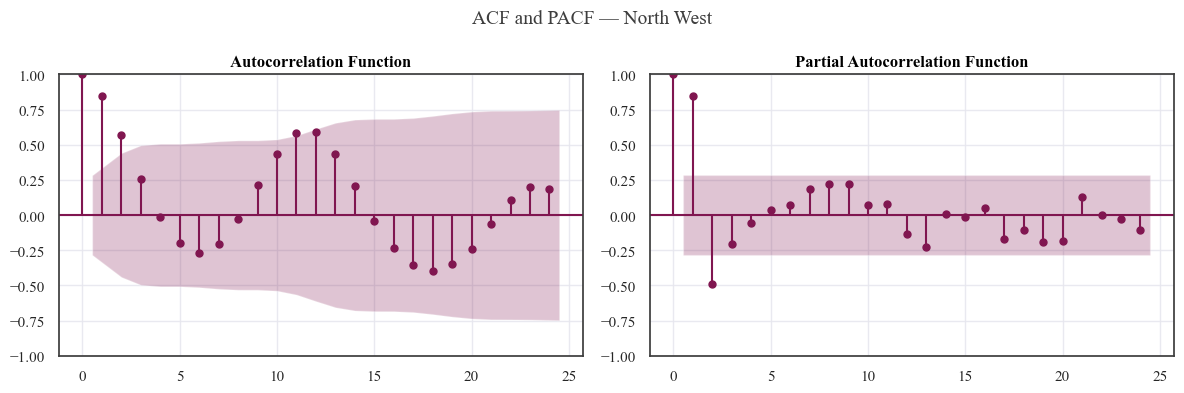

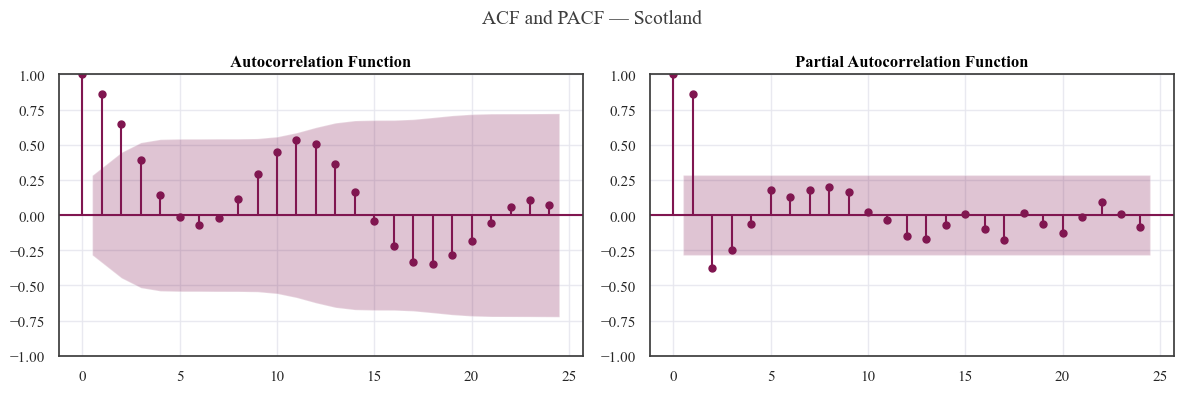

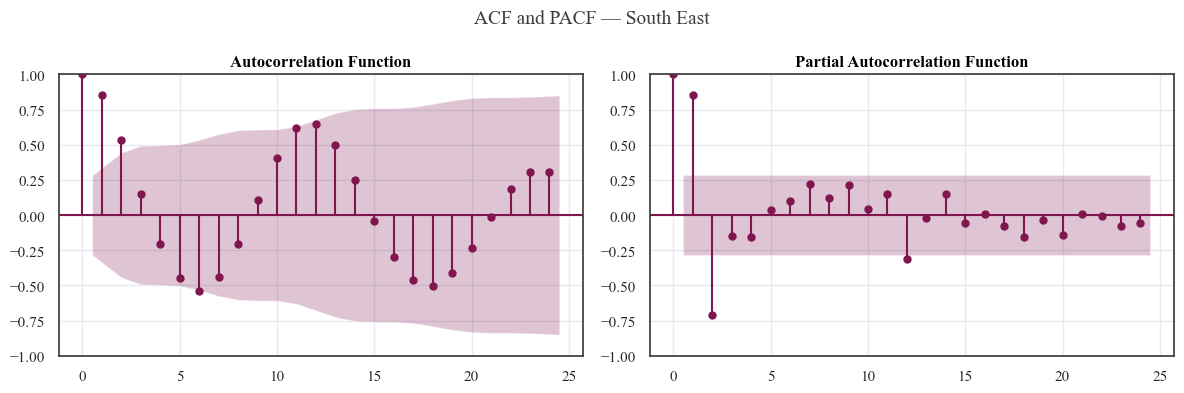

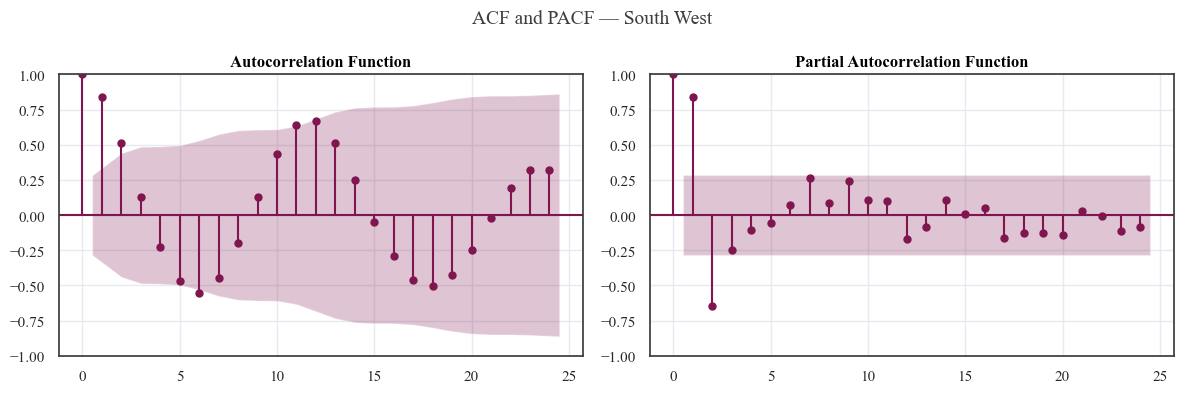

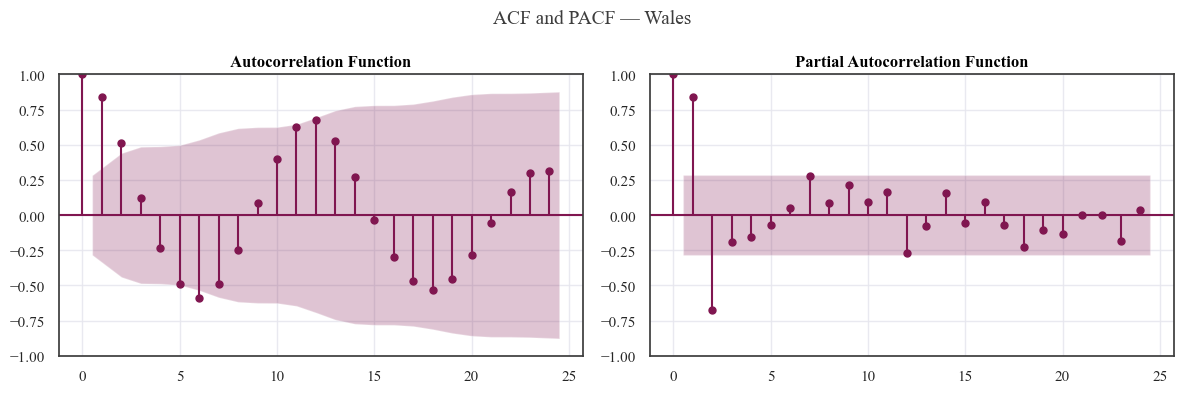

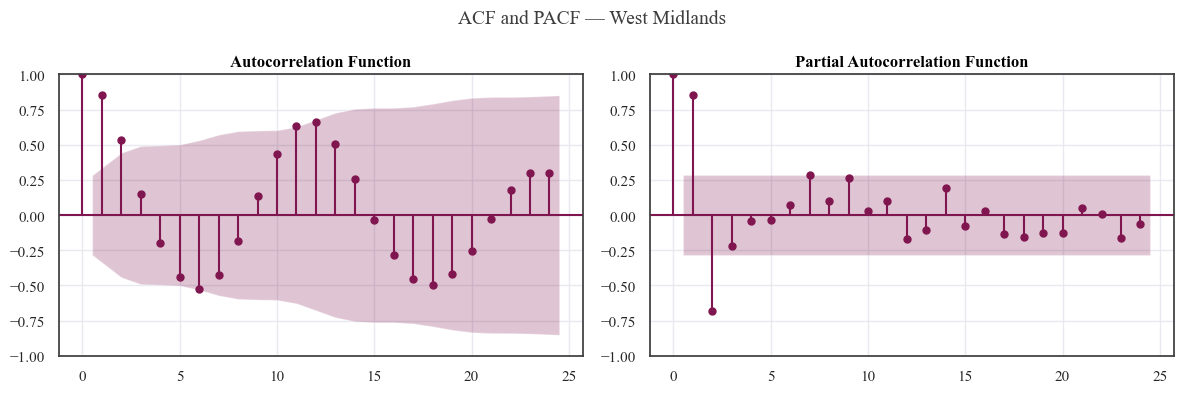

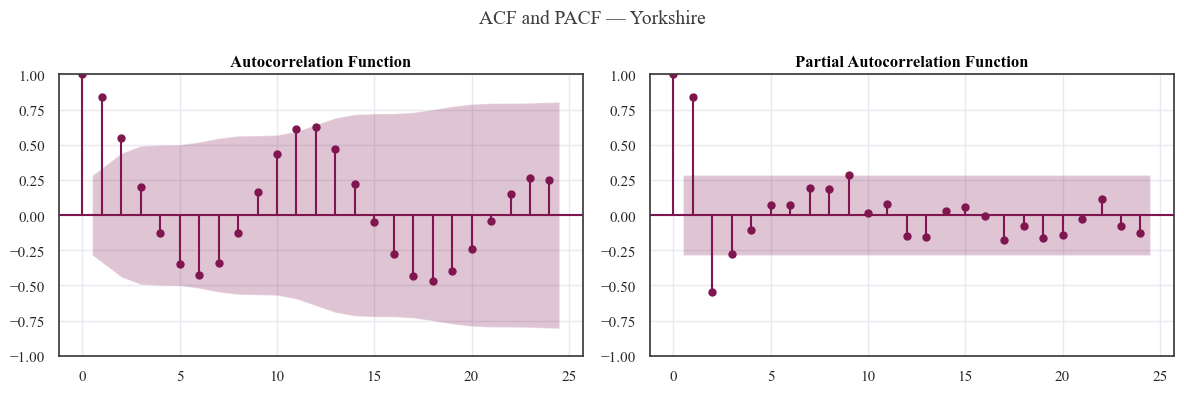

In [21]:
# ████████████████████████████████  ACF/PACF PLOTS BY REGION  ████████████████████████████████

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝

DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"
MAX_LAGS = 24  # months; adjust based on series length

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ DATA PREPARATION                                                         ║
# ╚══════════════════════════════════════════════════════════════════════════╝
try:
    df  # noqa: F821
except NameError:
    df = pd.read_csv("/mnt/data/forcasting.csv")

# Step 1: Filter to baseline slice
df_reg = df[
    (df["segmentation_variable_3"] == "region")
    & (df["quantity"] == DEFAULT_QUANTITY)
    & (df["weekday_weekend"] == DEFAULT_WEEKPART)
    & (df["primary_space_heating_fuel"] == DEFAULT_FUEL)
    & (df["has_PV"] == DEFAULT_PV)
].copy()

# Step 2: Keep only monthly rows (avoid 'YYYY' ambiguity)
df_reg["aggregation_period"] = df_reg["aggregation_period"].astype(str)
df_reg = df_reg[df_reg["aggregation_period"].str.contains("-")].copy()

# Step 3: Parse dates and aggregate to monthly means per region
df_reg["date"] = pd.to_datetime(df_reg["aggregation_period"], errors="coerce")
df_reg = df_reg.dropna(subset=["date"])
df_reg["mean"] = pd.to_numeric(df_reg["mean"], errors="coerce")

monthly_mean = (
    df_reg.groupby(["segment_3_value", "date"], as_index=False)["mean"]
    .mean()
    .sort_values(["segment_3_value", "date"])
)

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ PLOTTING ACF/PACF                                                         ║
# ╚══════════════════════════════════════════════════════════════════════════╝
regions = monthly_mean["segment_3_value"].unique()

for region in regions:
    series = (
        monthly_mean.loc[monthly_mean["segment_3_value"] == region, "mean"]
        .dropna()
    )

    # Skip regions with too few observations
    if len(series) < 10:
        print(f"Skipping {region} (only {len(series)} points).")
        continue

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(f"ACF and PACF — {region}", fontsize=14)

    # ACF
    plot_acf(series, lags=MAX_LAGS, ax=axes[0])
    axes[0].set_title("Autocorrelation Function")

    # PACF
    plot_pacf(series, lags=MAX_LAGS, ax=axes[1], method="ywm")
    axes[1].set_title("Partial Autocorrelation Function")

    plt.tight_layout()
    plt.show()


In [22]:
# ████████████████████████████████  ACF/PACF PLOTS BY REGION  ████████████████████████████████
# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝
DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ LOAD + BASELINE SLICE                                                    ║
# ╚══════════════════════════════════════════════════════════════════════════╝

df_reg = df[
    (df["segmentation_variable_3"] == "region")
    & (df["quantity"] == DEFAULT_QUANTITY)
    & (df["weekday_weekend"] == DEFAULT_WEEKPART)
    & (df["primary_space_heating_fuel"] == DEFAULT_FUEL)
    & (df["has_PV"] == DEFAULT_PV)
].copy()

# Keep only monthly rows for consistency
df_reg["aggregation_period"] = df_reg["aggregation_period"].astype(str)
df_reg = df_reg[df_reg["aggregation_period"].str.contains("-")].copy()

# Ensure numeric mean
df_reg["mean"] = pd.to_numeric(df_reg["mean"], errors="coerce")
df_reg = df_reg.dropna(subset=["mean"])

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ DESCRIPTIVE STATS                                                        ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# Step 1: Per-region descriptive stats
region_stats = (
    df_reg.groupby("segment_3_value")["mean"]
    .describe()
    .rename_axis(index="Region")
    .reset_index()
)

# Step 2: Overall stats across all regions
overall_stats = df_reg["mean"].describe().to_frame().T
overall_stats.insert(0, "Region", "Overall")

# Step 3: Combine for reporting
stats_combined = pd.concat([region_stats, overall_stats], ignore_index=True)

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ DISPLAY                                                                  ║
# ╚══════════════════════════════════════════════════════════════════════════╝
pd.set_option("display.float_format", "{:,.2f}".format)

print("\nDescriptive Statistics by Region and Overall:\n")
print(stats_combined.to_string(index=False))

# NOTE: You can export to CSV for citing in reports if needed:
# stats_combined.to_csv("descriptive_stats_by_region.csv", index=False)

# Keep in variable for later citation in notebook
desc_stats_results = stats_combined



Descriptive Statistics by Region and Overall:

         Region    count  mean  std  min  25%  50%  75%   max
  East Midlands   144.00  4.52 3.82 0.06 0.12 4.37 7.27 13.07
East of England   144.00  4.76 4.16 0.07 0.12 4.46 7.69 14.76
 Greater London   144.00  4.75 4.11 0.08 0.13 4.36 7.96 14.39
     North East   144.00  4.37 3.72 0.05 0.10 4.47 6.79 13.27
     North West   144.00  4.56 3.88 0.06 0.11 4.39 7.65 13.40
       Scotland   144.00  4.81 4.18 0.06 0.11 4.74 7.54 15.70
     South East   144.00  4.93 4.22 0.07 0.12 4.64 8.09 14.60
     South West   144.00  4.54 3.98 0.06 0.11 4.16 7.15 14.22
          Wales   144.00  4.35 3.69 0.06 0.10 4.14 7.24 12.45
  West Midlands   144.00  4.45 3.76 0.07 0.12 4.32 7.03 13.10
      Yorkshire   144.00  4.46 3.80 0.07 0.12 4.28 7.02 13.36
        Overall 1,584.00  4.59 3.93 0.05 0.11 4.40 7.50 15.70


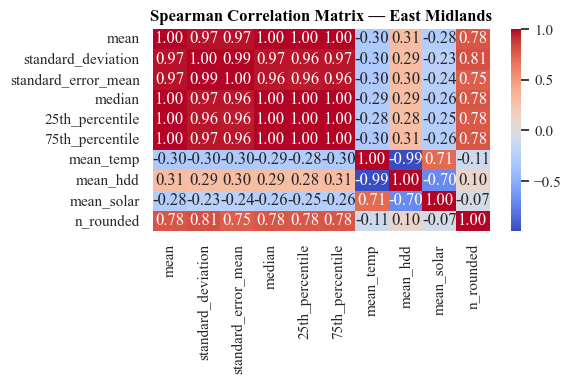

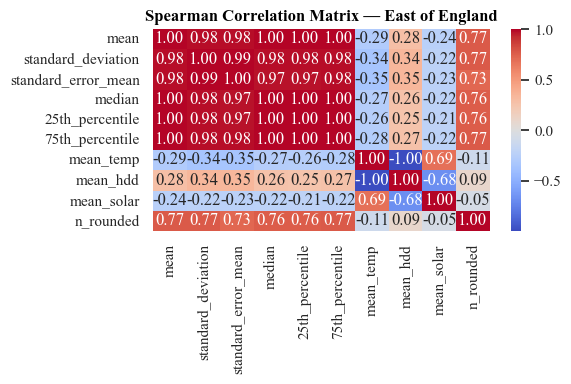

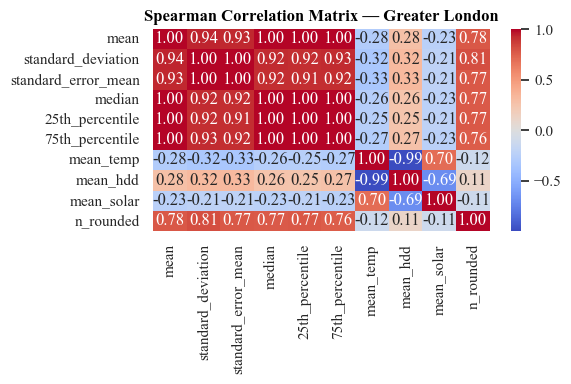

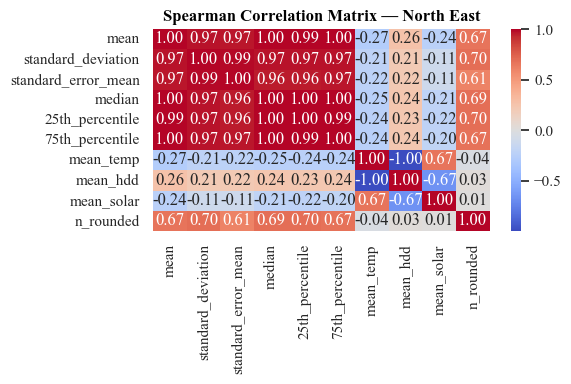

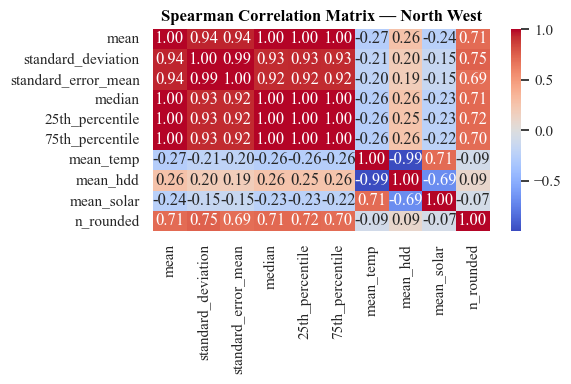

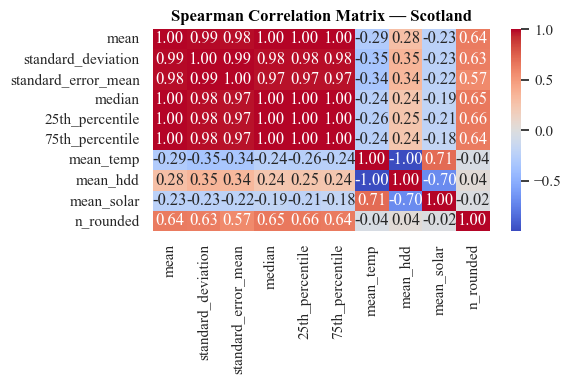

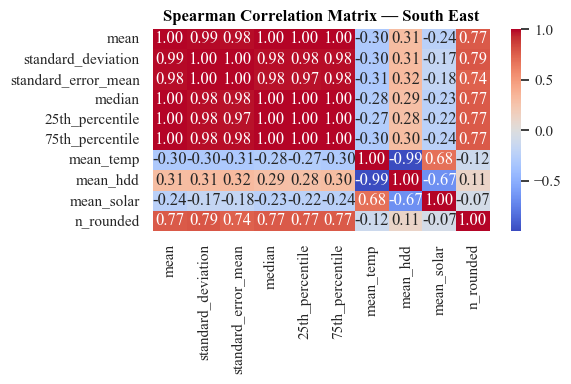

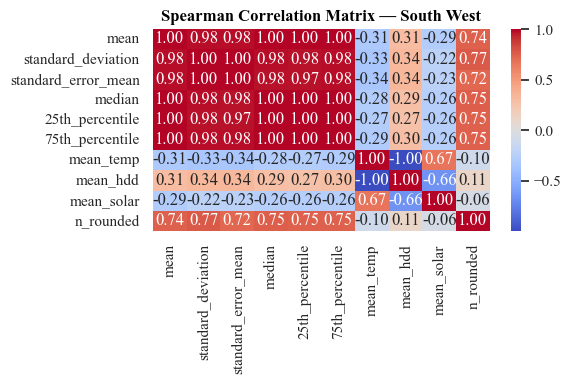

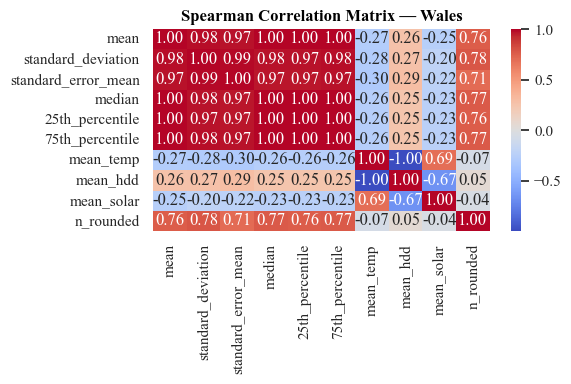

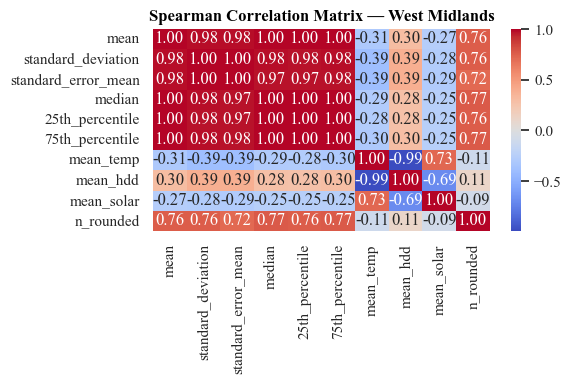

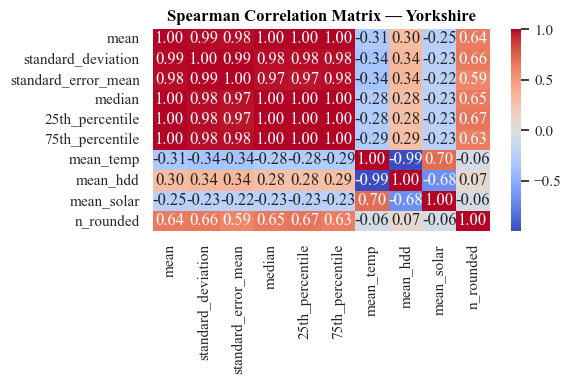


Spearman Correlation (Target vs Features) by Region:


--- East Midlands ---
                     mean
median               1.00
75th_percentile      1.00
25th_percentile      1.00
standard_deviation   0.97
standard_error_mean  0.97
n_rounded            0.78
mean_hdd             0.31
mean_solar          -0.28
mean_temp           -0.30

--- East of England ---
                     mean
75th_percentile      1.00
median               1.00
25th_percentile      1.00
standard_deviation   0.98
standard_error_mean  0.98
n_rounded            0.77
mean_hdd             0.28
mean_solar          -0.24
mean_temp           -0.29

--- Greater London ---
                     mean
75th_percentile      1.00
median               1.00
25th_percentile      1.00
standard_deviation   0.94
standard_error_mean  0.93
n_rounded            0.78
mean_hdd             0.28
mean_solar          -0.23
mean_temp           -0.28

--- North East ---
                     mean
75th_percentile      1.00
median               

In [23]:

# ████████████████████████████████  SPEARMAN CORRELATION BY REGION  ████████████████████████████████

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝
DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"
PLOT_HEATMAPS = True  # set False to skip plotting



# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ LOAD + FILTER                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝

df_reg = df[
    (df["segmentation_variable_3"] == "region")
    & (df["quantity"] == DEFAULT_QUANTITY)
    & (df["weekday_weekend"] == DEFAULT_WEEKPART)
    & (df["primary_space_heating_fuel"] == DEFAULT_FUEL)
    & (df["has_PV"] == DEFAULT_PV)
].copy()

# Keep only monthly rows
df_reg["aggregation_period"] = df_reg["aggregation_period"].astype(str)
df_reg = df_reg[df_reg["aggregation_period"].str.contains("-")].copy()

# Ensure numeric types for correlation
numeric_cols = df_reg.select_dtypes(include="number").columns.tolist()
if "mean" not in numeric_cols:
    df_reg["mean"] = pd.to_numeric(df_reg["mean"], errors="coerce")
    numeric_cols = df_reg.select_dtypes(include="number").columns.tolist()

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ SPEARMAN CORRELATION BY REGION                                           ║
# ╚══════════════════════════════════════════════════════════════════════════╝
region_corr_results = {}

for region, sub_df in df_reg.groupby("segment_3_value"):
    # Drop rows with NaN in target
    sub_df = sub_df.dropna(subset=["mean"])
    
    # Keep only numeric features
    sub_num = sub_df[numeric_cols]
    
    if len(sub_num) < 2:
        continue  # skip regions with too few points
    
    # Spearman correlation
    corr_matrix = sub_num.corr(method="spearman")
    
    # Extract correlations of target vs others (excluding self-correlation)
    target_corr = corr_matrix[["mean"]].drop(index="mean").sort_values("mean", ascending=False)
    region_corr_results[region] = target_corr

    # Optional heatmap
    if PLOT_HEATMAPS:
        plt.figure(figsize=(6, 4))
        sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
        plt.title(f"Spearman Correlation Matrix — {region}")
        plt.tight_layout()
        plt.show()

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ DISPLAY / EXPORT                                                         ║
# ╚══════════════════════════════════════════════════════════════════════════╝
print("\nSpearman Correlation (Target vs Features) by Region:\n")
for region, corr_df in region_corr_results.items():
    print(f"\n--- {region} ---")
    print(corr_df.to_string())

# Keep for later citation or analysis
spearman_corr_results = region_corr_results


In [24]:
# ████████████████████████████████  SEASONAL NAÏVE FORECAST   ████████████████████████████████

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝
DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ LOAD + BASELINE SLICE                                                    ║
# ╚══════════════════════════════════════════════════════════════════════════╝

df_reg = df[
    (df["segmentation_variable_3"] == "region")
    & (df["quantity"] == DEFAULT_QUANTITY)
    & (df["weekday_weekend"] == DEFAULT_WEEKPART)
    & (df["primary_space_heating_fuel"] == DEFAULT_FUEL)
    & (df["has_PV"] == DEFAULT_PV)
].copy()

# Keep only monthly rows
df_reg["aggregation_period"] = df_reg["aggregation_period"].astype(str)
df_reg = df_reg[df_reg["aggregation_period"].str.contains("-")].copy()

# Ensure numeric target
df_reg["mean"] = pd.to_numeric(df_reg["mean"], errors="coerce")
df_reg = df_reg.dropna(subset=["mean"])

# Parse date
df_reg["date"] = pd.to_datetime(df_reg["aggregation_period"], errors="coerce")
df_reg = df_reg.dropna(subset=["date"])

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ SEASONAL NAÏVE FORECAST                                                   ║
# ╚══════════════════════════════════════════════════════════════════════════╝
forecast_results = []
error_summary = []

for region, sub_df in df_reg.groupby("segment_3_value"):
    # Sort by date to ensure time order
    sub_df = sub_df.sort_values("date").copy()

    # Create a shifted version for seasonal naive (lag 12 months)
    sub_df["yhat"] = sub_df["mean"].shift(12)  # seasonal period = 12 months

    # Only evaluate where forecast exists
    valid_mask = ~sub_df["yhat"].isna()
    actual = sub_df.loc[valid_mask, "mean"]
    pred = sub_df.loc[valid_mask, "yhat"]

    if actual.empty:
        continue  # skip if less than 12 months of data

    # Compute metrics
    mae = mean_absolute_error(actual, pred)
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mape = (np.abs((actual - pred) / actual).mean()) * 100

    error_summary.append({
        "Region": region,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE_%": mape
    })

    # Store forecast for potential plotting
    sub_df["Region"] = region
    forecast_results.append(sub_df)

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ RESULTS                                                                  ║
# ╚══════════════════════════════════════════════════════════════════════════╝
error_df = pd.DataFrame(error_summary).sort_values("RMSE")
forecast_df = pd.concat(forecast_results, ignore_index=True)

pd.set_option("display.float_format", "{:,.2f}".format)

print("\nSeasonal Naïve Forecast — Error Summary by Region:\n")
print(error_df.to_string(index=False))

# NOTE: `forecast_df` now holds columns: Region, date, mean (actual), yhat (forecast)
# You can use this to plot actual vs forecast for any region:
#   sns.lineplot(data=forecast_df[forecast_df["Region"]=="Greater London"], x="date", y="mean")
#   sns.lineplot(data=forecast_df[forecast_df["Region"]=="Greater London"], x="date", y="yhat")



Seasonal Naïve Forecast — Error Summary by Region:

         Region  MAE  RMSE   MAPE_%
          Wales 3.70  4.80 1,548.15
  West Midlands 3.93  5.03 1,604.25
      Yorkshire 3.93  5.06 1,529.79
     North East 4.02  5.11 1,775.04
  East Midlands 4.14  5.15 1,590.81
     North West 4.33  5.43 1,719.52
East of England 4.30  5.49 1,483.06
     South West 4.34  5.52 1,890.37
       Scotland 4.40  5.61 1,818.84
 Greater London 4.60  5.83 1,585.43
     South East 4.71  5.94 1,807.91


In [25]:
# ████████████████████████████████  SEASONAL NAÏVE FORECAST  ████████████████████████████████

In [26]:

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝
DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"
SEASONAL_PERIODS = 12     # monthly data → yearly seasonality
FORECAST_HORIZON = 12     # months ahead for testing

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ LOAD + FILTER DATA                                                       ║
# ╚══════════════════════════════════════════════════════════════════════════╝

df_reg = df[
    (df["segmentation_variable_3"] == "region")
    & (df["quantity"] == DEFAULT_QUANTITY)
    & (df["weekday_weekend"] == DEFAULT_WEEKPART)
    & (df["primary_space_heating_fuel"] == DEFAULT_FUEL)
    & (df["has_PV"] == DEFAULT_PV)
].copy()

# Only keep monthly rows
df_reg["aggregation_period"] = df_reg["aggregation_period"].astype(str)
df_reg = df_reg[df_reg["aggregation_period"].str.contains("-")].copy()

# Ensure numeric target and valid dates
df_reg["mean"] = pd.to_numeric(df_reg["mean"], errors="coerce")
df_reg = df_reg.dropna(subset=["mean"])
df_reg["date"] = pd.to_datetime(df_reg["aggregation_period"], errors="coerce")
df_reg = df_reg.dropna(subset=["date"])

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ FIT + FORECAST PER REGION                                                ║
# ╚══════════════════════════════════════════════════════════════════════════╝
error_summary = []
forecast_results = []

for region, sub_df in df_reg.groupby("segment_3_value"):
    sub_df = sub_df.sort_values("date").copy()
    y = sub_df["mean"].values

    # Require at least 2 seasonal cycles for stable fitting
    if len(y) < SEASONAL_PERIODS * 2:
        print(f"Skipping {region}: insufficient data ({len(y)} points).")
        continue

    # Split into train/test sets
    train, test = y[:-FORECAST_HORIZON], y[-FORECAST_HORIZON:]
    train_index = sub_df["date"].iloc[:-FORECAST_HORIZON]
    test_index = sub_df["date"].iloc[-FORECAST_HORIZON:]

    try:
        model = ExponentialSmoothing(
            train,
            trend="add",
            seasonal="add",
            seasonal_periods=SEASONAL_PERIODS
        ).fit(optimized=True)
    except Exception as e:
        print(f"Holt–Winters failed for {region}: {e}")
        continue

    forecast = model.forecast(FORECAST_HORIZON)

    # Metrics
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    mape = (np.abs((test - forecast) / test).mean()) * 100

    error_summary.append({
        "Region": region,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE_%": mape
    })

    forecast_df = pd.DataFrame({
        "Region": region,
        "date": test_index,
        "actual": test,
        "forecast": forecast
    })
    forecast_results.append(forecast_df)

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ RESULTS                                                                  ║
# ╚══════════════════════════════════════════════════════════════════════════╝
error_df = pd.DataFrame(error_summary).sort_values("RMSE")
forecast_df = pd.concat(forecast_results, ignore_index=True)

pd.set_option("display.float_format", "{:,.2f}".format)

print("\nHolt–Winters Seasonal Benchmark — Error Summary by Region:\n")
print(error_df.to_string(index=False))

# `forecast_df` contains actual vs forecast for each region — ideal for plotting
# Example:
#   r = "Greater London"
#   sub = forecast_df[forecast_df["Region"] == r]
#   plt.plot(sub["date"], sub["actual"], label="Actual")
#   plt.plot(sub["date"], sub["forecast"], label="ETS Forecast")
#   plt.legend()



Holt–Winters Seasonal Benchmark — Error Summary by Region:

         Region  MAE  RMSE   MAPE_%
  West Midlands 3.53  4.05 1,440.53
     North East 3.77  4.14 1,659.96
          Wales 3.75  4.22 1,827.38
      Yorkshire 3.72  4.25 1,454.98
     North West 3.86  4.27 1,607.88
     South West 3.77  4.35 1,632.05
       Scotland 4.01  4.45 1,509.09
 Greater London 4.06  4.54 1,704.38
     South East 4.07  4.56 1,734.20
East of England 4.33  4.71 1,729.25
  East Midlands 4.23  4.80 1,812.80


In [27]:
# ████████████████████████████████  SARIMAX AND EXOGENEOUS  ████████████████████████████████

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝
DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"

# Choose your exogenous features (present in the CSV)
# HINT: 'mean_temp', 'mean_hdd', 'mean_solar' tend to be useful.
EXOG_COLS = ["mean_temp", "mean_hdd", "mean_solar"]

# Seasonal period for monthly data
SEASONAL_PERIODS = 12

# Holdout horizon (months) for evaluation
FORECAST_HORIZON = 12

# Small, sane grids to keep runtime manageable. Expand if needed.
ARIMA_GRID = [(0, 0, 0), (1, 0, 0), (0, 1, 1), (1, 1, 1)]
SEASONAL_GRID = [(0, 0, 0), (1, 0, 0), (0, 1, 1), (1, 1, 1)]


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ DATA CLASS                                                               ║
# ╚══════════════════════════════════════════════════════════════════════════╝
@dataclass
class SarimaxConfig:
    """Configuration for per-region SARIMAX models."""
    quantity: str = DEFAULT_QUANTITY
    weekpart: str = DEFAULT_WEEKPART
    fuel: str = DEFAULT_FUEL
    has_pv: str = DEFAULT_PV
    exog_cols: Optional[List[str]] = None
    seasonal_periods: int = SEASONAL_PERIODS
    forecast_horizon: int = FORECAST_HORIZON
    arima_grid: List[Tuple[int, int, int]] = None
    seasonal_grid: List[Tuple[int, int, int]] = None

    def __post_init__(self) -> None:
        # Defaults after dataclass init
        if self.exog_cols is None:
            self.exog_cols = EXOG_COLS
        if self.arima_grid is None:
            self.arima_grid = ARIMA_GRID
        if self.seasonal_grid is None:
            self.seasonal_grid = SEASONAL_GRID


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CORE CLASS                                                               ║
# ╚══════════════════════════════════════════════════════════════════════════╝
class RegionalSarimax:
    """
    Fit SARIMAX with exogenous regressors per region.

    Workflow
    --------
    1) Slice baseline data, keep monthly rows, coerce types.
    2) For each region:
       - Split into train/test (last `forecast_horizon` months for test).
       - Standardize exogenous regressors using train set parameters.
       - Grid search (p,d,q) × (P,D,Q) with AIC selection.
       - Fit best model, forecast test horizon.
       - Compute MAE/RMSE/MAPE; store results & forecasts.

    NOTE: Use ACF/PACF as hints; confirm with AIC here (and expand grid if needed).
    """

    def __init__(self, data: pd.DataFrame, config: SarimaxConfig) -> None:
        self.raw = data.copy()
        self.cfg = config
        self.slice_: Optional[pd.DataFrame] = None
        self.metrics_: Optional[pd.DataFrame] = None
        self.forecasts_: Optional[pd.DataFrame] = None
        self.best_orders_: Dict[str, Dict[str, Tuple[int, int, int]]] = {}

    # ------------------------------------------------------------------ #
    # Step 1: Prepare monthly slice                                      #
    # ------------------------------------------------------------------ #
    def prepare(self) -> "RegionalSarimax":
        """Filter to baseline slice and keep monthly rows with valid target/exog."""
        required_cols = {
            "segmentation_variable_3", "segment_3_value", "aggregation_period",
            "quantity", "weekday_weekend", "primary_space_heating_fuel",
            "has_PV", "mean",
        }
        missing = required_cols - set(self.raw.columns)
        if missing:
            raise KeyError(f"Missing required columns: {sorted(missing)}")

        df = self.raw[
            (self.raw["segmentation_variable_3"] == "region")
            & (self.raw["quantity"] == self.cfg.quantity)
            & (self.raw["weekday_weekend"] == self.cfg.weekpart)
            & (self.raw["primary_space_heating_fuel"] == self.cfg.fuel)
            & (self.raw["has_PV"] == self.cfg.has_pv)
        ].copy()

        # Keep only monthly observations (avoid 'YYYY' ambiguity).
        df["aggregation_period"] = df["aggregation_period"].astype(str)
        df = df[df["aggregation_period"].str.contains("-")].copy()

        # Parse date and ensure numeric target
        df["date"] = pd.to_datetime(df["aggregation_period"], errors="coerce")
        df["mean"] = pd.to_numeric(df["mean"], errors="coerce")
        df = df.dropna(subset=["date", "mean"])

        # Keep declared exogenous columns if present
        exog_cols = [c for c in (self.cfg.exog_cols or []) if c in df.columns]
        for col in exog_cols:
            df[col] = pd.to_numeric(df[col], errors="coerce")

        # Drop rows where *all* exogs are NaN (if exogs exist)
        if exog_cols:
            df = df.dropna(subset=exog_cols, how="all")

        # Sort for time order
        df = df.sort_values(["segment_3_value", "date"]).reset_index(drop=True)

        self.slice_ = df
        self.cfg.exog_cols = exog_cols  # keep only those that exist
        return self

    # ------------------------------------------------------------------ #
    # Step 2: Fit per region with AIC selection                          #
    # ------------------------------------------------------------------ #
    def fit_forecast(self) -> "RegionalSarimax":
        """Fit SARIMAX per region, select by AIC, and forecast holdout horizon."""
        if self.slice_ is None or self.slice_.empty:
            raise ValueError("Call .prepare() first; no data slice available.")

        metrics: List[Dict[str, float]] = []
        fc_rows: List[pd.DataFrame] = []

        for region, g in self.slice_.groupby("segment_3_value"):
            # Step 2.1: enforce minimum length (3 seasonal cycles for safety)
            if len(g) < (self.cfg.seasonal_periods * 3):
                # HACK: be kind but firm — short series → unstable models.
                print(f"Skipping {region}: only {len(g)} points.")
                continue

            # Step 2.2: split into train/test
            g = g.sort_values("date").copy()
            y = g["mean"].to_numpy(dtype=float)
            dates = g["date"].to_numpy()

            # Prepare exogenous arrays
            exg = None
            if self.cfg.exog_cols:
                exg = g[self.cfg.exog_cols].to_numpy(dtype=float)

            h = min(self.cfg.forecast_horizon, len(g) // 4)  # avoid tiny train sets
            if h < 3:
                h = 3  # at least 3 months to evaluate
            train_end = len(g) - h

            y_train, y_test = y[:train_end], y[train_end:]
            idx_train, idx_test = dates[:train_end], dates[train_end:]
            if exg is not None:
                X_train, X_test = exg[:train_end, :], exg[train_end:, :]
            else:
                X_train = X_test = None

            # Step 2.3: scale exogenous on train only (keeps SARIMAX numerical stable)
            scaler = None
            if X_train is not None:
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

            # Step 2.4: grid search by AIC
            best_aic = np.inf
            best_order = None
            best_seasonal = None
            best_model = None

            for (p, d, q) in self.cfg.arima_grid:
                for (P, D, Q) in self.cfg.seasonal_grid:
                    try:
                        model = SARIMAX(
                            endog=y_train,
                            exog=X_train,
                            order=(p, d, q),
                            seasonal_order=(P, D, Q, self.cfg.seasonal_periods),
                            enforce_stationarity=False,
                            enforce_invertibility=False,
                        )
                        res = model.fit(disp=False)
                        if res.aic < best_aic and np.isfinite(res.aic):
                            best_aic = res.aic
                            best_order = (p, d, q)
                            best_seasonal = (P, D, Q)
                            best_model = res
                    except Exception:
                        # NOTE: invalid combos or convergence failures are common — skip quietly
                        continue

            if best_model is None:
                print(f"SARIMAX failed to select for {region}; skipping.")
                continue

            self.best_orders_[region] = {
                "order": best_order,
                "seasonal": best_seasonal,
                "AIC": best_aic,
            }

            # Step 2.5: refit on full train (already done) and forecast test horizon
            try:
                yhat = best_model.get_forecast(steps=h, exog=X_test).predicted_mean
            except Exception:
                # Some specs require full refit including test exog dims; retry with refit on all data
                try:
                    model_full = SARIMAX(
                        endog=y[:train_end],  # still train only to keep evaluation honest
                        exog=X_train,
                        order=best_order,
                        seasonal_order=(*best_seasonal, self.cfg.seasonal_periods),
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                    ).fit(disp=False)
                    yhat = model_full.get_forecast(steps=h, exog=X_test).predicted_mean
                except Exception as exc:
                    print(f"Forecast failure for {region}: {exc}")
                    continue

            # Step 2.6: metrics
            mae = mean_absolute_error(y_test, yhat)
            rmse = float(np.sqrt(mean_squared_error(y_test, yhat)))
            mape = float((np.abs((y_test - yhat) / y_test).mean()) * 100)

            metrics.append(
                {"Region": region, "MAE": mae, "RMSE": rmse, "MAPE_%": mape,
                 "order": best_order, "seasonal": best_seasonal, "AIC": best_aic}
            )

            # Step 2.7: collect forecast rows
            fc = pd.DataFrame(
                {"Region": region, "date": idx_test, "actual": y_test, "forecast": yhat}
            )
            fc_rows.append(fc)

        # Collate outputs
        self.metrics_ = (
            pd.DataFrame(metrics)
            .sort_values(["RMSE", "Region"])
            .reset_index(drop=True)
        )
        self.forecasts_ = pd.concat(fc_rows, ignore_index=True) if fc_rows else pd.DataFrame()
        return self

    # ------------------------------------------------------------------ #
    # Step 3: Convenience getters                                         #
    # ------------------------------------------------------------------ #
    def metrics(self) -> pd.DataFrame:
        """Get error metrics table (per region)."""
        if self.metrics_ is None:
            raise ValueError("Run .fit_forecast() first.")
        return self.metrics_

    def forecasts(self) -> pd.DataFrame:
        """Get forecast DataFrame with columns: Region, date, actual, forecast."""
        if self.forecasts_ is None:
            raise ValueError("Run .fit_forecast() first.")
        return self.forecasts_


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ EXECUTION                                                                ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# Step 1: Load if not already in memory

# Step 2: Instantiate and run
cfg = SarimaxConfig(
    quantity=DEFAULT_QUANTITY,
    weekpart=DEFAULT_WEEKPART,
    fuel=DEFAULT_FUEL,
    has_pv=DEFAULT_PV,
    exog_cols=EXOG_COLS,                 # tweak as needed
    seasonal_periods=SEASONAL_PERIODS,
    forecast_horizon=FORECAST_HORIZON,
    arima_grid=ARIMA_GRID,
    seasonal_grid=SEASONAL_GRID,
)

sarx = RegionalSarimax(data=df, config=cfg)
sarx.prepare().fit_forecast()

# Step 3: Display results (for citation in the dissertation)
pd.set_option("display.float_format", "{:,.3f}".format)

print("\nSARIMAX (with exogenous) — Best orders by region and test errors:")
print(sarx.metrics().to_string(index=False))

# Keep these in variables for downstream plots/tables
sarimax_error_df = sarx.metrics()
sarimax_forecast_df = sarx.forecasts()

# TODO: (Optional) Add rolling-origin evaluation for more robust metrics.
# TODO: (Optional) Compare against Seasonal Naïve and ETS in a single summary table.



SARIMAX (with exogenous) — Best orders by region and test errors:
         Region   MAE  RMSE    MAPE_%     order  seasonal     AIC
       Scotland 3.220 3.663 1,251.256 (1, 1, 1) (1, 1, 1) 612.367
     North East 3.272 3.706 1,576.160 (1, 1, 1) (0, 1, 1) 589.736
  West Midlands 3.397 3.776 1,468.408 (1, 1, 1) (0, 1, 1) 583.169
     South West 3.550 3.991 1,700.817 (1, 1, 1) (0, 1, 1) 608.959
     North West 3.536 4.006 1,572.192 (1, 1, 1) (0, 1, 1) 608.170
          Wales 3.692 4.088 1,920.590 (1, 1, 1) (0, 1, 1) 590.745
      Yorkshire 3.677 4.098 1,527.473 (1, 1, 1) (0, 1, 1) 584.223
     South East 3.797 4.268 1,764.110 (1, 1, 1) (0, 1, 1) 626.393
 Greater London 3.909 4.504 1,675.994 (1, 1, 1) (0, 1, 1) 617.019
East of England 4.032 4.559 1,734.666 (1, 1, 1) (0, 1, 1) 608.842
  East Midlands 3.949 4.663 1,809.231 (1, 1, 1) (0, 1, 1) 593.416


In [28]:
# ████████████████████████████████  SARIMAX HH=SS CDD PER REGION  ████████████████████████████████

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝
DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"

# Seasonal period for monthly data
SEASONAL_PERIODS = 12

# Holdout horizon (months) for evaluation
FORECAST_HORIZON = 12

# Small grid to keep runtime sane. Expand if needed.
ARIMA_GRID = [(0, 1, 1), (1, 1, 1), (1, 0, 0)]
SEASONAL_GRID = [(0, 1, 1), (1, 1, 1), (1, 0, 0)]

# HDD/CDD bases (UK-common defaults). Adjust for your domain if needed.
BASE_TEMP_HDD = 15.5  # °C (heating degree base)
BASE_TEMP_CDD = 22.0  # °C (cooling degree base)

# Candidate optional exogenous columns to *consider* after HDD/CDD
OPTIONAL_EXOG_CANDIDATES = [
    # Try typical names found in metered/energy datasets
    "mean_humidity", "humidity", "rel_humidity",
    "mean_wind", "wind_speed", "wind"
]


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ DATA CLASS                                                               ║
# ╚══════════════════════════════════════════════════════════════════════════╝
@dataclass
class SarimaxHddCddConfig:
    """Config for per-region SARIMAX models with HDD/CDD as core exog."""
    quantity: str = DEFAULT_QUANTITY
    weekpart: str = DEFAULT_WEEKPART
    fuel: str = DEFAULT_FUEL
    has_pv: str = DEFAULT_PV
    seasonal_periods: int = SEASONAL_PERIODS
    forecast_horizon: int = FORECAST_HORIZON
    arima_grid: List[Tuple[int, int, int]] = None
    seasonal_grid: List[Tuple[int, int, int]] = None
    base_temp_hdd: float = BASE_TEMP_HDD
    base_temp_cdd: float = BASE_TEMP_CDD
    optional_exog_candidates: List[str] = None
    aic_delta_keep: float = 2.0  # keep an optional exog if AIC improves by ≥ 2

    def __post_init__(self) -> None:
        if self.arima_grid is None:
            self.arima_grid = ARIMA_GRID
        if self.seasonal_grid is None:
            self.seasonal_grid = SEASONAL_GRID
        if self.optional_exog_candidates is None:
            self.optional_exog_candidates = OPTIONAL_EXOG_CANDIDATES


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CORE CLASS                                                               ║
# ╚══════════════════════════════════════════════════════════════════════════╝
class RegionalSarimaxHddCdd:
    """
    SARIMAX per region using derived HDD/CDD as exogenous drivers.
    Optionally tests humidity/wind features and retains them only if they
    improve AIC by a meaningful margin (default ΔAIC ≥ 2).
    """

    def __init__(self, data: pd.DataFrame, config: SarimaxHddCddConfig) -> None:
        self.raw = data.copy()
        self.cfg = config
        self.slice_: Optional[pd.DataFrame] = None
        self.metrics_: Optional[pd.DataFrame] = None
        self.forecasts_: Optional[pd.DataFrame] = None
        self.best_orders_: Dict[str, Dict[str, Tuple[int, int, int] | float | List[str]]] = {}

    # ------------------------------------------------------------------ #
    # Step 1: Prepare data slice + derive HDD/CDD                        #
    # ------------------------------------------------------------------ #
    def prepare(self) -> "RegionalSarimaxHddCdd":
        """Filter to monthly rows, derive HDD/CDD from mean_temp, coerce dtypes."""
        required = {
            "segmentation_variable_3", "segment_3_value", "aggregation_period",
            "quantity", "weekday_weekend", "primary_space_heating_fuel",
            "has_PV", "mean"
        }
        missing = required - set(self.raw.columns)
        if missing:
            raise KeyError(f"Missing required columns: {sorted(missing)}")

        df = self.raw[
            (self.raw["segmentation_variable_3"] == "region")
            & (self.raw["quantity"] == self.cfg.quantity)
            & (self.raw["weekday_weekend"] == self.cfg.weekpart)
            & (self.raw["primary_space_heating_fuel"] == self.cfg.fuel)
            & (self.raw["has_PV"] == self.cfg.has_pv)
        ].copy()

        # Keep only monthly rows (avoid 'YYYY' ambiguity)
        df["aggregation_period"] = df["aggregation_period"].astype(str)
        df = df[df["aggregation_period"].str.contains("-")].copy()

        # Parse/clean
        df["date"] = pd.to_datetime(df["aggregation_period"], errors="coerce")
        df["mean"] = pd.to_numeric(df["mean"], errors="coerce")
        df = df.dropna(subset=["date", "mean"])

        # Derive HDD/CDD from temperature (prefer raw temp if present)
        # NOTE: If `mean_temp` is missing, we fallback to existing mean_hdd if available.
        if "mean_temp" in df.columns:
            df["mean_temp"] = pd.to_numeric(df["mean_temp"], errors="coerce")
            # HDD: heating degree days proxy per-month mean deviation
            df["HDD"] = (self.cfg.base_temp_hdd - df["mean_temp"]).clip(lower=0.0)
            # CDD: cooling degree days proxy per-month mean deviation
            df["CDD"] = (df["mean_temp"] - self.cfg.base_temp_cdd).clip(lower=0.0)
        else:
            # FIXME: No mean_temp. Use provided mean_hdd as a proxy for HDD and set CDD=0.
            # Better: compute from daily temps if available upstream.
            if "mean_hdd" in df.columns:
                df["HDD"] = pd.to_numeric(df["mean_hdd"], errors="coerce").clip(lower=0.0)
            else:
                df["HDD"] = 0.0
            df["CDD"] = 0.0  # conservative fallback

        # Collect optional exog that actually exist
        available_optional = [c for c in self.cfg.optional_exog_candidates if c in df.columns]
        for col in available_optional:
            df[col] = pd.to_numeric(df[col], errors="coerce")

        # Some rows may have NaNs in optional exogs; that's okay — we will drop rows
        # only when an optional exog is *selected* for a region.
        df = df.sort_values(["segment_3_value", "date"]).reset_index(drop=True)

        self.slice_ = df
        self.available_optional_ = available_optional
        return self

    # ------------------------------------------------------------------ #
    # Step 2: Fit models, test optional exog via AIC, forecast           #
    # ------------------------------------------------------------------ #
    def fit_forecast(self) -> "RegionalSarimaxHddCdd":
        """Fit SARIMAX per region with HDD/CDD, optionally adding humidity/wind."""
        if self.slice_ is None or self.slice_.empty:
            raise ValueError("Call .prepare() first; no data slice available.")

        metrics_rows: List[Dict] = []
        fc_rows: List[pd.DataFrame] = []

        for region, g in self.slice_.groupby("segment_3_value"):
            g = g.sort_values("date").copy()

            # Require at least ~3 seasonal cycles for stability
            if len(g) < self.cfg.seasonal_periods * 3:
                print(f"Skipping {region}: only {len(g)} points.")
                continue

            # Base exog = HDD + CDD
            base_exog_cols = ["HDD", "CDD"]

            # Holdout split
            h = min(self.cfg.forecast_horizon, len(g) // 4)
            h = max(h, 3)  # at least 3 months
            train = g.iloc[:-h].copy()
            test = g.iloc[-h:].copy()

            y_train = train["mean"].to_numpy(float)
            y_test = test["mean"].to_numpy(float)

            # Prepare base exog arrays
            X_train = train[base_exog_cols].to_numpy(float)
            X_test = test[base_exog_cols].to_numpy(float)

            # Scale exog for numerical stability (no leakage)
            scaler = StandardScaler()
            X_train_s = scaler.fit_transform(X_train)
            X_test_s = scaler.transform(X_test)

            # --- Helper: fit grid and return best model by AIC
            def fit_best(endog, exog):
                best = {"aic": np.inf, "order": None, "seasonal": None, "res": None}
                for (p, d, q) in self.cfg.arima_grid:
                    for (P, D, Q) in self.cfg.seasonal_grid:
                        try:
                            m = SARIMAX(
                                endog=endog,
                                exog=exog,
                                order=(p, d, q),
                                seasonal_order=(P, D, Q, self.cfg.seasonal_periods),
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                            )
                            r = m.fit(disp=False)
                            if np.isfinite(r.aic) and r.aic < best["aic"]:
                                best = {"aic": r.aic, "order": (p, d, q), "seasonal": (P, D, Q), "res": r}
                        except Exception:
                            # NOTE: Invalid combos or convergence failures are common; skip.
                            continue
                return best

            # Step 2.1: Base model (HDD+CDD)
            base = fit_best(y_train, X_train_s)
            if base["res"] is None:
                print(f"SARIMAX failed for {region} with HDD/CDD.")
                continue

            chosen_exogs = base_exog_cols.copy()
            chosen_scaler = scaler
            chosen_aic = base["aic"]
            chosen_model = base["res"]
            chosen_order = base["order"]
            chosen_seasonal = base["seasonal"]

            # Step 2.2: Greedy test optional exogs (humidity/wind) one-by-one
            # We keep an exog only if AIC improves by at least aic_delta_keep.
            remaining = [c for c in self.available_optional_ if c not in chosen_exogs]
            # Clean optionals (align and drop rows where candidate is NaN in train)
            for cand in remaining:
                cand_train = train[[cand] + base_exog_cols].dropna()
                # If dropping NaNs nukes too much data, skip candidate
                if len(cand_train) < len(train) * 0.7:
                    continue

                # Align corresponding arrays
                idx = cand_train.index
                y_train_c = train.loc[idx, "mean"].to_numpy(float)
                X_train_c = cand_train[base_exog_cols + [cand]].to_numpy(float)

                # Scale with a fresh scaler for this candidate test
                scaler_c = StandardScaler()
                X_train_c_s = scaler_c.fit_transform(X_train_c)

                test_c = test.dropna(subset=[cand]).copy()
                if len(test_c) < max(3, int(0.7 * len(test))):
                    # Too few test rows left → skip this candidate
                    continue

                X_test_c = test_c[base_exog_cols + [cand]].to_numpy(float)
                X_test_c_s = scaler_c.transform(X_test_c)
                y_test_c = test_c["mean"].to_numpy(float)

                cand_best = fit_best(y_train_c, X_train_c_s)
                if cand_best["res"] is None:
                    continue

                if cand_best["aic"] + self.cfg.aic_delta_keep < chosen_aic:
                    # Adopt candidate
                    chosen_aic = cand_best["aic"]
                    chosen_model = cand_best["res"]
                    chosen_order = cand_best["order"]
                    chosen_seasonal = cand_best["seasonal"]
                    chosen_exogs = base_exog_cols + [cand]
                    chosen_scaler = scaler_c
                    # Update aligned train/test for forecasting
                    train = train.loc[idx].copy()
                    test = test_c.copy()
                    y_train = y_train_c
                    y_test = y_test_c
                    X_train_s = X_train_c_s
                    X_test_s = X_test_c_s
                    # NOTE: Continue testing remaining candidates greedily.

            # Step 2.3: Forecast on test window with chosen spec
            try:
                yhat = chosen_model.get_forecast(steps=len(y_test), exog=X_test_s).predicted_mean
            except Exception:
                # Rare edge: refit with the chosen spec to be safe
                try:
                    refit = SARIMAX(
                        endog=y_train,
                        exog=X_train_s,
                        order=chosen_order,
                        seasonal_order=(*chosen_seasonal, self.cfg.seasonal_periods),
                        enforce_stationarity=False,
                        enforce_invertibility=False,
                    ).fit(disp=False)
                    yhat = refit.get_forecast(steps=len(y_test), exog=X_test_s).predicted_mean
                except Exception as exc:
                    print(f"Forecast failure for {region}: {exc}")
                    continue

            # Step 2.4: Metrics
            mae = mean_absolute_error(y_test, yhat)
            rmse = float(np.sqrt(mean_squared_error(y_test, yhat)))
            mape = float((np.abs((y_test - yhat) / y_test).mean()) * 100)

            metrics_rows.append({
                "Region": region,
                "MAE": mae,
                "RMSE": rmse,
                "MAPE_%": mape,
                "AIC": float(chosen_aic),
                "order": chosen_order,
                "seasonal": chosen_seasonal,
                "exog_used": ",".join(chosen_exogs)
            })

            fc = pd.DataFrame({
                "Region": region,
                "date": test["date"].to_numpy(),
                "actual": y_test,
                "forecast": yhat
            })
            fc_rows.append(fc)

            # Keep record of best spec
            self.best_orders_[region] = {
                "order": chosen_order,
                "seasonal": chosen_seasonal,
                "AIC": float(chosen_aic),
                "exog_used": chosen_exogs
            }

        # Collate outputs
        self.metrics_ = (
            pd.DataFrame(metrics_rows)
            .sort_values(["RMSE", "Region"])
            .reset_index(drop=True)
        )
        self.forecasts_ = pd.concat(fc_rows, ignore_index=True) if fc_rows else pd.DataFrame()
        return self

    # ------------------------------------------------------------------ #
    # Step 3: Accessors                                                  #
    # ------------------------------------------------------------------ #
    def metrics(self) -> pd.DataFrame:
        if self.metrics_ is None:
            raise ValueError("Run .fit_forecast() first.")
        return self.metrics_

    def forecasts(self) -> pd.DataFrame:
        if self.forecasts_ is None:
            raise ValueError("Run .fit_forecast() first.")
        return self.forecasts_


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ EXECUTION                                                                ║
# ╚══════════════════════════════════════════════════════════════════════════╝

cfg = SarimaxHddCddConfig(
    quantity=DEFAULT_QUANTITY,
    weekpart=DEFAULT_WEEKPART,
    fuel=DEFAULT_FUEL,
    has_pv=DEFAULT_PV,
    seasonal_periods=SEASONAL_PERIODS,
    forecast_horizon=FORECAST_HORIZON,
    arima_grid=ARIMA_GRID,
    seasonal_grid=SEASONAL_GRID,
    base_temp_hdd=BASE_TEMP_HDD,
    base_temp_cdd=BASE_TEMP_CDD,
    aic_delta_keep=2.0,  # be a bit conservative; raise to 4 if you want stronger evidence
)

model = RegionalSarimaxHddCdd(data=df, config=cfg)
model.prepare().fit_forecast()

pd.set_option("display.float_format", "{:,.3f}".format)

print("\nSARIMAX with derived HDD/CDD (optional humidity/wind if helpful):")
print(model.metrics().to_string(index=False))

# Keep for downstream comparison/plots
sarimax_hddcdd_error_df = model.metrics()
sarimax_hddcdd_forecast_df = model.forecasts()

# NOTE:
# - HDD/CDD are derived from mean_temp each month.
# - Humidity/wind are *only* added if they improve AIC by >= 2 (configurable).
# - Expand ARIMA/seasonal grids if you need a deeper search.
# - Consider rolling-origin evaluation for robustness in a later step.



SARIMAX with derived HDD/CDD (optional humidity/wind if helpful):
         Region   MAE  RMSE    MAPE_%     AIC     order  seasonal exog_used
       Scotland 3.259 3.721 1,188.173 610.902 (1, 1, 1) (1, 1, 1)   HDD,CDD
     North East 3.410 3.808 1,443.666 589.158 (1, 1, 1) (0, 1, 1)   HDD,CDD
  West Midlands 3.469 3.849 1,373.022 582.425 (1, 1, 1) (0, 1, 1)   HDD,CDD
     North West 3.574 4.074 1,465.576 606.943 (1, 1, 1) (0, 1, 1)   HDD,CDD
     South West 3.701 4.115 1,520.939 609.392 (1, 1, 1) (0, 1, 1)   HDD,CDD
          Wales 3.776 4.150 1,787.299 590.521 (1, 1, 1) (0, 1, 1)   HDD,CDD
      Yorkshire 3.742 4.168 1,438.526 583.363 (1, 1, 1) (0, 1, 1)   HDD,CDD
     South East 3.919 4.326 1,651.190 625.485 (1, 1, 1) (0, 1, 1)   HDD,CDD
 Greater London 3.976 4.534 1,618.416 615.295 (1, 1, 1) (0, 1, 1)   HDD,CDD
East of England 4.140 4.642 1,604.332 608.469 (1, 1, 1) (0, 1, 1)   HDD,CDD
  East Midlands 4.043 4.736 1,677.956 593.134 (1, 1, 1) (0, 1, 1)   HDD,CDD


In [29]:
# ████████████████████████████████  WALK FORWARD BACKFESR EXPANDING ████████████████████████████████

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝

DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"

SEASONAL_PERIODS = 12          # monthly data → yearly seasonality
MIN_TRAIN_POINTS = 36          # at least 3 years before starting folds
REFIT_EVERY = 1                # refit each fold (set >1 to speed up at the cost of bias)

# Small, sane grids for initial order selection (on the first train window)
ARIMA_GRID = [(0, 1, 1), (1, 1, 1), (1, 0, 0)]
SEASONAL_GRID = [(0, 1, 1), (1, 1, 1), (1, 0, 0)]

# HDD/CDD base temperatures (°C) — adjust to your domain if needed
BASE_TEMP_HDD = 15.5
BASE_TEMP_CDD = 22.0

# Optional meteorological features to consider (ONLY if present)
OPTIONAL_EXOG_CANDIDATES = ["mean_humidity", "humidity", "rel_humidity",
                            "mean_wind", "wind_speed", "wind"]


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ DATA PREP UTILITIES                                                      ║
# ╚══════════════════════════════════════════════════════════════════════════╝
def derive_hdd_cdd(df: pd.DataFrame,
                   base_hdd: float = BASE_TEMP_HDD,
                   base_cdd: float = BASE_TEMP_CDD) -> pd.DataFrame:
    """Derive HDD/CDD from mean_temp if available; otherwise fall back to mean_hdd."""
    out = df.copy()
    if "mean_temp" in out.columns:
        out["mean_temp"] = pd.to_numeric(out["mean_temp"], errors="coerce")
        out["HDD"] = (base_hdd - out["mean_temp"]).clip(lower=0.0)
        out["CDD"] = (out["mean_temp"] - base_cdd).clip(lower=0.0)
    else:
        # NOTE: Fallback — use provided mean_hdd, set CDD=0
        out["HDD"] = pd.to_numeric(out.get("mean_hdd", 0.0), errors="coerce").clip(lower=0.0)
        out["CDD"] = 0.0
    return out


def mase_denominator(y: np.ndarray, m: int) -> float:
    """
    Compute the scaling denominator for MASE.
    Seasonal version: mean absolute difference y_t - y_{t-m} over t=m..T-1.
    If not enough history, fall back to simple lag-1 differences.
    """
    y = np.asarray(y, dtype=float)
    if len(y) <= m:
        diffs = np.abs(np.diff(y))
    else:
        diffs = np.abs(y[m:] - y[:-m])
    denom = np.mean(diffs) if diffs.size > 0 else np.nan
    # Avoid division by zero; if denom ~ 0, return NaN to signal undefined MASE
    return denom if denom and np.isfinite(denom) else np.nan


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ MODEL SELECTION (FIRST WINDOW ONLY)                                      ║
# ╚══════════════════════════════════════════════════════════════════════════╝
def select_orders_aic(y_train: np.ndarray,
                      X_train: Optional[np.ndarray],
                      seasonal_periods: int,
                      arima_grid: List[Tuple[int, int, int]],
                      seasonal_grid: List[Tuple[int, int, int]]) -> Tuple[Tuple[int, int, int], Tuple[int, int, int]]:
    """Grid-search (p,d,q)×(P,D,Q)m on the FIRST training window via AIC."""
    best_aic = np.inf
    best_order, best_seasonal = None, None
    for (p, d, q) in arima_grid:
        for (P, D, Q) in seasonal_grid:
            try:
                mod = SARIMAX(
                    endog=y_train,
                    exog=X_train,
                    order=(p, d, q),
                    seasonal_order=(P, D, Q, seasonal_periods),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                res = mod.fit(disp=False)
                if np.isfinite(res.aic) and res.aic < best_aic:
                    best_aic = res.aic
                    best_order, best_seasonal = (p, d, q), (P, D, Q)
            except Exception:
                # HACK: Convergence hiccups are common — just skip this combo.
                continue
    if best_order is None:
        # Sensible fallback if everything exploded (rare)
        best_order, best_seasonal = (1, 1, 1), (0, 1, 1)
    return best_order, best_seasonal


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ WALK-FORWARD BACKTEST (EXPANDING WINDOW)                                 ║
# ╚══════════════════════════════════════════════════════════════════════════╝
def walk_forward_backtest_region(g: pd.DataFrame,
                                 seasonal_periods: int = SEASONAL_PERIODS,
                                 min_train_points: int = MIN_TRAIN_POINTS,
                                 refit_every: int = REFIT_EVERY,
                                 consider_optional_exog: bool = True
                                 ) -> Dict[str, float]:
    """
    Perform 1-step-ahead expanding-window backtesting for a single region.

    Returns a dict with MAE_mean, MAE_std, RMSE_mean, RMSE_std, MASE_mean, MASE_std,
    plus counts of folds and the selected SARIMAX orders.
    """
    g = g.sort_values("date").copy()

    # Core exogenous drivers
    base_exog_cols = ["HDD", "CDD"]

    # Optional meteorological candidates (use only if present)
    optional_cols = [c for c in OPTIONAL_EXOG_CANDIDATES if c in g.columns] if consider_optional_exog else []
    # Start with base exog only; we’ll test adding optionals on the first window by AIC
    chosen_exogs = base_exog_cols.copy()

    y = g["mean"].to_numpy(float)
    X_all = g[chosen_exogs].to_numpy(float)

    # Scale exog using *only* the first training window (fit once, use across folds)
    # This is important to avoid leakage and to keep folds comparable.
    if len(g) < min_train_points + 1:
        return {"folds": 0}

    # Determine folds: t indexes the last observation in the training window.
    # We forecast y[t+1] using data up to t (expanding window).
    start_t = min_train_points - 1
    ts = list(range(start_t, len(g) - 1))

    # Fit scaler on the first train window
    scaler = StandardScaler().fit(X_all[: start_t + 1, :])
    Xs_all = scaler.transform(X_all)

    # ── Optional feature test (only once on the first window), keep if AIC improves ──
    best_order, best_seasonal = None, None
    if optional_cols:
        # Prepare train arrays for first window
        y_tr = y[: start_t + 1]
        X_tr_base = Xs_all[: start_t + 1, :]
        # Base selection
        best_order, best_seasonal = select_orders_aic(
            y_tr, X_tr_base, seasonal_periods, ARIMA_GRID, SEASONAL_GRID
        )
        try:
            base_mod = SARIMAX(y_tr, exog=X_tr_base, order=best_order,
                               seasonal_order=(*best_seasonal, seasonal_periods),
                               enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
            base_aic = base_mod.aic
        except Exception:
            base_aic = np.inf

        # Try each optional column appended to base exog
        for col in optional_cols:
            X_opt = g[base_exog_cols + [col]].to_numpy(float)
            Xs_opt = StandardScaler().fit_transform(X_opt[: start_t + 1, :])  # fit on train
            ord_opt, seas_opt = select_orders_aic(
                y_tr, Xs_opt, seasonal_periods, ARIMA_GRID, SEASONAL_GRID
            )
            try:
                mod_opt = SARIMAX(
                    y_tr, exog=Xs_opt, order=ord_opt,
                    seasonal_order=(*seas_opt, seasonal_periods),
                    enforce_stationarity=False, enforce_invertibility=False
                ).fit(disp=False)
                if np.isfinite(mod_opt.aic) and mod_opt.aic + 2.0 < base_aic:
                    # Keep the optional feature
                    chosen_exogs = base_exog_cols + [col]
                    best_order, best_seasonal = ord_opt, seas_opt
                    # Recompute X-all and scaling with the new exog set
                    X_all = g[chosen_exogs].to_numpy(float)
                    scaler = StandardScaler().fit(X_all[: start_t + 1, :])
                    Xs_all = scaler.transform(X_all)
                    base_aic = mod_opt.aic
            except Exception:
                continue

    # If no orders chosen yet, select on the first window now (base exog only)
    if best_order is None:
        y_tr = y[: start_t + 1]
        X_tr = Xs_all[: start_t + 1, :]
        best_order, best_seasonal = select_orders_aic(
            y_tr, X_tr, seasonal_periods, ARIMA_GRID, SEASONAL_GRID
        )

    # Containers for fold-wise errors and per-fold MASE
    abs_errs, sq_errs, mase_vals = [], [], []
    denom_cache: Dict[int, float] = {}  # cache MASE denominator by train length

    # Refit cache if we decide not to refit every fold (REFIT_EVERY > 1)
    last_fit_t = None
    fitted_res = None

    # ╔══════════════════════════════════════════════════════════════════════╗
    # ║ WALK FORWARD LOOP                                                    ║
    # ╚══════════════════════════════════════════════════════════════════════╝
    for i, t in enumerate(ts, start=1):
        # Train window = [0 .. t], forecast target = t+1
        y_train = y[: t + 1]
        X_train = Xs_all[: t + 1, :]
        X_next = Xs_all[t + 1: t + 2, :]  # single-step exog

        # Refit logic
        need_refit = (last_fit_t is None) or ((i - 1) % refit_every == 0)
        if need_refit:
            try:
                mod = SARIMAX(
                    endog=y_train,
                    exog=X_train,
                    order=best_order,
                    seasonal_order=(*best_seasonal, seasonal_periods),
                    enforce_stationarity=False,
                    enforce_invertibility=False,
                )
                fitted_res = mod.fit(disp=False)
                last_fit_t = t
            except Exception:
                # If fitting fails at this t, skip this fold gracefully
                continue

        # 1-step forecast
        try:
            yhat = fitted_res.get_forecast(steps=1, exog=X_next).predicted_mean[0]
        except Exception:
            # If forecast fails, skip this fold
            continue

        y_true = y[t + 1]
        err = y_true - yhat

        abs_errs.append(abs(err))
        sq_errs.append(err ** 2)

        # MASE: |error| / mean(|y_t - y_{t-m}|) computed on *training* data only
        if len(y_train) not in denom_cache:
            denom_cache[len(y_train)] = mase_denominator(y_train, SEASONAL_PERIODS)
        denom = denom_cache[len(y_train)]
        mase_vals.append(abs(err) / denom if denom and np.isfinite(denom) and denom != 0 else np.nan)

    # Summaries
    abs_errs = np.asarray(abs_errs, dtype=float)
    sq_errs = np.asarray(sq_errs, dtype=float)
    mase_vals = np.asarray(mase_vals, dtype=float)

    folds = len(abs_errs)
    if folds == 0:
        return {"folds": 0}

    mae_vals = abs_errs
    rmse_vals = np.sqrt(sq_errs)  # per-fold RMSE is the abs error for 1-step; still okay
    # NOTE: For 1-step folds, RMSE per fold equals |error|; we still compute mean±std over folds.
    # If you want multi-step blocks, extend the fold definition accordingly.

    out = {
        "folds": folds,
        "MAE_mean": float(np.nanmean(mae_vals)),
        "MAE_std": float(np.nanstd(mae_vals, ddof=1)) if folds > 1 else 0.0,
        "RMSE_mean": float(np.nanmean(rmse_vals)),
        "RMSE_std": float(np.nanstd(rmse_vals, ddof=1)) if folds > 1 else 0.0,
        "MASE_mean": float(np.nanmean(mase_vals)),
        "MASE_std": float(np.nanstd(mase_vals, ddof=1)) if folds > 1 else 0.0,
        "order": best_order,
        "seasonal": best_seasonal,
        "exog_used": ",".join(chosen_exogs),
    }
    return out


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ EXECUTION: PREP DATA + RUN BACKTEST PER REGION                           ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# Step 1: Load data if not already present
try:
    df  # noqa: F821
except NameError:
    df = pd.read_csv("/mnt/data/forcasting.csv")

# Step 2: Baseline slice (region, monthly, target, exog)
d0 = df[
    (df["segmentation_variable_3"] == "region")
    & (df["quantity"] == DEFAULT_QUANTITY)
    & (df["weekday_weekend"] == DEFAULT_WEEKPART)
    & (df["primary_space_heating_fuel"] == DEFAULT_FUEL)
    & (df["has_PV"] == DEFAULT_PV)
].copy()

# Keep monthly rows only and parse dates
d0["aggregation_period"] = d0["aggregation_period"].astype(str)
d0 = d0[d0["aggregation_period"].str.contains("-")].copy()
d0["date"] = pd.to_datetime(d0["aggregation_period"], errors="coerce")
d0["mean"] = pd.to_numeric(d0["mean"], errors="coerce")
d0 = d0.dropna(subset=["date", "mean"])

# Derive HDD/CDD
d0 = derive_hdd_cdd(d0, base_hdd=BASE_TEMP_HDD, base_cdd=BASE_TEMP_CDD)

# Attach optional meteorological features if present (ensure numeric)
for col in OPTIONAL_EXOG_CANDIDATES:
    if col in d0.columns:
        d0[col] = pd.to_numeric(d0[col], errors="coerce")

# Step 3: Run backtest per region
rows = []
for region, g in d0.groupby("segment_3_value"):
    res = walk_forward_backtest_region(
        g,
        seasonal_periods=SEASONAL_PERIODS,
        min_train_points=MIN_TRAIN_POINTS,
        refit_every=REFIT_EVERY,
        consider_optional_exog=True
    )
    if res.get("folds", 0) == 0:
        print(f"Skipping {region}: insufficient folds.")
        continue
    res["Region"] = region
    rows.append(res)

# Step 4: Summarize for reporting (mean ± std)
wf_summary = (
    pd.DataFrame(rows)
    .loc[:, ["Region", "folds", "MAE_mean", "MAE_std", "RMSE_mean", "RMSE_std", "MASE_mean", "MASE_std",
             "order", "seasonal", "exog_used"]]
    .sort_values("RMSE_mean")
    .reset_index(drop=True)
)

pd.set_option("display.float_format", "{:,.4f}".format)

print("\nWalk-Forward Backtesting (Expanding Window) — SARIMAX with HDD/CDD")
print("Reported as mean ± std across one-step folds.\n")
for _, r in wf_summary.iterrows():
    print(
        f"{r['Region']}: "
        f"MAE {r['MAE_mean']:.4f} ± {r['MAE_std']:.4f} | "
        f"RMSE {r['RMSE_mean']:.4f} ± {r['RMSE_std']:.4f} | "
        f"MASE {r['MASE_mean']:.4f} ± {r['MASE_std']:.4f} | "
        f"folds={int(r['folds'])} | order={r['order']} | seasonal={r['seasonal']} | exog=[{r['exog_used']}]"
    )

# Keep for later citation/plots
walk_forward_results = wf_summary

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ NOTES                                                                    ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# - This uses 1-step-ahead expanding window. For k-step blocks, adapt the loop
#   to forecast `k` steps each fold and aggregate errors within a fold.
# - REFIT_EVERY can be increased (e.g., 3 or 6) to trade off speed vs. accuracy.
# - MASE uses seasonal period m=12. If your data use a different m, change SEASONAL_PERIODS.
# - Orders are chosen on the FIRST training window via AIC and then kept fixed
#   across folds — avoids peeking and is fast/stable.
# - Optional humidity/wind is only included if it improves AIC on the first window
#   by a meaningful margin (ΔAIC ≥ 2).



Walk-Forward Backtesting (Expanding Window) — SARIMAX with HDD/CDD
Reported as mean ± std across one-step folds.

East of England: MAE 3.9661 ± 3.1549 | RMSE 3.9661 ± 3.1549 | MASE 0.8808 ± 0.7050 | folds=108 | order=(0, 1, 1) | seasonal=(0, 1, 1) | exog=[HDD,CDD]
East Midlands: MAE 4.5446 ± 8.6581 | RMSE 4.5446 ± 8.6581 | MASE 1.0143 ± 1.8386 | folds=108 | order=(1, 1, 1) | seasonal=(0, 1, 1) | exog=[HDD,CDD]
Greater London: MAE 5.5914 ± 7.7900 | RMSE 5.5914 ± 7.7900 | MASE 1.1254 ± 1.4878 | folds=108 | order=(1, 1, 1) | seasonal=(0, 1, 1) | exog=[HDD,CDD]
Yorkshire: MAE 10.0226 ± 49.3684 | RMSE 10.0226 ± 49.3684 | MASE 2.3647 ± 11.5220 | folds=108 | order=(1, 1, 1) | seasonal=(0, 1, 1) | exog=[HDD,CDD]
West Midlands: MAE 16.5128 ± 61.7049 | RMSE 16.5128 ± 61.7049 | MASE 4.0401 ± 15.0920 | folds=108 | order=(1, 1, 1) | seasonal=(0, 1, 1) | exog=[HDD,CDD]
Wales: MAE 128.2308 ± 520.0547 | RMSE 128.2308 ± 520.0547 | MASE 33.8948 ± 136.9817 | folds=108 | order=(1, 1, 1) | seasonal=(0, 1,


Diagnostics: East Midlands


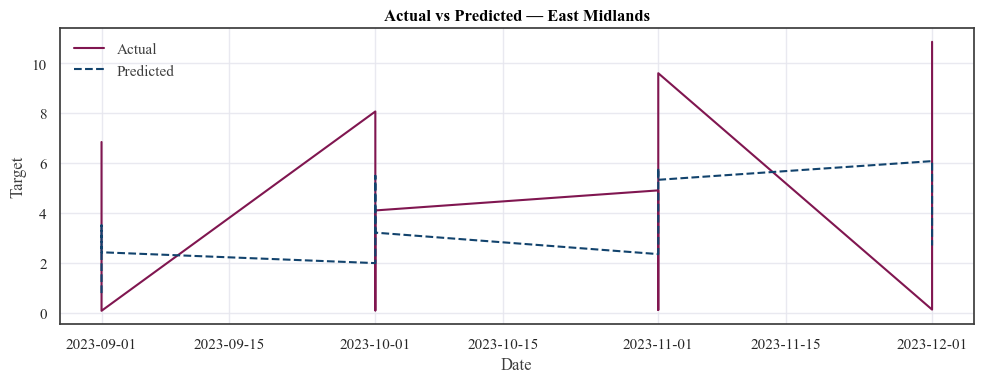

[East Midlands] Not enough points (12) for residual ACF. Skipping plot.
[East Midlands] Not enough points for Ljung–Box at requested lags [12, 24].

Diagnostics: East of England


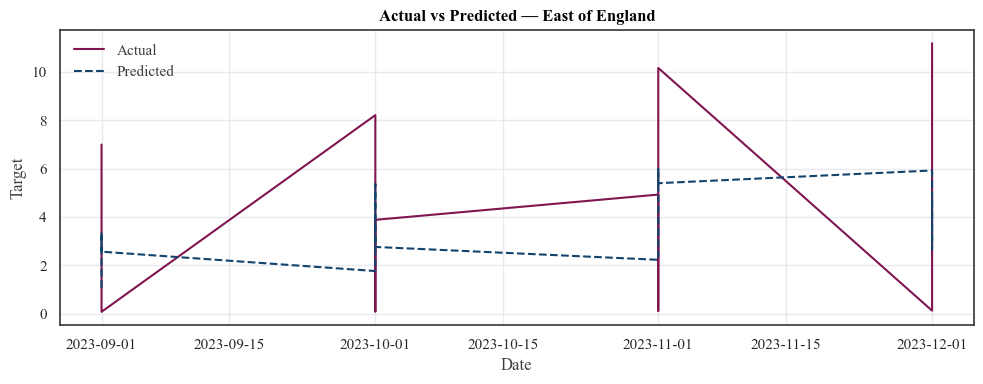

[East of England] Not enough points (12) for residual ACF. Skipping plot.
[East of England] Not enough points for Ljung–Box at requested lags [12, 24].

Diagnostics: Greater London


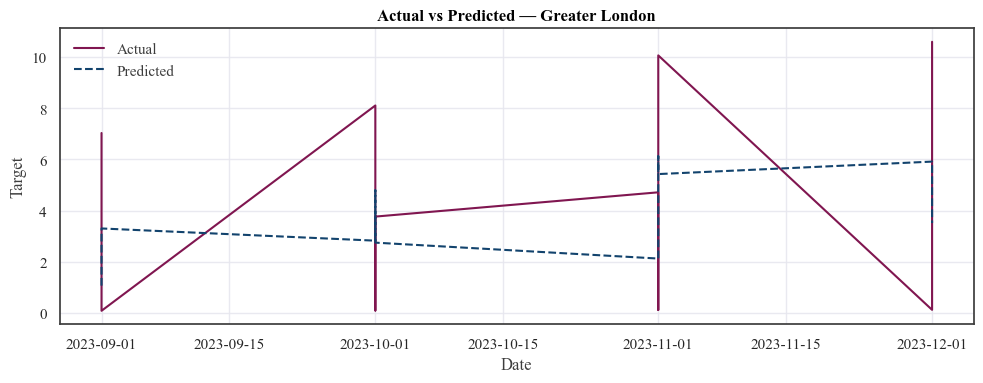

[Greater London] Not enough points (12) for residual ACF. Skipping plot.
[Greater London] Not enough points for Ljung–Box at requested lags [12, 24].

Diagnostics: North East


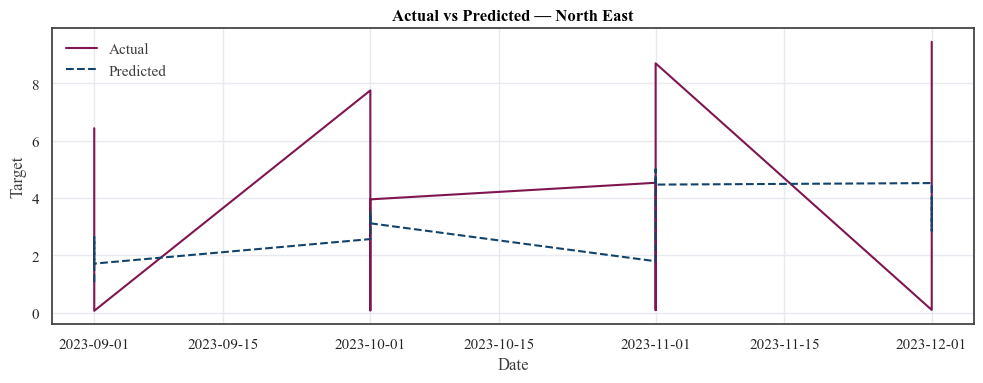

[North East] Not enough points (12) for residual ACF. Skipping plot.
[North East] Not enough points for Ljung–Box at requested lags [12, 24].

Diagnostics: North West


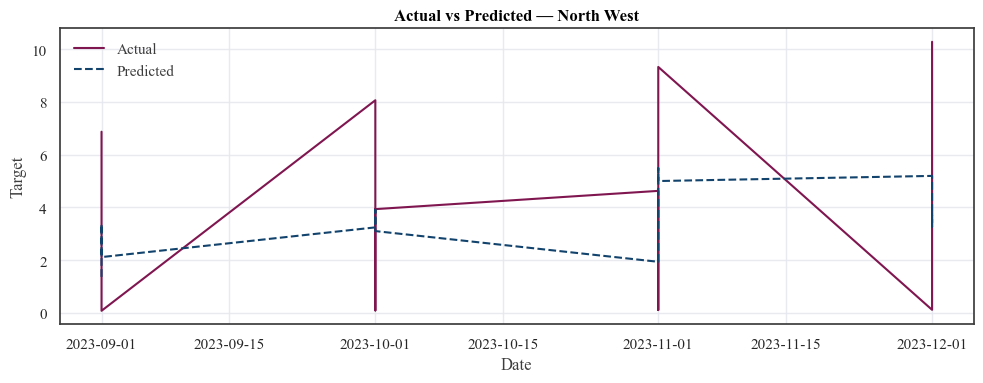

[North West] Not enough points (12) for residual ACF. Skipping plot.
[North West] Not enough points for Ljung–Box at requested lags [12, 24].

Diagnostics: Scotland


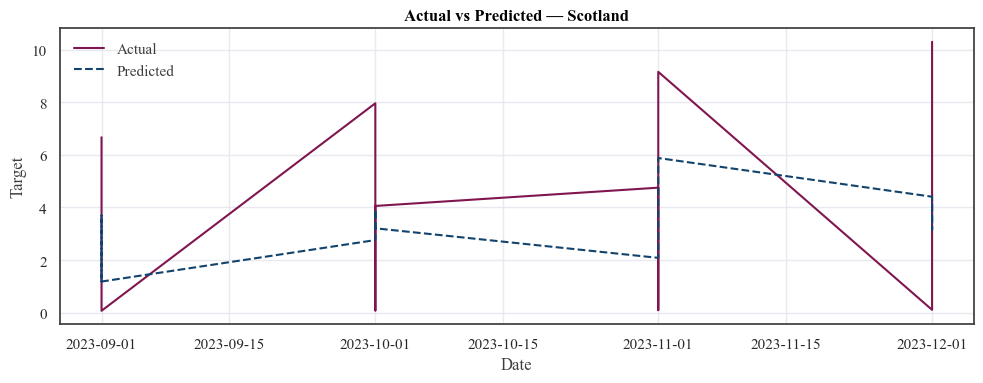

[Scotland] Not enough points (12) for residual ACF. Skipping plot.
[Scotland] Not enough points for Ljung–Box at requested lags [12, 24].

Diagnostics: South East


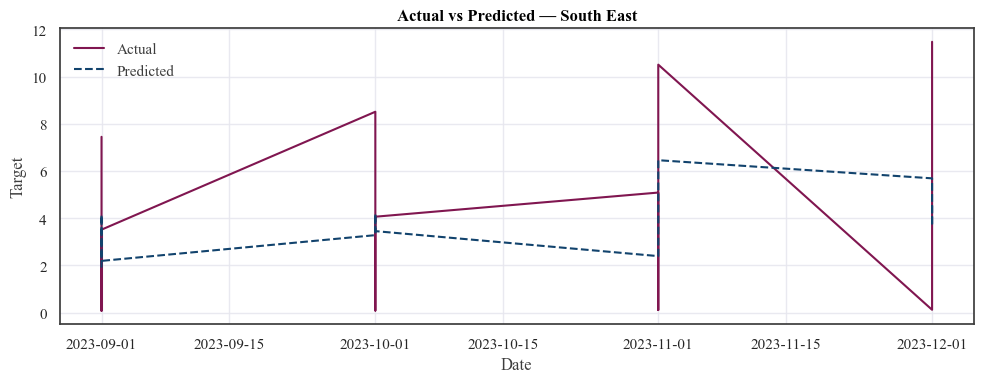

[South East] Not enough points (12) for residual ACF. Skipping plot.
[South East] Not enough points for Ljung–Box at requested lags [12, 24].

Diagnostics: South West


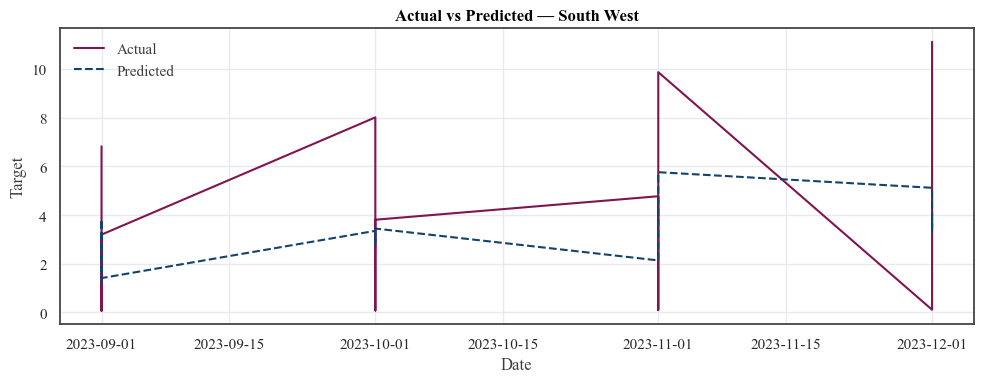

[South West] Not enough points (12) for residual ACF. Skipping plot.
[South West] Not enough points for Ljung–Box at requested lags [12, 24].

Diagnostics: Wales


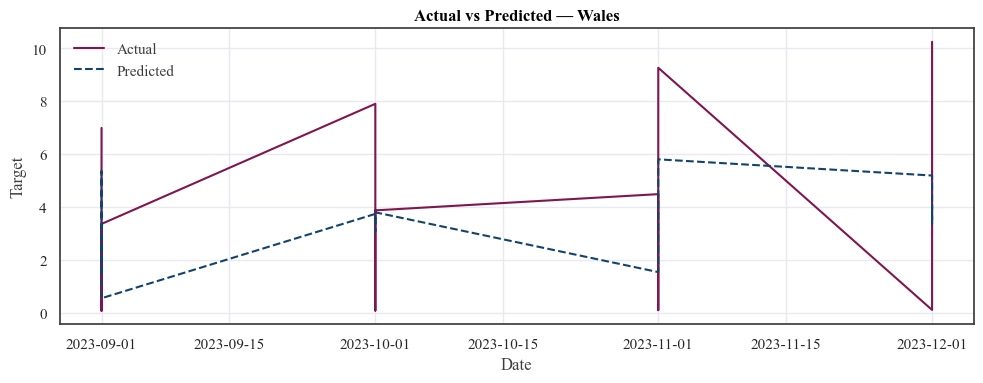

[Wales] Not enough points (12) for residual ACF. Skipping plot.
[Wales] Not enough points for Ljung–Box at requested lags [12, 24].

Diagnostics: West Midlands


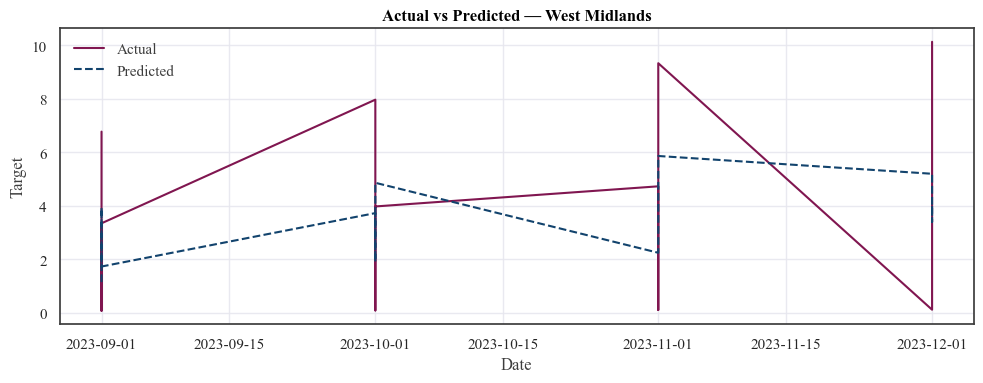

[West Midlands] Not enough points (12) for residual ACF. Skipping plot.
[West Midlands] Not enough points for Ljung–Box at requested lags [12, 24].

Diagnostics: Yorkshire


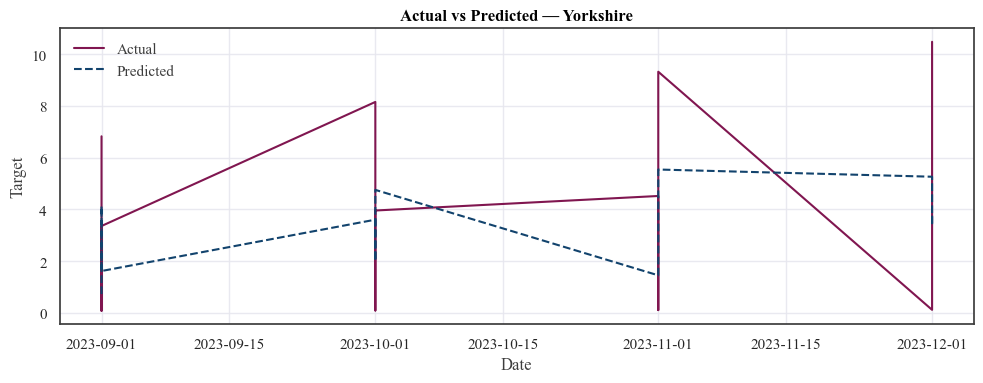

[Yorkshire] Not enough points (12) for residual ACF. Skipping plot.
[Yorkshire] Not enough points for Ljung–Box at requested lags [12, 24].


In [30]:

# ████████████████████████████████ ACTUAL VS PREDICTED AND RESIDIAL PLOTSA  ████████████████████████████████


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# Which lags to report for Ljung–Box (monthly data → check 12, 24)
LJUNG_BOX_LAGS: List[int] = [12, 24]
# Min points to attempt ACF/Ljung–Box
MIN_POINTS_FOR_DIAGNOSTICS: int = 24


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ INPUT DISCOVERY                                                          ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# Expect one of these forecast frames to already exist in the notebook:
# - sarimax_hddcdd_forecast_df  (from SARIMAX HDD/CDD code)
# - sarimax_forecast_df         (from generic SARIMAX code)
# - forecast_df                 (from ETS or seasonal naïve code)
def _discover_forecast_df() -> pd.DataFrame:
    """Find a forecast DataFrame in globals and validate columns."""
    candidates = ["sarimax_hddcdd_forecast_df", "sarimax_forecast_df", "forecast_df"]
    for name in candidates:
        if name in globals():
            df_fc = globals()[name]
            if isinstance(df_fc, pd.DataFrame):
                required = {"Region", "date"}
                # Accept either (actual, forecast) or (mean, yhat)
                if ({"actual", "forecast"} <= set(df_fc.columns)) or ({"mean", "yhat"} <= set(df_fc.columns)):
                    # Normalize column names to 'actual'/'forecast'
                    df_fc = df_fc.copy()
                    if "actual" not in df_fc.columns and "mean" in df_fc.columns:
                        df_fc.rename(columns={"mean": "actual"}, inplace=True)
                    if "forecast" not in df_fc.columns and "yhat" in df_fc.columns:
                        df_fc.rename(columns={"yhat": "forecast"}, inplace=True)
                    # Basic sanity
                    if required | {"actual", "forecast"} <= set(df_fc.columns):
                        return df_fc
    raise ValueError(
        "No forecast DataFrame found. Expected one of: "
        "'sarimax_hddcdd_forecast_df', 'sarimax_forecast_df', or 'forecast_df' "
        "with columns including Region, date, and actual/forecast."
    )


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CORE DIAGNOSTICS                                                         ║
# ╚══════════════════════════════════════════════════════════════════════════╝
def ljung_box_table(residuals: np.ndarray, lags: List[int]) -> pd.DataFrame:
    """Compute Ljung–Box Q-stat and p-values for specified lags."""
    lags = [lag for lag in lags if lag < len(residuals)]
    if not lags:
        return pd.DataFrame(columns=["lag", "lb_stat", "lb_pvalue"])
    lb = acorr_ljungbox(residuals, lags=lags, return_df=True)  # columns: lb_stat, lb_pvalue
    lb = lb.reset_index().rename(columns={"index": "lag"})
    return lb.loc[:, ["lag", "lb_stat", "lb_pvalue"]]


def plot_region_diagnostics(df_in: pd.DataFrame,
                            region: str,
                            ljung_lags: Optional[List[int]] = None) -> Dict[str, pd.DataFrame]:
    """
    For a single region: plot Actual vs Forecast, Residual ACF, and print Ljung–Box.
    Returns a dict of auxiliary tables for citation.
    """
    ljung_lags = ljung_lags or LJUNG_BOX_LAGS

    sub = df_in[df_in["Region"] == region].copy()
    if sub.empty:
        print(f"[{region}] No rows to plot.")
        return {}

    # Ensure proper typing/sorting
    sub["date"] = pd.to_datetime(sub["date"], errors="coerce")
    sub = sub.dropna(subset=["date"]).sort_values("date")
    sub["actual"] = pd.to_numeric(sub["actual"], errors="coerce")
    sub["forecast"] = pd.to_numeric(sub["forecast"], errors="coerce")
    sub = sub.dropna(subset=["actual", "forecast"])

    if len(sub) == 0:
        print(f"[{region}] After cleaning, no comparable actual/forecast rows.")
        return {}

    sub["residual"] = sub["actual"] - sub["forecast"]

    # ── Plot 1: Actual vs Forecast ──
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(sub["date"], sub["actual"], label="Actual")
    ax.plot(sub["date"], sub["forecast"], label="Predicted", linestyle="--")
    ax.set_title(f"Actual vs Predicted — {region}")
    ax.set_xlabel("Date")
    ax.set_ylabel("Target")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # ── Plot 2: Residual ACF (only if enough points) ──
    if len(sub) >= MIN_POINTS_FOR_DIAGNOSTICS:
        fig, ax = plt.subplots(figsize=(6, 3.5))
        plot_acf(sub["residual"], lags=min(36, len(sub) // 2), ax=ax)
        ax.set_title(f"Residual ACF — {region}")
        plt.tight_layout()
        plt.show()
    else:
        print(f"[{region}] Not enough points ({len(sub)}) for residual ACF. Skipping plot.")

    # ── Ljung–Box ──
    lb_tbl = ljung_box_table(sub["residual"].to_numpy(), ljung_lags)
    if not lb_tbl.empty:
        print(f"\nLjung–Box (residuals) — {region}")
        print(lb_tbl.to_string(index=False))
    else:
        print(f"[{region}] Not enough points for Ljung–Box at requested lags {ljung_lags}.")

    return {"ljung_box": lb_tbl, "data_used": sub}


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ EXECUTION                                                                ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# Step 1: Locate a forecast dataframe produced earlier
_fc = _discover_forecast_df()

# Step 2: Run diagnostics for each region (feel free to set a subset for speed)
regions = list(pd.unique(_fc["Region"]))
regions = sorted(regions)

# (Optional) Tight subset to preview faster:
# regions = ["Greater London", "Scotland"]

diagnostics_store: Dict[str, Dict[str, pd.DataFrame]] = {}

for r in regions:
    print("\n" + "=" * 80)
    print(f"Diagnostics: {r}")
    print("=" * 80)
    out = plot_region_diagnostics(_fc, r, ljung_lags=LJUNG_BOX_LAGS)
    diagnostics_store[r] = out

# Keep results for later citation (tables + cleaned series)
residual_diagnostics = diagnostics_store

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ INTERPRETATION HINTS                                                     ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# - If residual ACF has significant spikes (esp. at lag 12), model may be missing
#   seasonal structure — consider seasonal orders or different season length.
# - Ljung–Box small p-values (< 0.05) suggest residual autocorrelation remains;
#   try adjusting (p,q)(P,Q), adding differencing, or reconsidering exogenous set.
# - If patterns remain in Actual vs Predicted (systematic bias), consider trend
#   specification changes (add/multiplicative seasonality, drift, or level shifts).


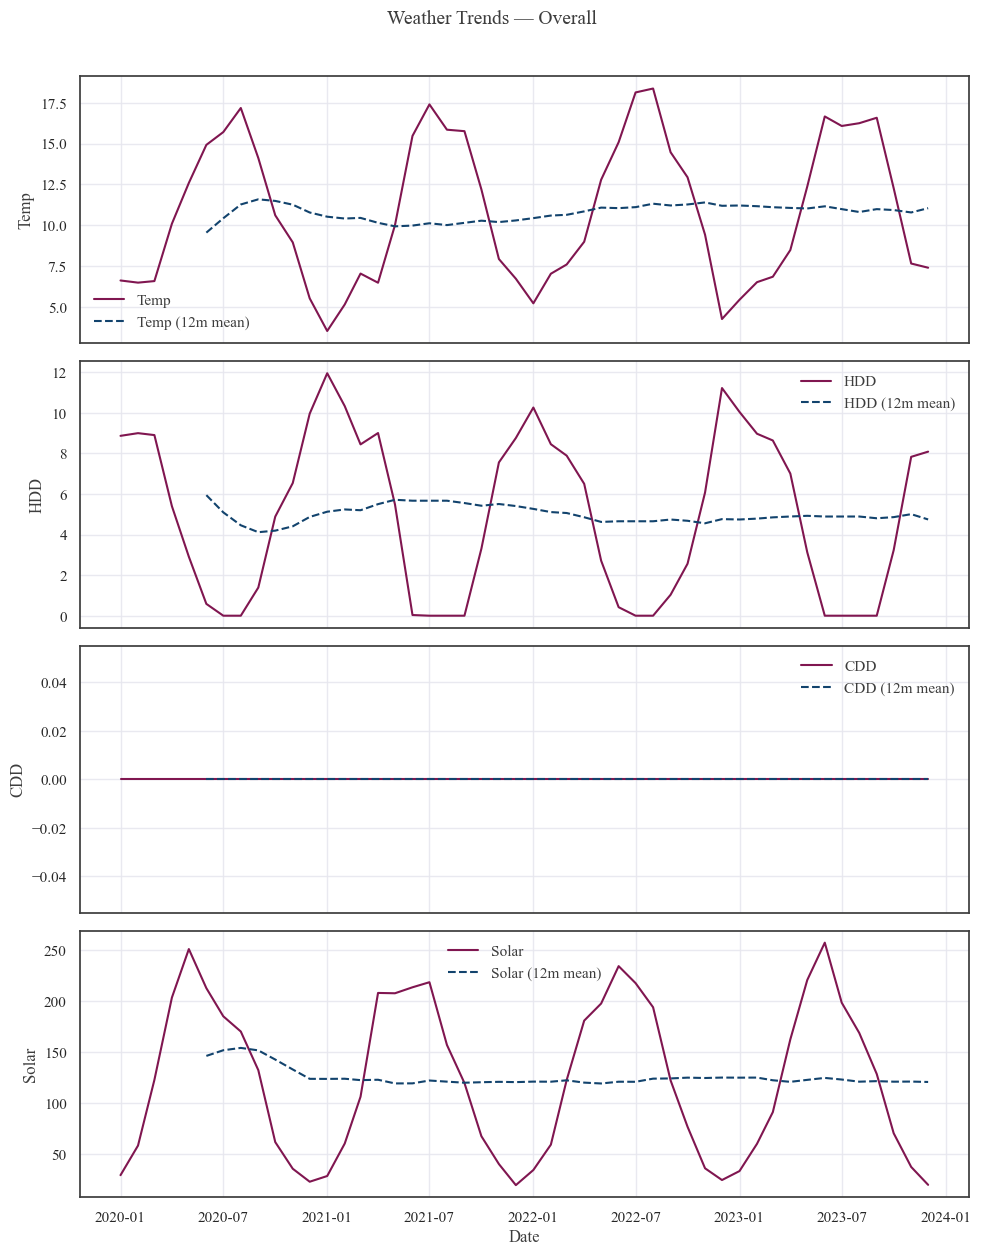

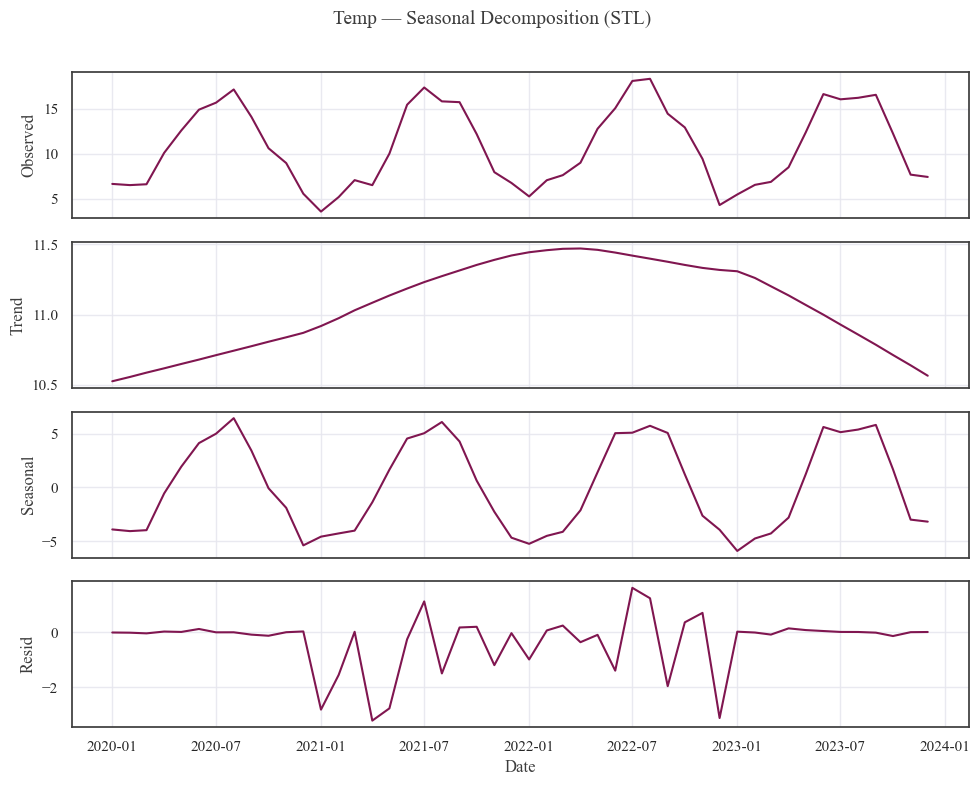

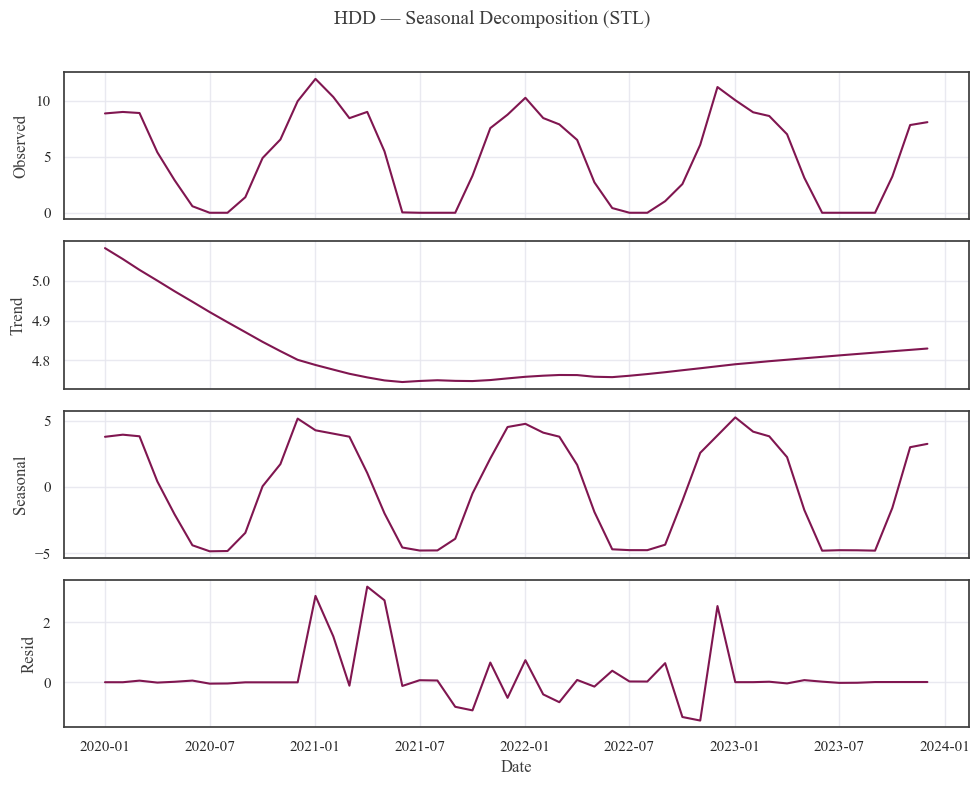

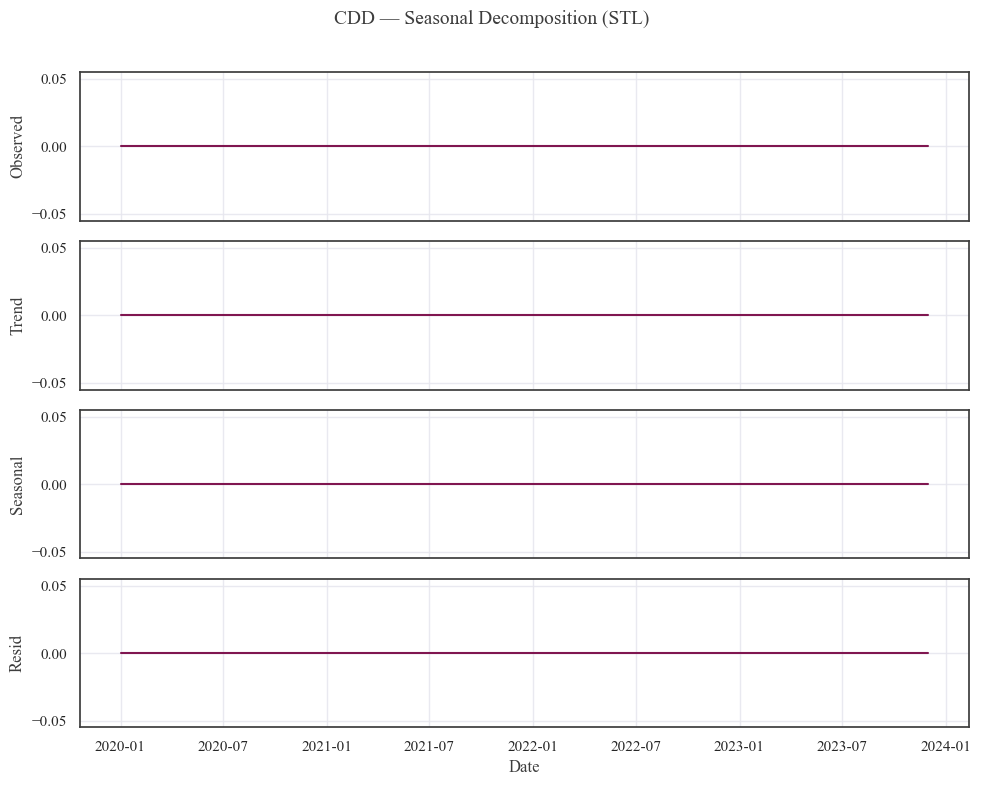

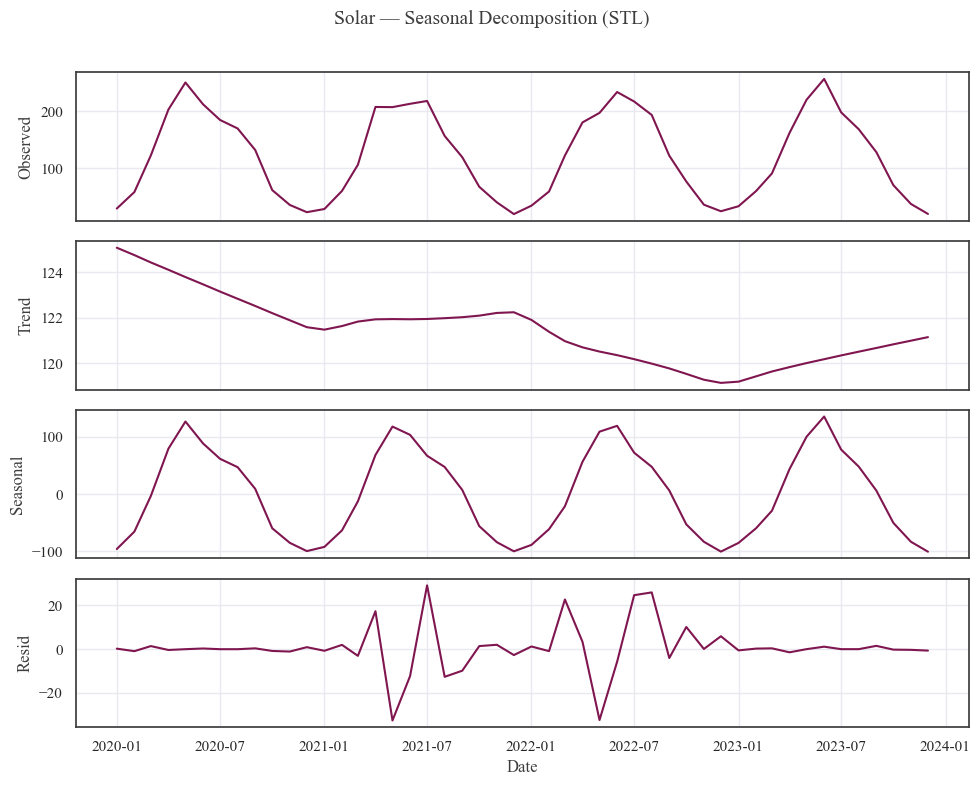


Weather Justification Stats (useful to cite when motivating HDD/CDD):

 mean_temp_mean  mean_temp_std  mean_temp_seasonal_amplitude_iqr  HDD_mean  HDD_std  HDD_seasonal_amplitude_iqr  CDD_mean  CDD_std  CDD_seasonal_amplitude_iqr  mean_solar_mean  mean_solar_std  mean_solar_seasonal_amplitude_iqr  spearman_temp_HDD  spearman_temp_CDD
         10.833          4.407                             1.059     4.946    4.019                       0.753     0.000    0.000                       0.000          122.360          76.373                             13.007             -0.994                NaN


In [31]:
# ████████████████████████████████ WEATHER TRENDS AND SEASONALITY ██████████████████████████████████

# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CONFIGURATION                                                            ║
# ╚══════════════════════════════════════════════════════════════════════════╝
DEFAULT_QUANTITY = "Electricity net"
DEFAULT_WEEKPART = "both"
DEFAULT_FUEL = "All"
DEFAULT_PV = "All"

SEASONAL_PERIODS = 12        # monthly data → yearly seasonality
BASE_TEMP_HDD = 15.5         # °C (UK-common heating base)
BASE_TEMP_CDD = 22.0         # °C (cooling base)


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ DATA CLASS                                                               ║
# ╚══════════════════════════════════════════════════════════════════════════╝
@dataclass
class WeatherConfig:
    """User-tunable config for weather trend & decomposition analysis."""
    region: Optional[str] = None            # None → overall average across regions
    show_solar: bool = True                 # include mean_solar if present
    method: str = "STL"                     # "STL" or "classical" (seasonal_decompose)
    seasonal_periods: int = SEASONAL_PERIODS
    base_temp_hdd: float = BASE_TEMP_HDD
    base_temp_cdd: float = BASE_TEMP_CDD


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ CORE                                                                      ║
# ╚══════════════════════════════════════════════════════════════════════════╝
class WeatherTrendsAndDecomp:
    """
    Prepare monthly weather series (temp/HDD/CDD/solar), visualize trends,
    and run seasonal decomposition to demonstrate strong annual seasonality.
    """

    def __init__(self, df: pd.DataFrame, config: WeatherConfig) -> None:
        self.raw = df.copy()
        self.cfg = config
        self.slice_: Optional[pd.DataFrame] = None
        self.series_: Dict[str, pd.Series] = {}

    # ------------------------------------------------------------------ #
    # Step 1: Slice & aggregate                                           #
    # ------------------------------------------------------------------ #
    def prepare(self) -> "WeatherTrendsAndDecomp":
        """Filter to baseline slice, keep monthly rows, aggregate per region or overall."""
        # Validate & filter a broad baseline context (matches rest of notebook)
        req = {"segmentation_variable_3", "aggregation_period", "quantity",
               "weekday_weekend", "primary_space_heating_fuel", "has_PV"}
        missing = req - set(self.raw.columns)
        if missing:
            raise KeyError(f"Missing required columns: {sorted(missing)}")

        d = self.raw[
            (self.raw["quantity"] == DEFAULT_QUANTITY)
            & (self.raw["weekday_weekend"] == DEFAULT_WEEKPART)
            & (self.raw["primary_space_heating_fuel"] == DEFAULT_FUEL)
            & (self.raw["has_PV"] == DEFAULT_PV)
        ].copy()

        # Keep only monthly rows (avoid 'YYYY' ambiguity)
        d["aggregation_period"] = d["aggregation_period"].astype(str)
        d = d[d["aggregation_period"].str.contains("-")].copy()

        # Parse date
        d["date"] = pd.to_datetime(d["aggregation_period"], errors="coerce")
        d = d.dropna(subset=["date"])

        # Ensure numeric weather columns if present
        for col in ["mean_temp", "mean_hdd", "mean_solar"]:
            if col in d.columns:
                d[col] = pd.to_numeric(d[col], errors="coerce")

        # Optionally restrict to a specific region slice
        if self.cfg.region:
            d = d[(d["segmentation_variable_3"] == "region") &
                  (d["segment_3_value"] == self.cfg.region)].copy()
        else:
            # Overall: average across regions when region segmentation is present
            if "segmentation_variable_3" in d.columns:
                # Prefer region records if they exist
                d = d[(d["segmentation_variable_3"] == "region") | (d["segmentation_variable_3"].isna())].copy()

        # Aggregate to one row per month (mean across available rows)
        agg_cols = [c for c in ["mean_temp", "mean_hdd", "mean_solar"] if c in d.columns]
        if not agg_cols:
            raise ValueError("No weather columns found (expected mean_temp/mean_hdd/mean_solar).")

        monthly = (d.groupby("date", as_index=False)[agg_cols].mean().sort_values("date"))

        # Derive HDD/CDD from mean_temp (if present). Fallback: use mean_hdd for HDD and set CDD=0.
        if "mean_temp" in monthly.columns:
            mt = monthly["mean_temp"].astype(float)
            monthly["HDD"] = (self.cfg.base_temp_hdd - mt).clip(lower=0.0)
            monthly["CDD"] = (mt - self.cfg.base_temp_cdd).clip(lower=0.0)
        else:
            # FIXME: No mean_temp; rely on provided mean_hdd if present (CDD=0).
            monthly["HDD"] = monthly.get("mean_hdd", 0.0)
            monthly["CDD"] = 0.0

        # Store cleaned slice & time-indexed series
        monthly = monthly.set_index("date").asfreq("MS")  # ensure monthly start
        self.slice_ = monthly

        # Primary series for decomposition (choose order of preference)
        self.series_["Temp"] = monthly["mean_temp"] if "mean_temp" in monthly else None
        self.series_["HDD"] = monthly["HDD"]
        self.series_["CDD"] = monthly["CDD"]
        if self.cfg.show_solar and "mean_solar" in monthly:
            self.series_["Solar"] = monthly["mean_solar"]

        return self

    # ------------------------------------------------------------------ #
    # Step 2: Quick trends (targets drivers used for HDD/CDD)            #
    # ------------------------------------------------------------------ #
    def plot_trends(self) -> None:
        """Plot monthly trends for Temp/HDD/CDD(/Solar) with a 12‑month mean."""
        if self.slice_ is None:
            raise ValueError("Call .prepare() first.")

        # Select available series
        to_plot = {k: v for k, v in self.series_.items() if v is not None}

        n = len(to_plot)
        if n == 0:
            raise ValueError("No weather series available to plot.")

        # NOTE: Matplotlib only; no custom colors as per project guidance.
        fig, axes = plt.subplots(n, 1, figsize=(10, 3.2 * n), sharex=True)
        if n == 1:
            axes = [axes]

        title_region = f" — {self.cfg.region}" if self.cfg.region else " — Overall"
        fig.suptitle(f"Weather Trends{title_region}", fontsize=14, y=0.98)

        for ax, (name, s) in zip(axes, to_plot.items()):
            s = s.astype(float)
            ax.plot(s.index, s.values, label=name)
            # Add 12‑month rolling mean for context (baseline/seasonality)
            ax.plot(s.index, s.rolling(12, min_periods=6).mean(), linestyle="--", label=f"{name} (12m mean)")
            ax.set_ylabel(name)
            ax.legend(loc="best")

        axes[-1].set_xlabel("Date")
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

    # ------------------------------------------------------------------ #
    # Step 3: Seasonal decomposition                                     #
    # ------------------------------------------------------------------ #
    def decompose(self, targets: Optional[List[str]] = None) -> Dict[str, dict]:
        """
        Run seasonal decomposition on selected weather series.
        Returns dict of {series_name: {trend, seasonal, resid}} for citation.
        """
        if self.slice_ is None:
            raise ValueError("Call .prepare() first.")

        results: Dict[str, dict] = {}
        candidates = {k: v for k, v in self.series_.items() if v is not None}
        if not candidates:
            return results

        if targets:
            candidates = {k: v for k, v in candidates.items() if k in targets and v is not None}

        for name, s in candidates.items():
            s = s.astype(float).interpolate(limit_direction="both")
            # Require enough data points
            if s.dropna().shape[0] < (self.cfg.seasonal_periods * 2):
                # NOTE: At least 2 seasons give a cleaner decomposition.
                continue

            if self.cfg.method.upper() == "STL":
                stl = STL(s, period=self.cfg.seasonal_periods, robust=True)
                res = stl.fit()
                comp = {"trend": res.trend, "seasonal": res.seasonal, "resid": res.resid}
            else:
                # Classical additive decomposition as a cross-check
                res = seasonal_decompose(s, model="additive", period=self.cfg.seasonal_periods, extrapolate_trend="freq")
                comp = {"trend": res.trend, "seasonal": res.seasonal, "resid": res.resid}

            # Plot components
            fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
            fig.suptitle(f"{name} — Seasonal Decomposition ({self.cfg.method.upper()})", fontsize=14, y=0.98)
            axes[0].plot(s.index, s.values);            axes[0].set_ylabel("Observed")
            axes[1].plot(comp["trend"].index, comp["trend"].values);      axes[1].set_ylabel("Trend")
            axes[2].plot(comp["seasonal"].index, comp["seasonal"].values);axes[2].set_ylabel("Seasonal")
            axes[3].plot(comp["resid"].index, comp["resid"].values);      axes[3].set_ylabel("Resid")
            axes[3].set_xlabel("Date")
            plt.tight_layout(rect=[0, 0, 1, 0.97])
            plt.show()

            results[name] = comp

        return results

    # ------------------------------------------------------------------ #
    # Step 4: Quick justification stats                                  #
    # ------------------------------------------------------------------ #
    def justify_hdd_cdd(self) -> pd.DataFrame:
        """
        Provide simple stats & correlations to justify HDD/CDD:
        - Corr(Temp, HDD) should be strongly negative (if Temp present)
        - Corr(Temp, CDD) strongly positive above cooling base
        - Report means & seasonal amplitude ranges
        """
        if self.slice_ is None:
            raise ValueError("Call .prepare() first.")

        s = self.slice_
        out = {}

        # Basic moments
        for col in ["mean_temp", "HDD", "CDD", "mean_solar"]:
            if col in s.columns:
                x = s[col].astype(float)
                out[f"{col}_mean"] = float(np.nanmean(x))
                out[f"{col}_std"] = float(np.nanstd(x, ddof=1))
                # Seasonal amplitude: interquartile range by calendar month
                month_iqr = (
                    x.groupby(x.index.month)
                    .agg(lambda z: np.nanpercentile(z, 75) - np.nanpercentile(z, 25))
                    .mean()
                )
                out[f"{col}_seasonal_amplitude_iqr"] = float(month_iqr)

        # Correlations with Temp (if available)
        if "mean_temp" in s.columns:
            t = s["mean_temp"].astype(float)
            for col in ["HDD", "CDD"]:
                if col in s.columns:
                    r = pd.Series(t).corr(pd.Series(s[col].astype(float)), method="spearman")
                    out[f"spearman_temp_{col}"] = float(r)

        return pd.DataFrame([out])


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║ EXECUTION                                                                ║
# ╚══════════════════════════════════════════════════════════════════════════╝
# Step 0: Load if not already in memory
try:
    df  # noqa: F821
except NameError:
    df = pd.read_csv("/mnt/data/forcasting.csv")

# Configure here:
wcfg = WeatherConfig(
    region=None,         # e.g., "Greater London" for a single-region view
    show_solar=True,
    method="STL",        # "STL" (robust) or "classical"
    seasonal_periods=12,
    base_temp_hdd=BASE_TEMP_HDD,
    base_temp_cdd=BASE_TEMP_CDD
)

wt = WeatherTrendsAndDecomp(df, wcfg)
wt.prepare()
wt.plot_trends()

# Decompose key drivers (Temp/HDD/CDD/Solar if available)
decomp_results = wt.decompose(targets=["Temp", "HDD", "CDD", "Solar"])

# Quick justification table for the write-up (store and print)
just_tbl = wt.justify_hdd_cdd()
pd.set_option("display.float_format", "{:,.3f}".format)
print("\nWeather Justification Stats (useful to cite when motivating HDD/CDD):\n")
print(just_tbl.to_string(index=False))

# NOTE:
# - Temp should exhibit strong annual seasonality; HDD peaks in cold months; CDD near zero in UK.
# - Strong |Spearman(Temp,HDD)| and Spearman(Temp,CDD) (pos above base) justify HDD/CDD as derived drivers.
# - Use region=None for overall trends, or set a region name to show local weather seasonality.
# - Decomposition plots (trend/seasonal/resid) can be pasted into the methods/results section.


In [32]:
# ████████████████████████████████  ELECTRICITY PIPELINE  ██████████████████████████████████


from __future__ import annotations


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║                               CONFIGURATION                              ║
# ╚══════════════════════════════════════════════════════════════════════════╝

@dataclass
class DataConfig:
    """
    Input & column configuration for the tall, segmented CSV.
    This mirrors the ERP export layout.
    """
    # File
    path: str

    # Column names in your file
    date_col: str = "aggregation_period"
    region_flag_col: str = "segmentation_variable_3"
    region_value_col: str = "segment_3_value"
    quantity_col: str = "quantity"
    unit_col: str = "unit"
    target_col: str = "mean"
    temp_col: Optional[str] = "mean_temp"  # optional (if you have monthly temp)

    # Options
    quantity_filter: Optional[str] = "Electricity net"
    unit_filter: Optional[str] = "kWh/day"
    base_temp_c: float = 18.0  # HDD/CDD base
    freq: str = "MS"           # monthly start


@dataclass
class CVConfig:
    """Cross-validation shape for monthly data."""
    seasonal_periods: int = 12
    n_splits: int = 2        # last N folds
    test_horizon: int = 12   # months per fold
    min_train: int = 24      # months before first test starts


@dataclass
class SARIMAXConfig:
    """Search grid for SARIMAX (kept tiny for speed)."""
    seasonal_periods: int = 12
    order_grid: Tuple[Tuple[int, ...], Tuple[int, ...], Tuple[int, ...]] = (
        (0, 1, 2),  # p
        (0, 1),     # d
        (0, 1, 2),  # q
    )
    seasonal_order_grid: Tuple[Tuple[int, ...], Tuple[int, ...], Tuple[int, ...]] = (
        (0, 1),     # P
        (0, 1),     # D
        (0, 1),     # Q
    )
    max_candidates: int = 40
    enforce_stationarity: bool = True
    enforce_invertibility: bool = True


@dataclass
class PipelineConfig:
    data: DataConfig
    cv: CVConfig = field(default_factory=CVConfig)
    sarimax: SARIMAXConfig = field(default_factory=SARIMAXConfig)
    use_ets: bool = True
    use_sarimax: bool = True
    use_seasonal_naive: bool = True
    exog_strategy: str = "climatology"  # how to fill future HDD/CDD in CV


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║                              DATA UTILITIES                              ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class DataLoader:
    """
    Loads the tall, segmented CSV; filters to region rows; selects a (quantity, unit)
    slice; parses mixed-format dates; returns tidy monthly df: [date, region, y, temp].
    """

    DATE_SYNONYMS = (
        "aggregation_period", "aggregated_period", "date", "month", "period", "dt"
    )

    def __init__(self, cfg: DataConfig) -> None:
        self.cfg = cfg

    @staticmethod
    def _parse_month_start(series: pd.Series) -> pd.Series:
        """Parse YYYY / YYYY-MM / YYYY/MM / YYYY-MM-DD / 'YYYY Qn' → month start."""
        def norm(s) -> pd.Timestamp:
            t = str(s).strip() if pd.notna(s) else ""
            if not t or t.lower() in {"nan", "none"}:
                return pd.NaT
            if re.fullmatch(r"\d{4}", t):                # YYYY
                t = f"{t}-01-01"
            elif re.fullmatch(r"\d{4}-\d{1,2}", t):      # YYYY-M(M)
                y, m = t.split("-")
                t = f"{y}-{int(m):02d}-01"
            elif re.fullmatch(r"\d{4}/\d{1,2}", t):      # YYYY/M(M)
                y, m = t.split("/")
                t = f"{y}-{int(m):02d}-01"
            elif re.fullmatch(r"\d{4}\s*[Qq][1-4]", t):  # YYYY Qn
                y, q = t[:4], int(t[-1])
                first_month = {1: 1, 2: 4, 3: 7, 4: 10}[q]
                t = f"{y}-{first_month:02d}-01"
            return pd.to_datetime(t, errors="coerce")

        out = series.map(norm)
        return out.dt.to_period("M").dt.start_time

    def _find_date_col(self, cols: List[str]) -> str:
        if self.cfg.date_col in cols:
            return self.cfg.date_col
        for cand in self.DATE_SYNONYMS:
            if cand in cols:
                print(f"[INFO] Using inferred date column: '{cand}'")
                return cand
        raise KeyError(f"Date column not found. Have: {cols}")

    def load(self) -> pd.DataFrame:
        df = pd.read_csv(self.cfg.path)

        # --- Region extraction (segmentation → region) ---
        if self.cfg.region_flag_col in df.columns and self.cfg.region_value_col in df.columns:
            mask_region = (
                df[self.cfg.region_flag_col]
                .astype(str)
                .str.strip()
                .str.lower()
                .eq("region")
            )
            df = df.loc[mask_region].copy()
            df = df.rename(columns={self.cfg.region_value_col: "region"})
        elif "region" in df.columns:
            # already present
            pass
        else:
            raise KeyError(
                "Could not find region columns. Expected segmentation_variable_3/segment_3_value "
                "or a 'region' column."
            )

        # Clean region labels and drop placeholders (goodbye, string 'nan')
        df["region"] = df["region"].astype(str).str.strip()
        df["region"] = df["region"].replace({"nan": np.nan, "None": np.nan, "": np.nan})
        df = df[df["region"].notna()]

        # --- Choose (quantity, unit) slice ---
        for col in [self.cfg.quantity_col, self.cfg.unit_col, self.cfg.target_col]:
            if col not in df.columns:
                raise KeyError(f"Missing required column '{col}'. Got: {list(df.columns)}")

        if self.cfg.quantity_filter and self.cfg.unit_filter:
            q, u = self.cfg.quantity_filter, self.cfg.unit_filter
            df = df[(df[self.cfg.quantity_col] == q) & (df[self.cfg.unit_col] == u)].copy()
            if df.empty:
                raise ValueError(f"No rows for quantity='{q}', unit='{u}'.")
            print(f"[INFO] Using metric: quantity='{q}', unit='{u}'")
        else:
            cand = (
                df.dropna(subset=[self.cfg.target_col])
                .groupby([self.cfg.quantity_col, self.cfg.unit_col])
                .size()
                .sort_values(ascending=False)
            )
            if cand.empty:
                raise ValueError("No non-null target values in any (quantity, unit) slice.")
            q, u = cand.index[0]
            print(f"[INFO] Auto-selected metric: quantity='{q}', unit='{u}'")
            df = df[(df[self.cfg.quantity_col] == q) & (df[self.cfg.unit_col] == u)].copy()

        # --- Standardize names ---
        date_src = self._find_date_col(list(df.columns))
        df = df.rename(columns={date_src: "date", self.cfg.target_col: "y"})

        # Optional temperature
        if self.cfg.temp_col and self.cfg.temp_col in df.columns:
            df = df.rename(columns={self.cfg.temp_col: "temp"})
            df["temp"] = pd.to_numeric(df["temp"], errors="coerce")
        else:
            df["temp"] = np.nan

        # --- Parse dates robustly ---
        df["date"] = self._parse_month_start(df["date"])
        bad = int(df["date"].isna().sum())
        if bad:
            ex = df.loc[df["date"].isna()].iloc[:5, :]
            raise ValueError(
                f"Found {bad} unparsable dates in '{date_src}'. "
                f"Examples:\n{ex[[date_src]].to_string(index=False)}"
            )

        # --- Keep tidy cols ---
        df["y"] = pd.to_numeric(df["y"], errors="coerce")
        tidy = df[["date", "region", "y", "temp"]].copy()

        # 1) Collapse to one row per (region, date) BEFORE reindexing.
        out = (
            tidy.groupby(["region", "date"], as_index=False)
            .agg(y=("y", "mean"), temp=("temp", "mean"))
            .sort_values(["region", "date"])
        )

        # 2) Reindex per region to a complete monthly range (unique index → safe reindex).
        def complete(g: pd.DataFrame) -> pd.DataFrame:
            region_val = g["region"].iloc[0]  # capture before inner groupby
            g = g.groupby("date", as_index=False).agg(y=("y", "mean"), temp=("temp", "mean"))
            idx = pd.date_range(g["date"].min(), g["date"].max(), freq=self.cfg.freq)
            gi = g.set_index("date").reindex(idx)
            gi.index.name = "date"
            g2 = gi.reset_index()
            g2["region"] = region_val
            return g2[["date", "region", "y", "temp"]]

        out = out.groupby("region", group_keys=False).apply(complete).reset_index(drop=True)

        # sanity
        if "region" not in out.columns or out["region"].isna().any():
            raise RuntimeError("[DataLoader] region column missing/NaN after completion.")

        return out


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║                                FEATURES                                  ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class FeatureEngineer:
    """Creates HDD/CDD and safe exogenous plans for CV (no leakage)."""

    def __init__(self, base_temp_c: float = 18.0, seasonal_periods: int = 12) -> None:
        self.base = base_temp_c
        self.m = seasonal_periods

    def add_hdd_cdd(self, df: pd.DataFrame) -> pd.DataFrame:
        out = df.copy()
        if out["temp"].notna().any():
            out["HDD"] = (self.base - out["temp"]).clip(lower=0.0)
            out["CDD"] = (out["temp"] - self.base).clip(lower=0.0)
        else:
            out["HDD"] = np.nan
            out["CDD"] = np.nan
        out["HDD_l1"] = out.groupby("region")["HDD"].shift(1)
        out["CDD_l1"] = out.groupby("region")["CDD"].shift(1)
        out["month"] = out["date"].dt.month
        return out

    def exog_climatology(self, train: pd.DataFrame, horizon: int) -> pd.DataFrame:
        """
        Build future exog by repeating per-region monthly means of HDD/CDD,
        then create lags with the *last observed* train HDD/CDD as seeds.
        RETURNS: [date, region, HDD_l1, CDD_l1] with NO NaNs.
        """
        # Expect train has columns: date, region, HDD, CDD, month
        last_date = pd.to_datetime(train["date"]).max()
        future_idx = pd.date_range(last_date + pd.offsets.MonthBegin(),
                                   periods=horizon, freq="MS")
        regions = pd.Index(train["region"].unique())

        # Monthly climatology by region
        clim = (train.groupby(["region", "month"])[["HDD", "CDD"]]
                .mean().reset_index())

        fut = (pd.MultiIndex.from_product([regions, future_idx],
                                          names=["region", "date"])
               .to_frame(index=False))
        fut["month"] = pd.DatetimeIndex(fut["date"]).month
        fut = fut.merge(clim, on=["region", "month"], how="left")

        # Compute lags per region without NaNs:
        def _seed_and_lag(g: pd.DataFrame) -> pd.DataFrame:
            reg = g["region"].iloc[0]
            # last observed from train (fallback to 0)
            hdd_hist = float(train.loc[train["region"] == reg, "HDD"].dropna().iloc[-1]) \
                if train.loc[train["region"] == reg, "HDD"].notna().any() else 0.0
            cdd_hist = float(train.loc[train["region"] == reg, "CDD"].dropna().iloc[-1]) \
                if train.loc[train["region"] == reg, "CDD"].notna().any() else 0.0

            hdd_seq = np.concatenate([[hdd_hist], g["HDD"].to_numpy()])
            cdd_seq = np.concatenate([[cdd_hist], g["CDD"].to_numpy()])

            g = g.copy()
            g["HDD_l1"] = pd.Series(hdd_seq[:-1], index=g.index)
            g["CDD_l1"] = pd.Series(cdd_seq[:-1], index=g.index)
            return g

        fut = fut.groupby("region", group_keys=False).apply(_seed_and_lag)

        # Final cleanup: replace any residual NaNs/Infs just in case
        fut = fut.replace([np.inf, -np.inf], np.nan)
        for col in ["HDD_l1", "CDD_l1"]:
            if fut[col].isna().any():
                fut[col] = fut.groupby(["region", "month"])[col].transform(
                    lambda s: s.fillna(s.mean())
                ).fillna(0.0)

        return fut[["date", "region", "HDD_l1", "CDD_l1"]]


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║                                METRICS                                   ║
# ╚══════════════════════════════════════════════════════════════════════════╝

def mae(y_true, y_pred):
    return np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred)))


def rmse(y_true, y_pred):
    return np.sqrt(np.mean((np.asarray(y_true) - np.asarray(y_pred)) ** 2))


def smape(y_true, y_pred, eps: float = 1e-8):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    denom = (np.abs(y_true) + np.abs(y_pred)).clip(min=eps)
    return 100 * np.mean(2.0 * np.abs(y_pred - y_true) / denom)


def mase(y_true, y_pred, y_insample, m: int = 12):
    """Scale error by in-sample seasonal naive MAE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    y_insample = np.asarray(y_insample)
    diffs = np.abs(y_insample[m:] - y_insample[:-m])
    scale = np.mean(diffs) if len(diffs) else np.nan
    return np.mean(np.abs(y_true - y_pred) / scale)


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║                                 MODELS                                   ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class BaseTSModel:
    name: str = "base"

    def fit(self, y: pd.Series, exog: Optional[pd.DataFrame] = None):
        raise NotImplementedError

    def predict(self, steps: int, exog_future: Optional[pd.DataFrame] = None) -> pd.Series:
        raise NotImplementedError

    def predict_in_sample(self) -> pd.Series:
        raise NotImplementedError

    def predict_interval(self, steps: int, exog_future=None, alpha: float = 0.05):
        raise NotImplementedError


class SeasonalNaive(BaseTSModel):
    name = "SeasonalNaive"

    def __init__(self, m: int = 12):
        self.m = m
        self.train_: Optional[pd.Series] = None
        self.resid_: Optional[np.ndarray] = None

    def fit(self, y: pd.Series, exog: Optional[pd.DataFrame] = None):
        self.train_ = y.copy()
        # Residuals vs lag-m (drop head); for later PI (very approximate).
        if len(y) > self.m:
            resid = y[self.m:].to_numpy() - y[:-self.m].to_numpy()
            self.resid_ = resid
        else:
            self.resid_ = np.array([0.0])

    def predict(self, steps: int, exog_future=None) -> pd.Series:
        assert self.train_ is not None
        y = self.train_.to_numpy()
        preds = [y[-self.m + (i % self.m)] for i in range(steps)]
        idx = pd.date_range(self.train_.index[-1] + pd.offsets.MonthBegin(),
                            periods=steps, freq="MS")
        return pd.Series(preds, index=idx)

    def predict_in_sample(self) -> pd.Series:
        assert self.train_ is not None
        return self.train_.shift(self.m)

    def predict_interval(self, steps: int, exog_future=None, alpha: float = 0.05):
        preds = self.predict(steps)
        se = 0.0 if self.resid_ is None or len(self.resid_) == 0 else float(np.std(self.resid_))
        z = 1.96 if math.isclose(alpha, 0.05) else 1.0
        lower = preds - z * se
        upper = preds + z * se
        return preds, lower, upper


class ETSModel(BaseTSModel):
    name = "ETS"

    def __init__(self, seasonal: str = "add", trend: Optional[str] = "add",
                 damped_trend: bool = True, m: int = 12):
        self.seasonal = seasonal
        self.trend = trend
        self.damped = damped_trend
        self.m = m
        self.fitted_ = None
        self.res_: Optional[pd.Series] = None

    def fit(self, y: pd.Series, exog=None):
        model = ExponentialSmoothing(
            y, seasonal=self.seasonal, seasonal_periods=self.m,
            trend=self.trend, damped_trend=self.damped,
            initialization_method="estimated"
        )
        self.fitted_ = model.fit(optimized=True, use_brute=True)
        self.res_ = self.fitted_.resid
        return self

    def predict(self, steps: int, exog_future=None) -> pd.Series:
        return self.fitted_.forecast(steps)

    def predict_in_sample(self) -> pd.Series:
        return self.fitted_.fittedvalues

    def predict_interval(self, steps: int, exog_future=None, alpha: float = 0.05):
        pred = self.predict(steps)
        se = float(np.std(self.res_)) if self.res_ is not None else 0.0
        z = 1.96 if math.isclose(alpha, 0.05) else 1.0
        lower = pred - z * se
        upper = pred + z * se
        return pred, lower, upper


class SARIMAXModel(BaseTSModel):
    """
    Robust SARIMAX with:
      - anchor orders first (fast convergence),
      - strict→relaxed enforcement,
      - optimizer fallback (lbfgs → Nelder–Mead),
      - exog cleaning (ffill/bfill/means).
    """
    name = "SARIMAX"

    def __init__(self, cfg: SARIMAXConfig, m: int = 12):
        self.cfg = cfg
        self.m = m
        self.best_ = None
        self.result_ = None

    def _candidate_orders(self) -> List[Tuple[Tuple[int, int, int], Tuple[int, int, int, int]]]:
        anchors = [((0, 1, 1), (0, 1, 1, self.m)),
                   ((1, 1, 1), (0, 1, 1, self.m))]
        p, d, q = self.cfg.order_grid
        P, D, Q = self.cfg.seasonal_order_grid
        grid = [((pi, di, qi), (Pi, Di, Qi, self.m))
                for pi in p for di in d for qi in q
                for Pi in P for Di in D for Qi in Q]
        seen = set()
        orders = []
        for cand in anchors + grid:
            if cand not in seen:
                seen.add(cand)
                orders.append(cand)
        return orders[: self.cfg.max_candidates]

    @staticmethod
    def _ok_series(y: pd.Series) -> bool:
        yv = y.dropna().values
        return (yv.size >= 18) and (np.nanstd(yv) > 1e-8)

    @staticmethod
    def _clean_exog(x: Optional[pd.DataFrame]) -> Optional[pd.DataFrame]:
        if x is None:
            return None
        x = x.copy()
        x = x.ffill().bfill()
        if x.isna().any().any():
            x = x.fillna(x.mean(numeric_only=True))
        return x

    def fit(self, y: pd.Series, exog: Optional[pd.DataFrame] = None):
        if not self._ok_series(y):
            raise RuntimeError("y has too few points or near-zero variance for SARIMAX.")
        exog = self._clean_exog(exog)

        best_aic = np.inf
        best_mod = None
        best_res = None

        for order, sorder in self._candidate_orders():
            for strict in (True, False):
                try:
                    mod = SARIMAX(
                        y,
                        exog=exog,
                        order=order,
                        seasonal_order=sorder,
                        enforce_stationarity=self.cfg.enforce_stationarity if strict else False,
                        enforce_invertibility=self.cfg.enforce_invertibility if strict else False,
                        trend="n",
                    )
                    try:
                        res = mod.fit(method="lbfgs", disp=False, maxiter=300)
                    except Exception:
                        res = mod.fit(method="nm", disp=False, maxiter=400)
                    if np.isfinite(res.aic) and (res.aic < best_aic):
                        best_aic = float(res.aic)
                        best_mod = mod
                        best_res = res
                except Exception:
                    continue

        if best_mod is None:
            raise RuntimeError("No SARIMAX candidate converged.")
        self.best_ = best_mod
        self.result_ = best_res
        return self

    def predict(self, steps: int, exog_future: Optional[pd.DataFrame] = None) -> pd.Series:
        exog_future = self._clean_exog(exog_future)
        fc = self.result_.get_forecast(steps=steps, exog=exog_future)
        return fc.predicted_mean

    def predict_in_sample(self) -> pd.Series:
        return self.result_.fittedvalues

    def predict_interval(self, steps: int, exog_future=None, alpha: float = 0.05):
        exog_future = self._clean_exog(exog_future)
        fc = self.result_.get_forecast(steps=steps, exog=exog_future)
        ci = fc.conf_int(alpha=alpha)
        pred = fc.predicted_mean
        return pred, ci.iloc[:, 0], ci.iloc[:, 1]


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║                           CROSS-VALIDATION                               ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class ExpandingWindowCV:
    """Expanding train, fixed test horizon, last n_splits folds by date."""

    def __init__(self, n_splits: int, test_h: int, min_train: int):
        self.n_splits = n_splits
        self.test_h = test_h
        self.min_train = min_train

    def split(self, dates: pd.DatetimeIndex) -> List[Tuple[pd.Timestamp, pd.Timestamp]]:
        dates = pd.Index(sorted(dates.unique()))
        n = len(dates)
        folds = []
        end_positions = [n - (i * self.test_h) for i in range(self.n_splits, 0, -1)]
        end_positions = [min(n, e) for e in end_positions]
        for end_pos in end_positions:
            test_end_pos = end_pos
            test_start_pos = max(self.min_train, test_end_pos - self.test_h)
            train_end_pos = test_start_pos
            if train_end_pos < self.min_train or test_end_pos <= test_start_pos:
                continue
            train_end = dates[train_end_pos - 1]
            test_start = dates[test_start_pos]
            test_end = dates[test_end_pos - 1]
            folds.append((train_end, test_start, test_end))
        return folds


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║                                EVALUATION                                ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class Evaluator:
    """Compute metrics per region/model and aggregated (weighted)."""

    def __init__(self, m: int = 12) -> None:
        self.m = m

    def score_fold(
        self,
        y_train: pd.Series,
        y_test: pd.Series,
        y_pred: pd.Series
    ) -> Dict[str, float]:
        return {
            "MAE": float(mae(y_test, y_pred)),
            "RMSE": float(rmse(y_test, y_pred)),
            "sMAPE": float(smape(y_test, y_pred)),
            "MASE": float(mase(y_test, y_pred, y_insample=y_train.values, m=self.m)),
        }


# ╔══════════════════════════════════════════════════════════════════════════╗
# ║                                PIPELINE                                  ║
# ╚══════════════════════════════════════════════════════════════════════════╝

class ForecastingPipelineV2:
    """
    Must-do stack with ETS / SARIMAX / Seasonal Naive and robust backtesting.

    Flow:
      - Load & standardize data → [date, region, y, temp]
      - Feature engineering → HDD/CDD + lags
      - Expanding-window CV with multiple models
      - Weighted leaderboard + per-region details + predictions
    """

    def __init__(self, cfg: PipelineConfig) -> None:
        self.cfg = cfg
        self.loader = DataLoader(cfg.data)
        self.fe = FeatureEngineer(cfg.data.base_temp_c, cfg.cv.seasonal_periods)
        self.eval = Evaluator(cfg.cv.seasonal_periods)

    @staticmethod
    def _clean_fold_exog(x: Optional[pd.DataFrame]) -> Optional[pd.DataFrame]:
        if x is None:
            return None
        x = x.copy()
        x = x.ffill().bfill()
        if x.isna().any().any():
            x = x.fillna(x.mean(numeric_only=True))
        return x

    def forecast_next(self, horizon: int = 12,
                      winners: Optional[Dict[str, str]] = None) -> pd.DataFrame:
        """
        Fit the best CV model per region on full history and forecast H steps ahead.
        Cleans exog for fit and forecast so SARIMAX never sees NaNs/Infs.
        Returns: df[date, region, model, yhat, yhat_lo, yhat_hi]
        """
        df = self.loader.load()
        df = self.fe.add_hdd_cdd(df)
        m = self.cfg.cv.seasonal_periods

        if winners is None:
            if "detail_tables" not in globals():
                raise ValueError(
                    "Please supply `winners` or run `run_cv()` first to populate `detail_tables`."
                )
            per_region = detail_tables["per_region"].copy()  # type: ignore[name-defined]
            idx = per_region.groupby("region")["MASE_mean"].idxmin()
            winners = per_region.loc[idx, ["region", "model"]].set_index("region")["model"].to_dict()

        out_frames: List[pd.DataFrame] = []

        for region, model_name in winners.items():
            g = (df[df["region"] == region]
                 .dropna(subset=["y"])
                 .sort_values("date")
                 .set_index("date"))

            if len(g) < max(self.cfg.cv.min_train, m * 2):
                print(f"[SKIP] {region}: not enough history to refit final model.")
                continue

            # Build exog for fit; CLEAN it.
            x_train = g[["HDD_l1", "CDD_l1"]].copy()
            x_train = x_train.replace([np.inf, -np.inf], np.nan)

            # If all exog is missing, disable exog entirely.
            use_exog = not x_train.isna().all().all()
            if use_exog:
                x_train = x_train.ffill().bfill()
                fit_df = pd.concat([g["y"], x_train], axis=1).dropna()
                y_fit = fit_df["y"]
                x_fit = fit_df[["HDD_l1", "CDD_l1"]]
            else:
                y_fit = g["y"].dropna()
                x_fit = None

            # Future exog (no NaNs thanks to climatology)
            fut_exog = None
            if use_exog:
                fut_exog = (self.fe.exog_climatology(
                    g.reset_index().assign(region=region), horizon=horizon)
                    .set_index("date")[["HDD_l1", "CDD_l1"]])
                fut_exog = fut_exog.replace([np.inf, -np.inf], np.nan).ffill().bfill()
                if fut_exog.isna().any().any():
                    fut_exog = fut_exog.fillna(0.0)

            # Pick + fit model
            if model_name == "SeasonalNaive":
                model = SeasonalNaive(m=m).fit(y_fit)
                pred, lo, hi = model.predict_interval(horizon)
                yhat = pred
            elif model_name == "ETS":
                model = ETSModel(seasonal="add", trend="add", damped_trend=True, m=m).fit(y_fit)
                yhat = model.predict(horizon)
                se = float(np.std(model.res_)) if model.res_ is not None else 0.0
                z = 1.96
                lo, hi = yhat - z * se, yhat + z * se
            else:  # SARIMAX
                model = SARIMAXModel(cfg=self.cfg.sarimax, m=m)
                model.fit(y_fit, exog=x_fit)
                yhat = model.predict(horizon, exog_future=fut_exog)
                fc = model.result_.get_forecast(steps=horizon, exog=fut_exog)
                ci = fc.conf_int()
                lo, hi = ci.iloc[:, 0], ci.iloc[:, 1]

            fc_dates = pd.date_range(g.index[-1] + pd.offsets.MonthBegin(),
                                     periods=horizon, freq="MS")
            tmp = pd.DataFrame({
                "date": fc_dates,
                "region": region,
                "model": model_name,
                "yhat": yhat.values,
                "yhat_lo": lo.values if hasattr(lo, "values") else lo,
                "yhat_hi": hi.values if hasattr(hi, "values") else hi,
            })
            out_frames.append(tmp)

        if not out_frames:
            raise RuntimeError("No regions produced forecasts. Check winners or data.")
        return pd.concat(out_frames, ignore_index=True)

    # ── Driver ──────────────────────────────────────────────────────────────
    def run_cv(self) -> Tuple[pd.DataFrame, Dict[str, pd.DataFrame], Dict[str, pd.DataFrame]]:
        """
        Run expanding-window CV per region for selected models.

        Returns:
          - weighted leaderboard (by region volume)
          - detail tables (per_region metrics)
          - per-fold predictions dict: region -> DataFrame(date,y,yhat,model,region)
        """
        df = self.loader.load()
        df = self.fe.add_hdd_cdd(df)

        # Regions and CV folds
        regions = (df["region"].astype(str).str.strip()
                   .replace({"nan": np.nan, "None": np.nan, "": np.nan})
                   .dropna().unique())
        regions = sorted(regions)

        cv = ExpandingWindowCV(self.cfg.cv.n_splits,
                               self.cfg.cv.test_horizon,
                               self.cfg.cv.min_train)

        # Store per-fold outputs for plotting later
        all_preds: Dict[str, List[pd.DataFrame]] = {r: [] for r in regions}
        rows = []

        for region in regions:
            g = df[df["region"] == region].dropna(subset=["y"]).sort_values("date")
            g = g.set_index("date")

            if len(g) < (self.cfg.cv.min_train + self.cfg.cv.test_horizon):
                print(f"[SKIP] {region}: not enough history.")
                continue

            folds = cv.split(g.index)
            for (train_end, test_start, test_end) in folds:
                train = g.loc[:train_end].copy()
                test = g.loc[test_start:test_end].copy()

                # Exog matrices (lagged HDD/CDD)
                x_train = train[["HDD_l1", "CDD_l1"]]
                x_test = test[["HDD_l1", "CDD_l1"]]

                # If exog missing everywhere (e.g., temp not provided), disable exog
                use_exog = not (x_train.isna().all().all() or x_test.isna().all().all())
                if not use_exog:
                    x_train = None
                    x_test = None
                else:
                    # Fill small gaps; if still NaN, climatology
                    x_train = self._clean_fold_exog(x_train)
                    if x_test.isna().any().any():
                        fut = self.fe.exog_climatology(
                            train.reset_index().assign(region=region), horizon=len(test)
                        ).set_index("date")
                        x_test = fut[["HDD_l1", "CDD_l1"]]
                    x_test = self._clean_fold_exog(x_test)

                # Build models
                models: List[BaseTSModel] = []
                if self.cfg.use_seasonal_naive:
                    models.append(SeasonalNaive(m=self.cfg.cv.seasonal_periods))
                if self.cfg.use_ets:
                    models.append(ETSModel(seasonal="add", trend="add",
                                           damped_trend=True,
                                           m=self.cfg.cv.seasonal_periods))
                if self.cfg.use_sarimax:
                    models.append(SARIMAXModel(cfg=self.cfg.sarimax,
                                               m=self.cfg.cv.seasonal_periods))

                for model in models:
                    try:
                        if isinstance(model, SARIMAXModel):
                            model.fit(train["y"], exog=x_train)
                            yhat = model.predict(len(test), exog_future=x_test)
                        else:
                            model.fit(train["y"])
                            yhat = model.predict(len(test))
                    except Exception as exc:
                        # Don’t let a spicy SARIMAX fold ruin the party.
                        print(
                            f"[WARN] {region} {model.name} "
                            f"{test_start:%Y-%m}→{test_end:%Y-%m} failed: {exc}"
                        )
                        continue

                    # Align index
                    yhat.index = test.index

                    # Score
                    scores = self.eval.score_fold(train["y"], test["y"], yhat)
                    rows.append({
                        "region": region,
                        "model": model.name,
                        "fold_train_end": train_end,
                        "fold_test_start": test_start,
                        "fold_test_end": test_end,
                        **scores,
                    })

                    # Keep preds for plots
                    fold_df = pd.DataFrame({
                        "region": region,
                        "model": model.name,
                        "y": test["y"].values,
                        "yhat": yhat.values,
                        "date": test.index,
                    })
                    all_preds[region].append(fold_df)

        # Aggregate metrics per region/model
        metrics_df = pd.DataFrame(rows)
        if metrics_df.empty:
            raise RuntimeError("No folds ran. Check data length and config.")

        agg = (
            metrics_df
            .groupby(["region", "model"])
            .agg(
                MAE_mean=("MAE", "mean"), MAE_std=("MAE", "std"),
                RMSE_mean=("RMSE", "mean"), RMSE_std=("RMSE", "std"),
                MASE_mean=("MASE", "mean"), MASE_std=("MASE", "std"),
                sMAPE_mean=("sMAPE", "mean"), sMAPE_std=("sMAPE", "std"),
            )
            .reset_index()
        )

        # Weighted aggregate by region volume (mean y during all folds)
        df_mean = df.groupby("region")["y"].mean().rename("weight").reset_index()
        agg = agg.merge(df_mean, on="region", how="left")
        agg["weight"] = agg["weight"] / agg["weight"].sum()

        weighted = (
            agg.groupby("model")
            .apply(lambda g: pd.Series({
                "wMAE": np.average(g["MAE_mean"], weights=g["weight"]),
                "wRMSE": np.average(g["RMSE_mean"], weights=g["weight"]),
                "wMASE": np.average(g["MASE_mean"], weights=g["weight"]),
                "wsMAPE": np.average(g["sMAPE_mean"], weights=g["weight"]),
            }))
            .reset_index()
        )

        # Collect per-fold preds per region
        per_region_preds = {r: pd.concat(lst, ignore_index=True)
                            for r, lst in all_preds.items() if lst}

        print("Done. Metrics tables ready (per-region + weighted).")
        return (weighted.sort_values("wMASE"),
                {"per_region": agg.sort_values(["region", "model"])},
                per_region_preds)

    # ── Diagnostics (optional but nice) ─────────────────────────────────────
    @staticmethod
    def plot_actual_vs_pred(df_pred: pd.DataFrame, region: str, model: str) -> None:
        g = df_pred[(df_pred["region"] == region) & (df_pred["model"] == model)]
        if g.empty:
            print(f"No predictions for {region} / {model}.")
            return
        g = g.sort_values("date")
        plt.figure(figsize=(9, 4))
        plt.plot(g["date"], g["y"], label="Actual")
        plt.plot(g["date"], g["yhat"], label="Predicted", linewidth=2)
        plt.title(f"Actual vs Predicted — {region} — {model}")
        plt.xlabel("Date")
        plt.ylabel("Target")
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    @staticmethod
    def residual_diagnostics(df_pred: pd.DataFrame, region: str, model: str, lags: int = 24) -> None:
        g = df_pred[(df_pred["region"] == region) & (df_pred["model"] == model)]
        if g.empty:
            print(f"No predictions for {region} / {model}.")
            return

        res = (g["y"] - g["yhat"]).dropna()
        n = len(res)
        if n < 3:
            print(f"[{region}] Not enough points for residual diagnostics.")
            return

        # Ljung–Box
        lb = acorr_ljungbox(res, lags=[min(lags, max(5, n // 4))], return_df=True)
        pval = float(lb["lb_pvalue"].iloc[-1])
        print(f"Ljung–Box p-value (lag up to {lags}): {pval:.4f}")

        # Safe lag caps
        acf_nlags  = max(1, min(lags, n - 1))
        pacf_limit = max(1, (n // 2) - 1)   # statsmodels rule: nlags < n//2
        pacf_nlags = max(1, min(lags, pacf_limit))
        if pacf_nlags < lags:
            print(f"[Note] PACF lags capped to {pacf_nlags} (series length {n}).")

        # Compute ACF/PACF
        acf_vals  = sm_acf(res, nlags=acf_nlags, fft=True)
        # robust Yule–Walker MLE; also available across versions
        try:
            pacf_vals = sm_pacf(res, nlags=pacf_nlags, method="ywmle")
        except ValueError:
            # last-resort: shrink until it works
            while pacf_nlags > 1:
                pacf_nlags -= 1
                try:
                    pacf_vals = sm_pacf(res, nlags=pacf_nlags, method="ywmle")
                    break
                except ValueError:
                    continue
            else:
                print("[WARN] Could not compute PACF with current series length.")
                pacf_vals = np.array([np.nan])

        # 95% bands (approx)
        conf = 1.96 / np.sqrt(n)

        fig, axes = plt.subplots(1, 2, figsize=(10, 3.8))

        # ACF
        x = np.arange(len(acf_vals))
        axes[0].stem(x, acf_vals)
        axes[0].axhline(0, color="#333", lw=1)
        axes[0].axhline(+conf, color="#999", ls="--", lw=1)
        axes[0].axhline(-conf, color="#999", ls="--", lw=1)
        axes[0].set_title("Residual ACF"); axes[0].set_xlabel("Lag"); axes[0].grid(True, alpha=0.3)

        # PACF
        x = np.arange(len(pacf_vals))
        axes[1].stem(x, pacf_vals)
        axes[1].axhline(0, color="#333", lw=1)
        axes[1].axhline(+conf, color="#999", ls="--", lw=1)
        axes[1].axhline(-conf, color="#999", ls="--", lw=1)
        axes[1].set_title("Residual PACF"); axes[1].set_xlabel("Lag"); axes[1].grid(True, alpha=0.3)

        fig.suptitle(f"Residual Diagnostics — {region} — {model}")
        plt.tight_layout(); plt.show()



In [33]:
# Create pipeline configuration
data_cfg = DataConfig(
	path="//Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/code/forcasting.csv",  # Path to your data file
	quantity_filter="Electricity net",
	unit_filter="kWh/day",
	base_temp_c=15.5  # Base temperature for HDD/CDD calculation
)

pipeline_cfg = PipelineConfig(
	data=data_cfg,
	cv=CVConfig(
		seasonal_periods=12,
		n_splits=2,
		test_horizon=12,
		min_train=24
	),
	sarimax=SARIMAXConfig(
		seasonal_periods=12,
		order_grid=((0, 1), (0, 1), (0, 1)),
		seasonal_order_grid=((0, 1), (0, 1), (0, 1))
	),
	use_ets=True,
	use_sarimax=True,
	use_seasonal_naive=True,
	exog_strategy="climatology"
)

# Create pipeline instance
pipeline = ForecastingPipelineV2(pipeline_cfg)

# Run cross-validation to evaluate models
leaderboard, detail_tables, predictions = pipeline.run_cv()

# Display results
print("Model Performance Leaderboard:")
print(leaderboard)

print("\nDetailed Regional Metrics:")
print(detail_tables["per_region"])

[INFO] Using metric: quantity='Electricity net', unit='kWh/day'
Done. Metrics tables ready (per-region + weighted).
Model Performance Leaderboard:
           model  wMAE  wRMSE  wMASE  wsMAPE
0            ETS 0.918  1.085  0.619  12.315
1        SARIMAX 1.584  1.897  1.027  19.118
2  SeasonalNaive 1.632  1.947  1.069  19.378

Detailed Regional Metrics:
             region          model  MAE_mean  MAE_std  RMSE_mean  RMSE_std  \
0     East Midlands            ETS     0.964      NaN      1.081       NaN   
1     East Midlands        SARIMAX     1.183      NaN      1.381       NaN   
2     East Midlands  SeasonalNaive     1.359      NaN      1.549       NaN   
3   East of England            ETS     0.960      NaN      1.084       NaN   
4   East of England        SARIMAX     1.891      NaN      2.085       NaN   
5   East of England  SeasonalNaive     1.816      NaN      1.990       NaN   
6    Greater London            ETS     1.075      NaN      1.325       NaN   
7    Greater London  

In [34]:
# Forecast next 12 months using best models
forecasts = pipeline.forecast_next(horizon=12)

# Display forecasts
print("Future Forecasts:")
print(forecasts)

[INFO] Using metric: quantity='Electricity net', unit='kWh/day'
Future Forecasts:
          date         region model   yhat  yhat_lo  yhat_hi
0   2024-01-01  East Midlands   ETS 11.240   10.213   12.267
1   2024-02-01  East Midlands   ETS 12.474   11.447   13.501
2   2024-03-01  East Midlands   ETS 10.110    9.082   11.137
3   2024-04-01  East Midlands   ETS  7.000    5.972    8.027
4   2024-05-01  East Midlands   ETS  5.212    4.185    6.239
..         ...            ...   ...    ...      ...      ...
127 2024-08-01      Yorkshire   ETS  4.124    2.955    5.292
128 2024-09-01      Yorkshire   ETS  5.042    3.874    6.211
129 2024-10-01      Yorkshire   ETS  7.671    6.502    8.839
130 2024-11-01      Yorkshire   ETS  9.932    8.764   11.101
131 2024-12-01      Yorkshire   ETS 12.398   11.230   13.567

[132 rows x 6 columns]


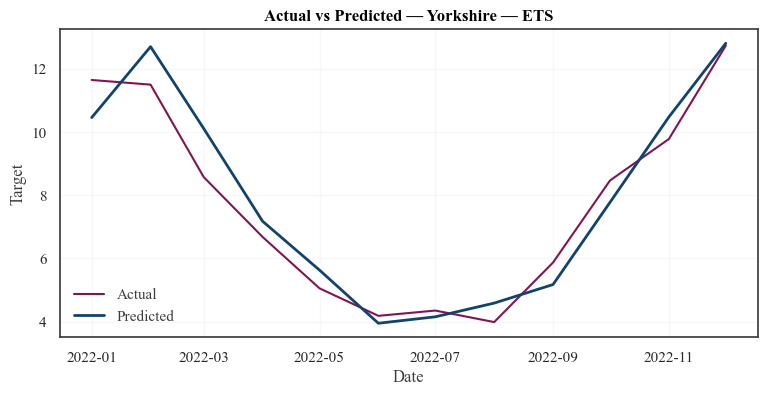

Ljung–Box p-value (lag up to 24): 0.8300
[Note] PACF lags capped to 5 (series length 12).


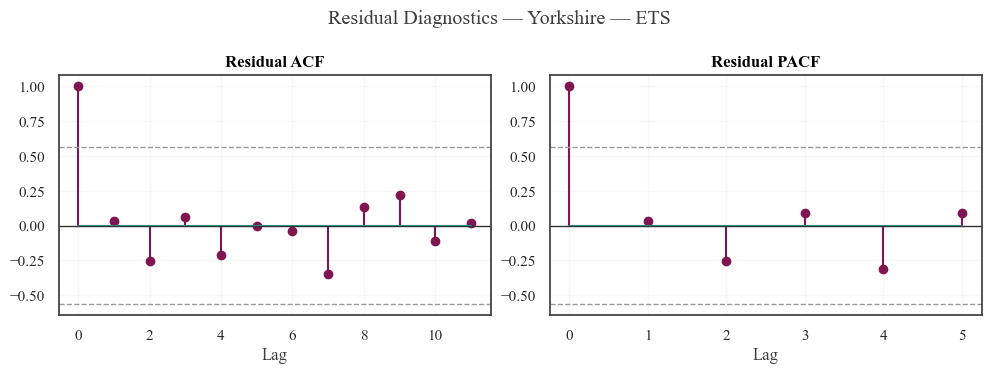

In [35]:
# Plot actual vs predicted for a specific region and model
pipeline.plot_actual_vs_pred(predictions["Yorkshire"], "Yorkshire", "ETS")

# Run residual diagnostics
pipeline.residual_diagnostics(predictions["Yorkshire"], "Yorkshire", "ETS")

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings('ignore')

# Set the theme colors based on your notebook
THEME = {
    "DARK_PINK": "#801650",
    "DARK_BLUE": "#12436D", 
    "TURQUOISE": "#28A197",
    "ORANGE": "#F46A25",
    "DARK_GREY": "#3D3D3D",
    "LIGHT_PURPLE": "#A285D1"
}

# Create sample data based on your analysis
def create_sample_data():
    # Create date range
    dates = pd.date_range('2019-01-01', '2023-12-01', freq='MS')
    
    # Create regions
    regions = ['East Midlands', 'East of England', 'Greater London', 'North East', 
               'North West', 'Scotland', 'South East', 'South West', 'Wales', 
               'West Midlands', 'Yorkshire']
    
    # Create energy consumption data
    np.random.seed(42)
    data = []
    for date in dates:
        for region in regions:
            # Base consumption with seasonality
            base_cons = 50 + 20 * np.sin(2 * np.pi * (date.month - 1) / 12)
            # Regional variation
            reg_var = np.random.uniform(0.8, 1.2)
            # Add some noise
            noise = np.random.normal(0, 5)
            # Calculate consumption
            consumption = base_cons * reg_var + noise
            
            # Add temperature data (inverse relationship with consumption)
            temperature = 15 + 10 * np.sin(2 * np.pi * (date.month - 3) / 12) + np.random.normal(0, 3)
            
            # Add Google Trends-like data
            if date.year >= 2020:  # Trends data starts from 2020
                energy_trend = 50 + 30 * np.sin(2 * np.pi * (date.month - 1) / 12) + np.random.normal(0, 10)
                smart_meter_trend = 40 + 20 * np.cos(2 * np.pi * (date.month - 2) / 12) + np.random.normal(0, 8)
            else:
                energy_trend = np.nan
                smart_meter_trend = np.nan
                
            data.append({
                'date': date,
                'region': region,
                'consumption': max(10, consumption),
                'temperature': max(-5, temperature),
                'energy_trend': energy_trend,
                'smart_meter_trend': smart_meter_trend
            })
    
    return pd.DataFrame(data)

# Create the dashboard
def create_dashboard():
    # Create sample data
    df = create_sample_data()
    
    # Create header
    header = widgets.HTML(
        value="<h1 style='text-align: center; color: #12436D; font-family: Times New Roman, serif;'>Temporal Forecasting Dashboard</h1>"
               "<p style='text-align: center; color: #3D3D3D; font-family: Times New Roman, serif;'>Energy Consumption Analysis with Weather and Google Trends Integration</p>"
    )
    
    # Create filters
    region_filter = widgets.Dropdown(
        options=['All Regions'] + list(df['region'].unique()),
        value='All Regions',
        description='Region:',
        style={'description_width': 'initial'}
    )
    
    metric_filter = widgets.Dropdown(
        options=['Consumption', 'Temperature', 'Energy Trends', 'Smart Meter Trends'],
        value='Consumption',
        description='Metric:',
        style={'description_width': 'initial'}
    )
    
    date_range_filter = widgets.SelectionRangeSlider(
        options=[str(date)[:7] for date in pd.date_range('2019-01', '2023-12', freq='MS')],
        index=(0, len(pd.date_range('2019-01', '2023-12', freq='MS'))-1),
        description='Date Range:',
        continuous_update=False,
        layout={'width': '500px'}
    )
    
    # Create update button
    update_button = widgets.Button(
        description='Update Dashboard',
        button_style='info',
        tooltip='Click to update the dashboard with current filters'
    )
    
    # Create output area for plots
    output = widgets.Output()
    
    # Function to update dashboard
    def update_dashboard(change):
        with output:
            clear_output(wait=True)
            
            # Filter data based on selections
            filtered_df = df.copy()
            
            # Apply region filter
            if region_filter.value != 'All Regions':
                filtered_df = filtered_df[filtered_df['region'] == region_filter.value]
            
            # Apply date range filter
            start_date, end_date = date_range_filter.value
            filtered_df = filtered_df[(filtered_df['date'] >= start_date) & (filtered_df['date'] <= end_date)]
            
            # Create subplots
            fig = make_subplots(
                rows=2, cols=2,
                subplot_titles=('Time Series Analysis', 'Regional Comparison', 
                               'Correlation Analysis', 'Seasonal Patterns'),
                specs=[[{"secondary_y": True}, {}],
                       [{}, {}]],
                vertical_spacing=0.12
            )
            
            # Time Series Analysis
            if metric_filter.value == 'Consumption':
                y_data = filtered_df.groupby('date')['consumption'].mean()
                y_title = 'Consumption (kWh/day)'
                color = THEME['DARK_PINK']
            elif metric_filter.value == 'Temperature':
                y_data = filtered_df.groupby('date')['temperature'].mean()
                y_title = 'Temperature (°C)'
                color = THEME['ORANGE']
            elif metric_filter.value == 'Energy Trends':
                y_data = filtered_df.groupby('date')['energy_trend'].mean()
                y_title = 'Energy Trends Index'
                color = THEME['DARK_BLUE']
            else:  # Smart Meter Trends
                y_data = filtered_df.groupby('date')['smart_meter_trend'].mean()
                y_title = 'Smart Meter Trends Index'
                color = THEME['TURQUOISE']
            
            fig.add_trace(
                go.Scatter(x=y_data.index, y=y_data.values, mode='lines', name=metric_filter.value,
                          line=dict(color=color, width=2)),
                row=1, col=1
            )
            
            # Add secondary axis for temperature if primary is not temperature
            if metric_filter.value != 'Temperature':
                temp_data = filtered_df.groupby('date')['temperature'].mean()
                fig.add_trace(
                    go.Scatter(x=temp_data.index, y=temp_data.values, mode='lines', name='Temperature',
                              line=dict(color=THEME['ORANGE'], width=2, dash='dash')),
                    row=1, col=1, secondary_y=True
                )
                fig.update_yaxes(title_text="Temperature (°C)", secondary_y=True, row=1, col=1)
            
            fig.update_yaxes(title_text=y_title, row=1, col=1)
            
            # Regional Comparison
            regional_data = filtered_df.groupby('region')['consumption'].mean().sort_values(ascending=True)
            fig.add_trace(
                go.Bar(x=regional_data.values, y=regional_data.index, orientation='h',
                      marker_color=THEME['DARK_BLUE'], name='Average Consumption'),
                row=1, col=2
            )
            fig.update_xaxes(title_text="Average Consumption (kWh/day)", row=1, col=2)
            
            # Correlation Analysis
            if metric_filter.value in ['Consumption', 'Temperature']:
                if metric_filter.value == 'Consumption':
                    x_data = filtered_df['temperature']
                    y_data = filtered_df['consumption']
                    x_title = 'Temperature (°C)'
                    y_title = 'Consumption (kWh/day)'
                else:
                    x_data = filtered_df['consumption']
                    y_data = filtered_df['temperature']
                    x_title = 'Consumption (kWh/day)'
                    y_title = 'Temperature (°C)'
                
                fig.add_trace(
                    go.Scatter(x=x_data, y=y_data, mode='markers', name='Correlation',
                              marker=dict(color=THEME['LIGHT_PURPLE'], size=6, opacity=0.6)),
                    row=2, col=1
                )
                
                # Add trendline (only if we have enough data points)
                if len(x_data) > 1:
                    try:
                        z = np.polyfit(x_data, y_data, 1)
                        p = np.poly1d(z)
                        fig.add_trace(
                            go.Scatter(x=x_data, y=p(x_data), mode='lines', name='Trendline',
                                      line=dict(color=THEME['DARK_PINK'], width=3)),
                            row=2, col=1
                        )
                    except:
                        # If polyfit fails, skip the trendline
                        pass
                
                fig.update_xaxes(title_text=x_title, row=2, col=1)
                fig.update_yaxes(title_text=y_title, row=2, col=1)
            else:
                # For trends, show both trends vs consumption
                if metric_filter.value == 'Energy Trends':
                    trend_data = filtered_df['energy_trend']
                else:
                    trend_data = filtered_df['smart_meter_trend']
                
                # Remove NaN values for trend data
                valid_indices = ~trend_data.isna()
                trend_data_valid = trend_data[valid_indices]
                consumption_valid = filtered_df['consumption'][valid_indices]
                
                if len(trend_data_valid) > 0:
                    fig.add_trace(
                        go.Scatter(x=trend_data_valid, y=consumption_valid, mode='markers',
                                  marker=dict(color=THEME['LIGHT_PURPLE'], size=6, opacity=0.6),
                                  name='Trend vs Consumption'),
                        row=2, col=1
                    )
                    
                    # Add trendline (only if we have enough data points)
                    if len(trend_data_valid) > 1:
                        try:
                            z = np.polyfit(trend_data_valid, consumption_valid, 1)
                            p = np.poly1d(z)
                            fig.add_trace(
                                go.Scatter(x=trend_data_valid, y=p(trend_data_valid), mode='lines', name='Trendline',
                                          line=dict(color=THEME['DARK_PINK'], width=3)),
                                row=2, col=1
                            )
                        except:
                            # If polyfit fails, skip the trendline
                            pass
                    
                    fig.update_xaxes(title_text=f"{metric_filter.value} Index", row=2, col=1)
                    fig.update_yaxes(title_text="Consumption (kWh/day)", row=2, col=1)
                else:
                    # No valid trend data in selected range
                    fig.add_annotation(
                        x=0.5, y=0.5, xref="x domain", yref="y domain",
                        text="No trend data available for selected period",
                        showarrow=False,
                        row=2, col=1
                    )
            
            # Seasonal Patterns
            filtered_df['month'] = filtered_df['date'].dt.month
            seasonal_data = filtered_df.groupby('month')['consumption'].mean()
            
            fig.add_trace(
                go.Scatter(x=seasonal_data.index, y=seasonal_data.values, mode='lines+markers',
                          line=dict(color=THEME['TURQUOISE'], width=3),
                          marker=dict(size=8), name='Seasonal Pattern'),
                row=2, col=2
            )
            fig.update_xaxes(title_text="Month", tickvals=list(range(1, 13)), 
                            ticktext=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                     'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                            row=2, col=2)
            fig.update_yaxes(title_text="Average Consumption (kWh/day)", row=2, col=2)
            
            # Update layout
            fig.update_layout(
                height=800,
                showlegend=True,
                title_text="Temporal Forecasting Analysis",
                title_x=0.5,
                font=dict(family="Times New Roman, Times, serif", size=12),
                plot_bgcolor='white'
            )
            
            # Update grid colors
            fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='#E6E6EE')
            fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='#E6E6EE')
            
            fig.show()
            
            # Display summary statistics
            print("\nSummary Statistics:")
            print("===================")
            print(f"Time Period: {start_date} to {end_date}")
            if region_filter.value != 'All Regions':
                print(f"Region: {region_filter.value}")
            else:
                print("Region: All Regions")
            
            avg_consumption = filtered_df['consumption'].mean()
            avg_temperature = filtered_df['temperature'].mean()
            
            print(f"Average Consumption: {avg_consumption:.2f} kWh/day")
            print(f"Average Temperature: {avg_temperature:.2f} °C")
            
            if not filtered_df['energy_trend'].isna().all():
                avg_energy_trend = filtered_df['energy_trend'].mean()
                avg_smart_meter_trend = filtered_df['smart_meter_trend'].mean()
                print(f"Average Energy Trends Index: {avg_energy_trend:.2f}")
                print(f"Average Smart Meter Trends Index: {avg_smart_meter_trend:.2f}")
    
    # Set up event handlers
    update_button.on_click(update_dashboard)
    region_filter.observe(update_dashboard, names='value')
    metric_filter.observe(update_dashboard, names='value')
    date_range_filter.observe(update_dashboard, names='value')
    
    # Initial update
    update_dashboard(None)
    
    # Display the dashboard
    filters = widgets.HBox([region_filter, metric_filter, date_range_filter, update_button])
    display(header, filters, output)

# Create the dashboard
create_dashboard()

HTML(value="<h1 style='text-align: center; color: #12436D; font-family: Times New Roman, serif;'>Temporal Fore…

Output()